# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.10.0+cu111
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [3]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content

os.chdir('/content')

--2021-11-24 23:22:30--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.24MB/s    in 1.0s    

2021-11-24 23:22:32 (2.24 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


In [4]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [5]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    data = data.replace("/\s\s+/g", ' ');
    
    mapIndex = 0
    for char in data:
        # TODO Fill this in
        if (char not in voc2ind):
            voc2ind[char] = mapIndex
            mapIndex += 1

    ind2voc = {val: key for key, val in voc2ind.items()}

    parts = data.split()
    train_text = ' '.join(parts[:int(len(parts)*.8)]) # TODO Fill this in
    test_text = ' '.join(parts[int(len(parts)*.8):]) # TODO Fill this in

    train_text = [char for char in train_text]
    test_text = [charx for charx in test_text]

    train_text = list(map(lambda x: voc2ind[x], train_text))
    test_text = list(map(lambda x: voc2ind[x], test_text))

    train_text = np.fromiter(train_text, dtype=np.int)
    test_text = np.fromiter(test_text, dtype=np.int)

    print(voc2ind)
    print(ind2voc)

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

{'H': 0, 'a': 1, 'r': 2, 'y': 3, ' ': 4, 'P': 5, 'o': 6, 't': 7, 'e': 8, 'n': 9, 'd': 10, 'h': 11, 'S': 12, 'c': 13, "'": 14, 's': 15, '\n': 16, 'C': 17, 'A': 18, 'T': 19, 'E': 20, 'R': 21, 'O': 22, 'N': 23, 'B': 24, 'Y': 25, 'W': 26, 'L': 27, 'I': 28, 'V': 29, 'D': 30, 'M': 31, '.': 32, 'u': 33, 'l': 34, ',': 35, 'f': 36, 'm': 37, 'b': 38, 'i': 39, 'v': 40, 'w': 41, 'p': 42, 'k': 43, 'x': 44, 'g': 45, 'j': 46, 'G': 47, ';': 48, '-': 49, '"': 50, 'F': 51, 'z': 52, '?': 53, '!': 54, 'q': 55, 'K': 56, '(': 57, ')': 58, ':': 59, 'J': 60, 'U': 61, '4': 62, '1': 63, '7': 64, 'Z': 65, '3': 66, 'Q': 67, '~': 68, '0': 69, '2': 70, '8': 71, 'X': 72, '9': 73, '5': 74, '*': 75, '6': 76, '\\': 77, '/': 78, '`': 79, '_': 80, '=': 81, '$': 82, '%': 83, ']': 84, '&': 85, '}': 86, '^': 87, '{': 88, '[': 89, '\x1f': 90}
{0: 'H', 1: 'a', 2: 'r', 3: 'y', 4: ' ', 5: 'P', 6: 'o', 7: 't', 8: 'e', 9: 'n', 10: 'd', 11: 'h', 12: 'S', 13: 'c', 14: "'", 15: 's', 16: '\n', 17: 'C', 18: 'A', 19: 'T', 20: 'E', 21: 

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [6]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.voc2ind = dataset['voc2ind']
        self.ind2voc = dataset['ind2voc']
        dataset = dataset['tokens']
        self.data = torch.tensor(dataset[:len(dataset) - 1], dtype=torch.long)
        self.labels = torch.tensor(dataset[1:], dtype=torch.long)

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        bigChunk = int(len(self.data) / self.batch_size) # starting points for each batch index
        seqCount = int(bigChunk / self.sequence_length) * self.batch_size
        return seqCount
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        chunkWidth = self.sequence_length
        bigChunk = int(len(self.data) / self.batch_size) # starting points for each batch index
        # bigChunk = int(len(self.data) / numChunks) # starting points for each batch index
        batchAreaNum = (idx % self.batch_size) * bigChunk # Which big chunk to look in? (starting position for chunk)
        batchBigPosition = int(idx / self.batch_size) * self.sequence_length  # starting position for sequence
        sequenceAbsolute = batchAreaNum + batchBigPosition # start for next sequence
        nextPosition = bigChunk * ((idx % self.batch_size) + 1)
        if (sequenceAbsolute + chunkWidth > nextPosition):
            chunkWidth = nextPosition - sequenceAbsolute
        elif (sequenceAbsolute + chunkWidth > len(self.data)):
            chunkWidth = len(self.data) - sequenceAbsolute
        dataChunk = self.data[sequenceAbsolute : sequenceAbsolute + chunkWidth]
        labelChunk = self.labels[sequenceAbsolute : sequenceAbsolute + chunkWidth]
        
        return dataChunk, labelChunk

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [9]:
TEMPERATURE = 1

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size, device):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1

        self.device = device
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]

        if hidden_state is None:
          hidden_state = torch.zeros(1, batch_size, self.feature_size).to(self.device)

        encodeOut = self.encoder(x)
        gruOut, hidden_state = self.gru(encodeOut, hidden_state)
        decodeOut = self.decoder(gruOut)

        return decodeOut, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [8]:
TEMPERATURE = 2
BEAM_WIDTH = 10

import math

def max_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        # find max from output
        maxArg = output.argmax().item()
        outputs.append(maxArg)
        # put output into inference

        nextInput = torch.tensor([maxArg], dtype=torch.long).to(device)
        output, hidden = model.inference(nextInput, hidden, TEMPERATURE)
        # Get new output, loop it
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        # find the current sample from output
        sample = torch.multinomial(output, 1).item()
        outputs.append(sample)
        # put output into inference

        nextInput = torch.tensor([sample], dtype=torch.long).to(device)
        output, hidden = model.inference(nextInput, hidden, TEMPERATURE)
        # Get new output, loop it
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device):
    outputs = []
    beams = [([], output, hidden, 0)]
    # TODO

    # 1. Initialize the beam list with the single existing empty beam
    # 2. Repeat for the sequence length:
    #     1. For each beam in the beam list:
    #         1. Compute the next distribution over the output space for that state
    #         2. Sample from the distribution with replacement
    #         3. For each sample:
    #             1. Compute its score
    #             2. Record its hidden state and chosen value
    #         4. Add all the samples to the new beam list      
    #      2. Rank the new beam list
    #      3. Throw out all but the top beam_width beams
    #  3. Return the top beam's chosen values.
    beams[0][0].append(output.argmax().item())
    for i in range(0, sequence_length):
        new_beams = []
        for beam in beams:
            # next distribution
            nextInput = torch.tensor([beam[0][len(beam[0]) - 1]], dtype=torch.long).to(device)
            samples, hidden = model.inference(nextInput, beam[2], TEMPERATURE)
            # sample the distr. with replacement
            samples = samples[0]
            for i in range(0, len(samples)):
                sample = samples[i]

                # score compute
                current_prob = sample.item()
                if (current_prob <= 0):
                    current_prob = 0.00001;
                new_beam3 = beam[3] + math.log(current_prob)
                # record hidden state and chosen value
                new_beam2 = hidden.detach().clone()
                new_beam1 = sample.item()

                new_beam0 = []
                new_beam0.extend(beam[0])
                new_beam0.append(i)

                new_beam = (new_beam0, new_beam1, new_beam2, new_beam3)
                new_beams.append(new_beam)
            # all samples to new beam list
        # rank beam list
        new_beams.sort(key=lambda x:x[3], reverse = True)
        
        # keep only top n beams
        beams = new_beams[:beam_width]
    # top beam chosen value
    outputs = beams[0][0][1:]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words).to(device)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden, TEMPERATURE)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [10]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([91, 512]) = 0MB
decoder.weight -> 	torch.Size([91, 512]) = 0MB
decoder.bias -> 	torch.Size([91]) = 0MB

Did not restore:
	lstm.bias_hh_l0
	lstm.bias_ih_l0
	lstm.weight_hh_l0
	lstm.weight_ih_l0
Initialized but did not modify:
	gru.bias_hh_l0
	gru.bias_ih_l0
	gru.weight_hh_l0
	gru.weight_ih_l0
Restored /content/checkpoints/020.pt
generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. _O[j8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. _OVif[jLLSs6SpoTF^5B]B]B]s`66SIsvooTFTFFBn}=F*CrN$?'Ugggo2EABcn9oTFFB(`oTFTFFBnoB]B6Sm-diqpTFFTFFBnBn$*,g-\QhrU:pFITFBn9^1Snm*,$$?J!aFRS^6oSNKK}=%`h5~V5VQ88'Gr&W hf//wM38n$*K`:,:*!2a(ww$?="K`m66Ug h
generated sample	 Harry Potter, Voldemort, an

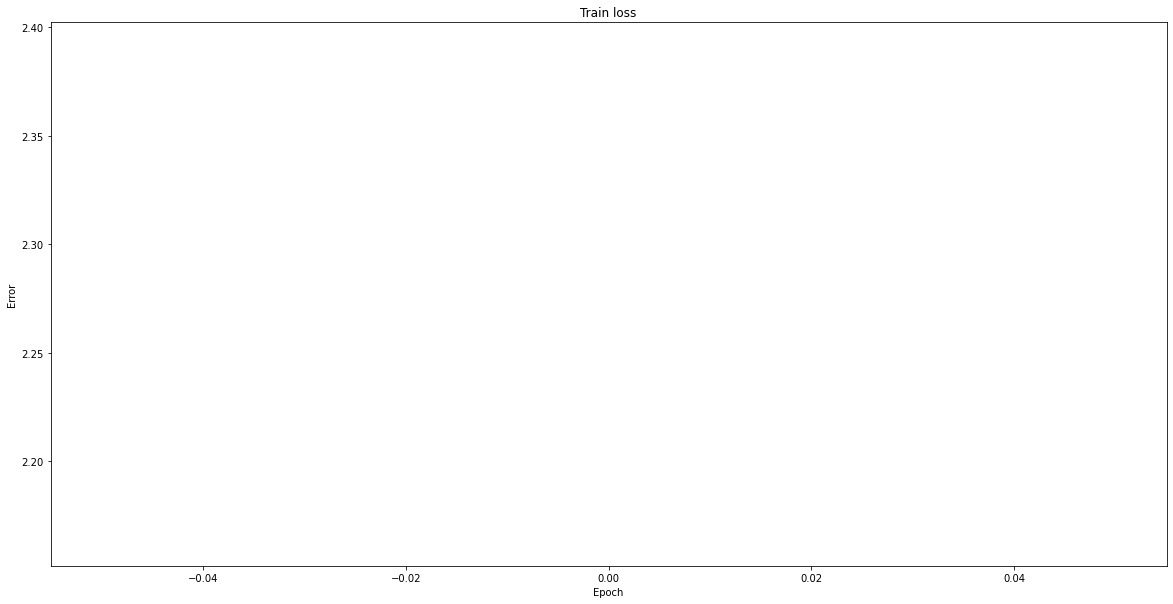

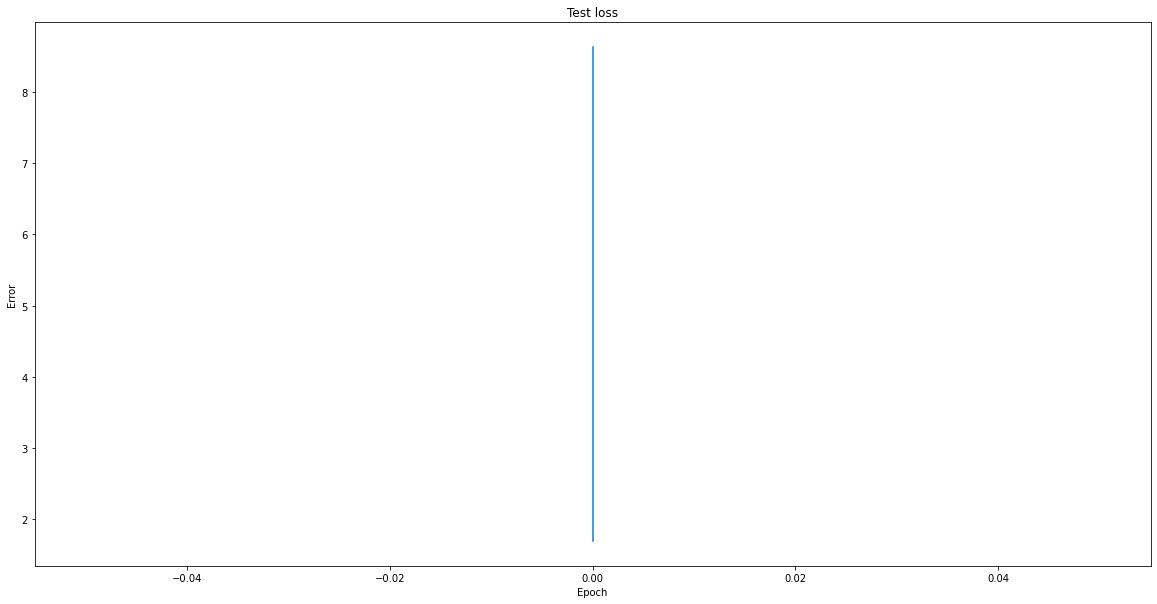

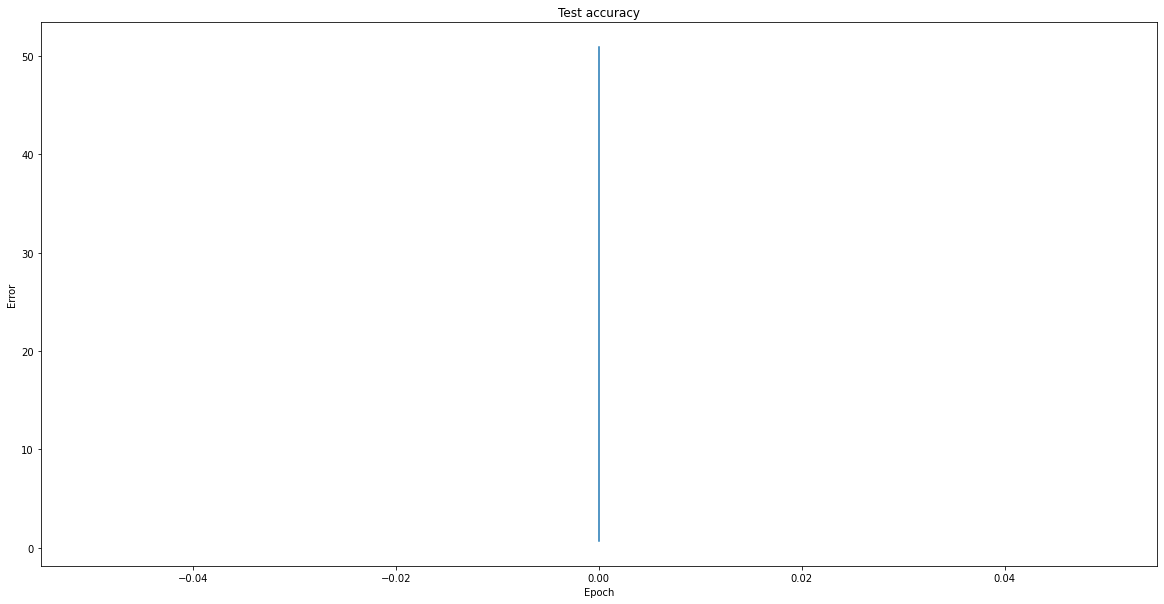

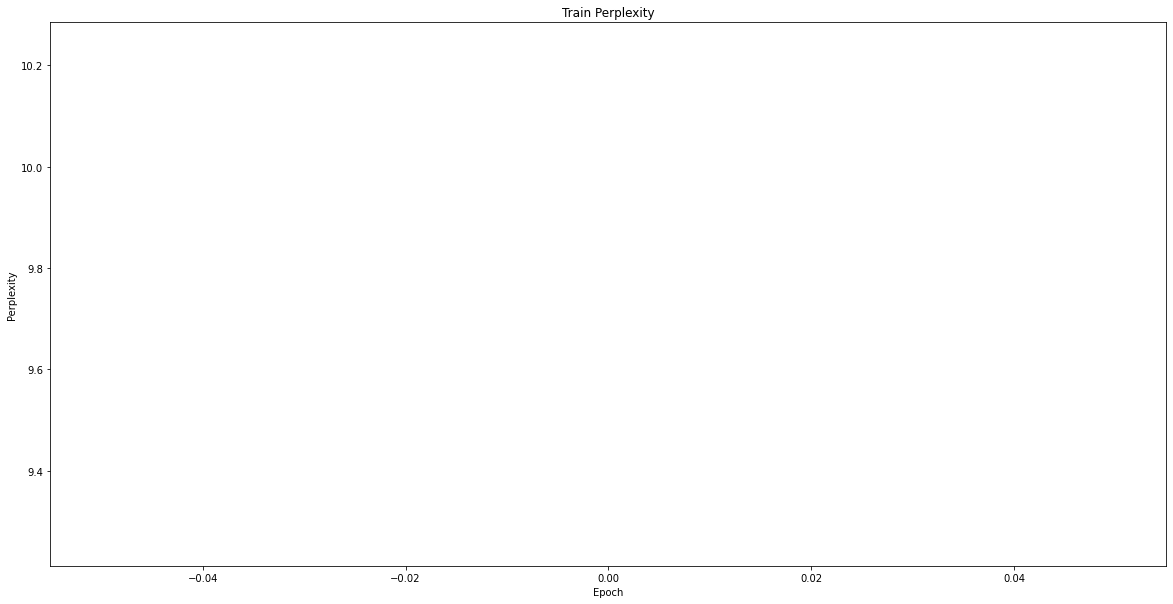

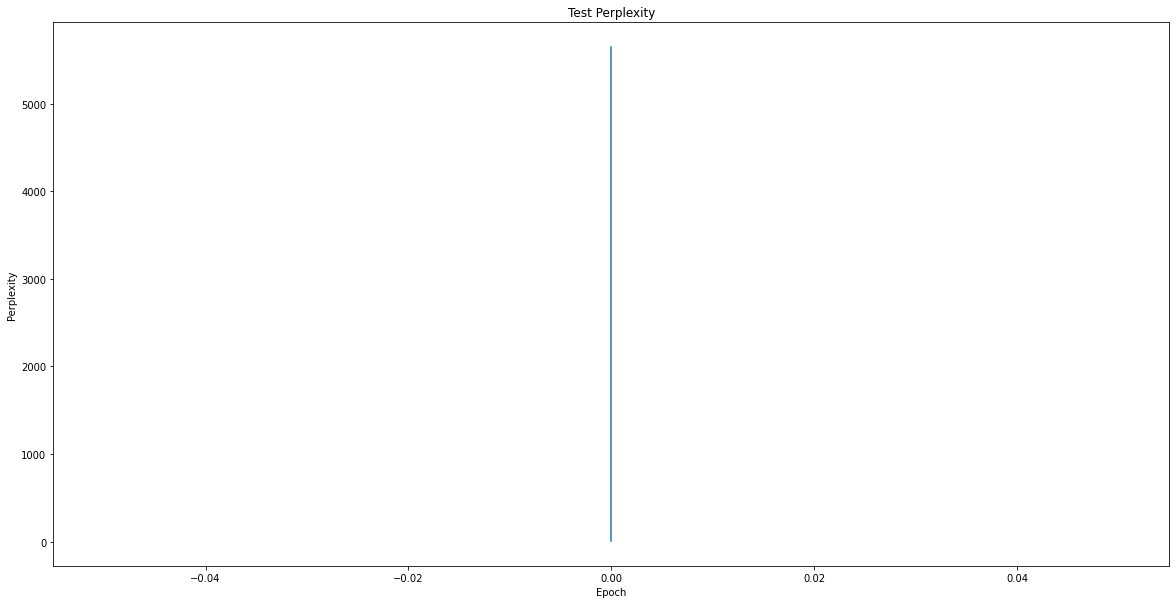

In [ ]:
import math

def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE, device).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))

    # test_loss, test_accuracy = test(model, device, test_loader)
    # test_losses.append((start_epoch, test_loss))
    # test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))

            # train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            # test_loss, test_accuracy = test(model, device, test_loader)
            # train_losses.append((epoch, train_loss))
            # test_losses.append((epoch, test_loss))
            # test_accuracies.append((epoch, test_accuracy))
            # pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            # model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)

            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)

        train_perplexity = list(map(lambda epochLoss: (epochLoss[0], math.exp(epochLoss[1])), train_losses))
        test_perplexity = list(map(lambda epochLoss: (epochLoss[0], math.exp(epochLoss[1])), test_losses))

        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexity)
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_perplexity)
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Perplexity')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and theyBn9Ik=SYj8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h_fCDQ8'GUgg h
generated with sample	 Harry Potter and the_!22)diYi6gm-dimdi6-`Sm6"IEA?'7k=S^s`m6S6SYs`x _iUggg%oojRRS6SSpIvwoohCQ]HSn*j,7QK(}TF`Sm?6disgoTFTFF`m[(wwZTSm^s`m6diGJ6S6Ss{{eyEAVZBnyB6wwZBn$c"aB(i6Hn$$?nc'a'71S^$?)?diUUggg6oTFFBnWh }S({{{{T
generated with sample	 Harry Potter and theyYij;;r:I{TeyBnyBm6di6Ugg h_{-u?Uggg66diqqq)AfAFBns`m66oTFB=^lRSY;ITFws
AoBQ8'K(iUggg 2mdim6UggooTFTFB=B]%"qqq)qq."u?J!aFB(iUgggoudiUFB6oTFBnw$??'.r&uf[Lys`h`hp_];;IYisg 2dismdiis`m6dii$?TFmB(Y
generated with sample	 Harry Potter and theyB6m-didipi:q?JS^{M3[6"ak=
qfAVO[j.?m-di$?'UgJ lfCr:.r:,7QqTFTFTFFBn'=UgS6SYmMQ8oKj~(c"8'GJS^^sD(=`["64""ggak=SY^s`mS6qY)\QlHaSY8'UggoBxn$`m66goToTFFB'=%j~(?'Ugg m6di-di66Ugg-di4q"qqqqTFk(iUgg h}TF`[
generated with sample	 Harr

KeyboardInterrupt: ignored

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



In [ ]:
# 1: New Corpus

import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'movie_lines.txt')):
    os.chdir(BASE_PATH)
    !wget https://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
    !unzip cornell_movie_dialogs_corpus.zip
    !rm cornell_movie_dialogs_corpus.zip
    !ls
    !cp 'cornell movie-dialogs corpus'/movie_lines.txt /content

os.chdir('/content')

import re

def prepare_data(data_path):
    with open(data_path, encoding='ISO-8859-1') as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()  # , encoding="latin-1"
    
    # TODO Add more preprocessing
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    # L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ 
    # data = data.replace("L([0-9]+) +++$+++ u([0-9]+) +++$+++ m([0-9]+) +++$+++ ([a-zA-Z]+) +++$+++", '');
    data = re.sub('L\S+ \+\+\+\$\+\+\+ u\S+ \+\+\+\$\+\+\+ m\S+ \+\+\+\$\+\+\+ [a-zA-Z ]+ \+\+\+\$\+\+\+ ', '', data)
    data = data.replace("/\s\s+/g", ' ');

    mapIndex = 0
    for char in data:
        # TODO Fill this in
        if (char not in voc2ind):
            voc2ind[char] = mapIndex
            mapIndex += 1

    ind2voc = {val: key for key, val in voc2ind.items()}

    parts = data.split()
    train_text = ' '.join(parts[:int(len(parts)*.8)]) # TODO Fill this in
    test_text = ' '.join(parts[int(len(parts)*.8):]) # TODO Fill this in

    train_text = [char for char in train_text]
    test_text = [charx for charx in test_text]

    train_text = list(map(lambda x: voc2ind[x], train_text))
    test_text = list(map(lambda x: voc2ind[x], test_text))

    train_text = np.fromiter(train_text, dtype=np.int)
    test_text = np.fromiter(test_text, dtype=np.int)

    print(voc2ind)
    print(ind2voc)

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'movie_lines_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'movie_lines_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'movie_lines.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)


import math

def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'movie_lines_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'movie_lines_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE, device).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpointsmovie')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))

    test_loss, test_accuracy = test(model, device, test_loader)
    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))

            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpointsmovie/%03d.pt' % epoch)

            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpointsmovie/%03d.pt' % epoch, 0)

        train_perplexity = list(map(lambda epochLoss: (epochLoss[0], math.exp(epochLoss[1])), train_losses))
        test_perplexity = list(map(lambda epochLoss: (epochLoss[0], math.exp(epochLoss[1])), test_losses))

        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexity)
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_perplexity)
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Perplexity')
        return model, vocab, device

final_model, vocab, device = main()

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([91, 512]) = 0MB
lstm.weight_ih_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.weight_hh_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.bias_ih_l0 -> 	torch.Size([2048]) = 0MB
lstm.bias_hh_l0 -> 	torch.Size([2048]) = 0MB
decoder.weight -> 	torch.Size([91, 512]) = 0MB
decoder.bias -> 	torch.Size([91]) = 0MB

Restored all variables
No new variables
Restored /content/checkpointslstm/001.pt
Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en.aore w  or nwaoattng th ard  tes anound the stde ,tf tteuee aut ti seangid t d tti thet hot esng 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 tatd  "ee 

  1%|          | 1/194 [00:00<02:33,  1.26it/s]

Train Epoch: 1 [0/49664 (0%)]	Loss: 1.652781


  6%|▌         | 11/194 [00:04<01:04,  2.82it/s]

Train Epoch: 1 [2560/49664 (5%)]	Loss: 2.398856


 11%|█         | 21/194 [00:10<01:38,  1.75it/s]

Train Epoch: 1 [5120/49664 (10%)]	Loss: 1.949868


 16%|█▌        | 31/194 [00:14<01:24,  1.94it/s]

Train Epoch: 1 [7680/49664 (15%)]	Loss: 1.780218


 21%|██        | 41/194 [00:21<01:28,  1.73it/s]

Train Epoch: 1 [10240/49664 (21%)]	Loss: 1.714607


 26%|██▋       | 51/194 [00:23<00:31,  4.58it/s]

Train Epoch: 1 [12800/49664 (26%)]	Loss: 1.668727


 31%|███▏      | 61/194 [00:30<01:32,  1.43it/s]

Train Epoch: 1 [15360/49664 (31%)]	Loss: 1.665037


 37%|███▋      | 71/194 [00:34<00:58,  2.09it/s]

Train Epoch: 1 [17920/49664 (36%)]	Loss: 1.619582


 42%|████▏     | 81/194 [00:37<00:33,  3.33it/s]

Train Epoch: 1 [20480/49664 (41%)]	Loss: 1.639934


 47%|████▋     | 91/194 [00:42<00:35,  2.91it/s]

Train Epoch: 1 [23040/49664 (46%)]	Loss: 1.620796


 52%|█████▏    | 101/194 [00:47<00:59,  1.57it/s]

Train Epoch: 1 [25600/49664 (52%)]	Loss: 1.595214


 57%|█████▋    | 111/194 [00:52<00:47,  1.76it/s]

Train Epoch: 1 [28160/49664 (57%)]	Loss: 1.590172


 62%|██████▏   | 121/194 [00:56<00:35,  2.05it/s]

Train Epoch: 1 [30720/49664 (62%)]	Loss: 1.621493


 68%|██████▊   | 131/194 [01:00<00:16,  3.81it/s]

Train Epoch: 1 [33280/49664 (67%)]	Loss: 1.571666


 73%|███████▎  | 141/194 [01:03<00:19,  2.74it/s]

Train Epoch: 1 [35840/49664 (72%)]	Loss: 1.556751


 78%|███████▊  | 151/194 [01:09<00:28,  1.49it/s]

Train Epoch: 1 [38400/49664 (77%)]	Loss: 1.533553


 83%|████████▎ | 161/194 [01:16<00:15,  2.17it/s]

Train Epoch: 1 [40960/49664 (82%)]	Loss: 1.557180


 88%|████████▊ | 171/194 [01:22<00:13,  1.74it/s]

Train Epoch: 1 [43520/49664 (88%)]	Loss: 1.581756


 93%|█████████▎| 181/194 [01:26<00:06,  2.12it/s]

Train Epoch: 1 [46080/49664 (93%)]	Loss: 1.539522


 98%|█████████▊| 191/194 [01:30<00:00,  3.14it/s]

Train Epoch: 1 [48640/49664 (98%)]	Loss: 1.523257


100%|██████████| 194/194 [01:33<00:00,  2.08it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	es.aore a  ereesoeapeng th ard  tes anound the stges.af tteue  aut he seankid atd sti hhet how essg 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 sitd  "ee ceed to tot tou as to the strool  atgra.. .alam trtfres s..  teo   said Rumbledore  "A  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Rarry  "Ial m toneereai ton'aiasoue an o the sreee seoomstickl aeece s dotap th the strool std tot a


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<01:16,  2.51it/s]

Train Epoch: 2 [0/49664 (0%)]	Loss: 1.507205


  6%|▌         | 11/194 [00:03<00:47,  3.83it/s]

Train Epoch: 2 [2560/49664 (5%)]	Loss: 1.516658


 11%|█         | 21/194 [00:06<01:08,  2.53it/s]

Train Epoch: 2 [5120/49664 (10%)]	Loss: 1.533963


 16%|█▌        | 31/194 [00:10<00:58,  2.79it/s]

Train Epoch: 2 [7680/49664 (15%)]	Loss: 1.507741


 21%|██        | 41/194 [00:13<01:21,  1.89it/s]

Train Epoch: 2 [10240/49664 (21%)]	Loss: 1.487614


 26%|██▋       | 51/194 [00:18<00:50,  2.86it/s]

Train Epoch: 2 [12800/49664 (26%)]	Loss: 1.485844


 32%|███▏      | 62/194 [00:22<00:33,  3.97it/s]

Train Epoch: 2 [15360/49664 (31%)]	Loss: 1.492290


 37%|███▋      | 71/194 [00:24<00:27,  4.49it/s]

Train Epoch: 2 [17920/49664 (36%)]	Loss: 1.458117


 42%|████▏     | 81/194 [00:27<00:40,  2.79it/s]

Train Epoch: 2 [20480/49664 (41%)]	Loss: 1.484730


 47%|████▋     | 91/194 [00:31<00:27,  3.76it/s]

Train Epoch: 2 [23040/49664 (46%)]	Loss: 1.461626


 52%|█████▏    | 101/194 [00:36<00:46,  2.01it/s]

Train Epoch: 2 [25600/49664 (52%)]	Loss: 1.474309


 57%|█████▋    | 111/194 [00:39<00:17,  4.79it/s]

Train Epoch: 2 [28160/49664 (57%)]	Loss: 1.461409


 62%|██████▏   | 121/194 [00:45<00:42,  1.71it/s]

Train Epoch: 2 [30720/49664 (62%)]	Loss: 1.503729


 68%|██████▊   | 131/194 [00:49<00:21,  2.92it/s]

Train Epoch: 2 [33280/49664 (67%)]	Loss: 1.454519


 73%|███████▎  | 141/194 [00:52<00:13,  3.80it/s]

Train Epoch: 2 [35840/49664 (72%)]	Loss: 1.441200


 78%|███████▊  | 151/194 [00:55<00:10,  4.04it/s]

Train Epoch: 2 [38400/49664 (77%)]	Loss: 1.417301


 83%|████████▎ | 161/194 [00:59<00:20,  1.59it/s]

Train Epoch: 2 [40960/49664 (82%)]	Loss: 1.442964


 89%|████████▊ | 172/194 [01:03<00:05,  4.38it/s]

Train Epoch: 2 [43520/49664 (88%)]	Loss: 1.474550


 93%|█████████▎| 181/194 [01:08<00:08,  1.54it/s]

Train Epoch: 2 [46080/49664 (93%)]	Loss: 1.436143


 98%|█████████▊| 191/194 [01:11<00:00,  3.74it/s]

Train Epoch: 2 [48640/49664 (98%)]	Loss: 1.431838


100%|██████████| 194/194 [01:13<00:00,  2.64it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	es aore t  iriesaeapeng th ard  tem anound the stde  of ttoue  aut he seank d a d sti thet hot iang 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 satd  "Ih seed to bet tou an to the staool "tor,y . .alam Potfrey s..  beot" said tumbledore  "I  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	tarry  "Ial m Poneertai ton'aersoue on o the sreee waoomstick  weice h wotan th the staool and tot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:03<09:42,  3.02s/it]

Train Epoch: 3 [0/49664 (0%)]	Loss: 1.403022


  6%|▌         | 11/194 [00:07<01:31,  2.01it/s]

Train Epoch: 3 [2560/49664 (5%)]	Loss: 1.427915


 11%|█         | 21/194 [00:10<00:51,  3.38it/s]

Train Epoch: 3 [5120/49664 (10%)]	Loss: 1.448824


 16%|█▌        | 31/194 [00:16<00:53,  3.05it/s]

Train Epoch: 3 [7680/49664 (15%)]	Loss: 1.421643


 21%|██        | 41/194 [00:20<01:29,  1.72it/s]

Train Epoch: 3 [10240/49664 (21%)]	Loss: 1.422180


 26%|██▋       | 51/194 [00:25<01:03,  2.26it/s]

Train Epoch: 3 [12800/49664 (26%)]	Loss: 1.406254


 31%|███▏      | 61/194 [00:28<01:13,  1.81it/s]

Train Epoch: 3 [15360/49664 (31%)]	Loss: 1.418454


 37%|███▋      | 71/194 [00:32<00:43,  2.86it/s]

Train Epoch: 3 [17920/49664 (36%)]	Loss: 1.388237


 42%|████▏     | 82/194 [00:39<00:53,  2.11it/s]

Train Epoch: 3 [20480/49664 (41%)]	Loss: 1.423848


 47%|████▋     | 91/194 [00:42<00:30,  3.33it/s]

Train Epoch: 3 [23040/49664 (46%)]	Loss: 1.407901


 52%|█████▏    | 101/194 [00:45<00:21,  4.32it/s]

Train Epoch: 3 [25600/49664 (52%)]	Loss: 1.413961


 57%|█████▋    | 111/194 [00:50<00:36,  2.29it/s]

Train Epoch: 3 [28160/49664 (57%)]	Loss: 1.405896


 62%|██████▏   | 121/194 [00:54<00:20,  3.65it/s]

Train Epoch: 3 [30720/49664 (62%)]	Loss: 1.445322


 68%|██████▊   | 131/194 [01:00<00:28,  2.25it/s]

Train Epoch: 3 [33280/49664 (67%)]	Loss: 1.399023


 73%|███████▎  | 141/194 [01:04<00:21,  2.44it/s]

Train Epoch: 3 [35840/49664 (72%)]	Loss: 1.391983


 78%|███████▊  | 151/194 [01:07<00:13,  3.29it/s]

Train Epoch: 3 [38400/49664 (77%)]	Loss: 1.375803


 84%|████████▎ | 162/194 [01:12<00:13,  2.40it/s]

Train Epoch: 3 [40960/49664 (82%)]	Loss: 1.406938


 89%|████████▊ | 172/194 [01:15<00:05,  3.89it/s]

Train Epoch: 3 [43520/49664 (88%)]	Loss: 1.434431


 93%|█████████▎| 181/194 [01:17<00:03,  3.29it/s]

Train Epoch: 3 [46080/49664 (93%)]	Loss: 1.393399


 98%|█████████▊| 191/194 [01:21<00:00,  3.54it/s]

Train Epoch: 3 [48640/49664 (98%)]	Loss: 1.396819


100%|██████████| 194/194 [01:22<00:00,  2.34it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	es aere t  irinsaeapeng th ard  tim anound the side  of tieui  aut he seanked ard sei thet hot iang 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 sitd  "Ih seed to bet toursn ah the sirool "aoriy . .alam Potfrey w .  beo " said Humbledore  "I  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry, "Ial m Poneertai wor'airsoue on o the sreee oaoomstick  weice h wotan th the sirool and wot i


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<01:16,  2.54it/s]

Train Epoch: 4 [0/49664 (0%)]	Loss: 1.381215


  6%|▌         | 11/194 [00:03<00:47,  3.86it/s]

Train Epoch: 4 [2560/49664 (5%)]	Loss: 1.382477


 11%|█         | 21/194 [00:07<01:06,  2.61it/s]

Train Epoch: 4 [5120/49664 (10%)]	Loss: 1.416982


 16%|█▌        | 31/194 [00:10<00:51,  3.18it/s]

Train Epoch: 4 [7680/49664 (15%)]	Loss: 1.387588


 21%|██        | 41/194 [00:15<01:05,  2.35it/s]

Train Epoch: 4 [10240/49664 (21%)]	Loss: 1.374744


 27%|██▋       | 52/194 [00:19<00:48,  2.96it/s]

Train Epoch: 4 [12800/49664 (26%)]	Loss: 1.377108


 31%|███▏      | 61/194 [00:23<00:47,  2.81it/s]

Train Epoch: 4 [15360/49664 (31%)]	Loss: 1.383754


 37%|███▋      | 72/194 [00:28<00:42,  2.89it/s]

Train Epoch: 4 [17920/49664 (36%)]	Loss: 1.367837


 42%|████▏     | 81/194 [00:30<00:23,  4.82it/s]

Train Epoch: 4 [20480/49664 (41%)]	Loss: 1.403329


 47%|████▋     | 91/194 [00:34<00:29,  3.45it/s]

Train Epoch: 4 [23040/49664 (46%)]	Loss: 1.378368


 53%|█████▎    | 102/194 [00:38<00:30,  3.02it/s]

Train Epoch: 4 [25600/49664 (52%)]	Loss: 1.387930


 57%|█████▋    | 111/194 [00:41<00:24,  3.37it/s]

Train Epoch: 4 [28160/49664 (57%)]	Loss: 1.376024


 63%|██████▎   | 122/194 [00:44<00:15,  4.79it/s]

Train Epoch: 4 [30720/49664 (62%)]	Loss: 1.417594


 68%|██████▊   | 131/194 [00:46<00:14,  4.22it/s]

Train Epoch: 4 [33280/49664 (67%)]	Loss: 1.377652


 73%|███████▎  | 141/194 [00:50<00:13,  3.84it/s]

Train Epoch: 4 [35840/49664 (72%)]	Loss: 1.387654


 78%|███████▊  | 151/194 [00:56<00:17,  2.45it/s]

Train Epoch: 4 [38400/49664 (77%)]	Loss: 1.376913


 83%|████████▎ | 161/194 [01:00<00:15,  2.15it/s]

Train Epoch: 4 [40960/49664 (82%)]	Loss: 1.382041


 88%|████████▊ | 171/194 [01:04<00:11,  2.07it/s]

Train Epoch: 4 [43520/49664 (88%)]	Loss: 1.411079


 93%|█████████▎| 181/194 [01:07<00:05,  2.42it/s]

Train Epoch: 4 [46080/49664 (93%)]	Loss: 1.371192


 98%|█████████▊| 191/194 [01:11<00:01,  2.78it/s]

Train Epoch: 4 [48640/49664 (98%)]	Loss: 1.369832


100%|██████████| 194/194 [01:12<00:00,  2.67it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aore t  orinsoeapeng to ard  tim a ound the sede  of tieue  aut te weanked atd sei thet hot iang 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 witd  "eh weed to bet touran to the sahool  aer,y . .alam Poterey w .  teo," said Humbledore  "I  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry, "ead m Poneertai tor aeasoue on o the creee oeoomstick  aiice t wottp to the sehool and tot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<01:18,  2.44it/s]

Train Epoch: 5 [0/49664 (0%)]	Loss: 1.351467


  6%|▌         | 11/194 [00:03<00:54,  3.38it/s]

Train Epoch: 5 [2560/49664 (5%)]	Loss: 1.367681


 11%|█         | 21/194 [00:05<00:42,  4.08it/s]

Train Epoch: 5 [5120/49664 (10%)]	Loss: 1.392735


 16%|█▌        | 31/194 [00:08<00:35,  4.58it/s]

Train Epoch: 5 [7680/49664 (15%)]	Loss: 1.370967


 22%|██▏       | 42/194 [00:12<00:44,  3.44it/s]

Train Epoch: 5 [10240/49664 (21%)]	Loss: 1.364889


 27%|██▋       | 52/194 [00:15<00:39,  3.55it/s]

Train Epoch: 5 [12800/49664 (26%)]	Loss: 1.360384


 31%|███▏      | 61/194 [00:17<00:31,  4.19it/s]

Train Epoch: 5 [15360/49664 (31%)]	Loss: 1.373343


 37%|███▋      | 71/194 [00:20<00:34,  3.57it/s]

Train Epoch: 5 [17920/49664 (36%)]	Loss: 1.357828


 42%|████▏     | 82/194 [00:24<00:43,  2.56it/s]

Train Epoch: 5 [20480/49664 (41%)]	Loss: 1.389068


 47%|████▋     | 91/194 [00:28<00:41,  2.47it/s]

Train Epoch: 5 [23040/49664 (46%)]	Loss: 1.367576


 52%|█████▏    | 101/194 [00:32<00:31,  2.92it/s]

Train Epoch: 5 [25600/49664 (52%)]	Loss: 1.373920


 57%|█████▋    | 111/194 [00:37<00:53,  1.55it/s]

Train Epoch: 5 [28160/49664 (57%)]	Loss: 1.367265


 62%|██████▏   | 121/194 [00:41<00:21,  3.47it/s]

Train Epoch: 5 [30720/49664 (62%)]	Loss: 1.408674


 68%|██████▊   | 131/194 [00:44<00:27,  2.32it/s]

Train Epoch: 5 [33280/49664 (67%)]	Loss: 1.373837


 73%|███████▎  | 141/194 [00:48<00:14,  3.58it/s]

Train Epoch: 5 [35840/49664 (72%)]	Loss: 1.371872


 78%|███████▊  | 151/194 [00:50<00:09,  4.69it/s]

Train Epoch: 5 [38400/49664 (77%)]	Loss: 1.364477


 83%|████████▎ | 161/194 [00:55<00:12,  2.58it/s]

Train Epoch: 5 [40960/49664 (82%)]	Loss: 1.367719


 88%|████████▊ | 171/194 [00:58<00:07,  3.03it/s]

Train Epoch: 5 [43520/49664 (88%)]	Loss: 1.403926


 93%|█████████▎| 181/194 [01:02<00:04,  2.80it/s]

Train Epoch: 5 [46080/49664 (93%)]	Loss: 1.358416


 98%|█████████▊| 191/194 [01:07<00:01,  1.95it/s]

Train Epoch: 5 [48640/49664 (98%)]	Loss: 1.359217


100%|██████████| 194/194 [01:08<00:00,  2.84it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aore t dorinaoea eng th ard  tim,anound the sage .of tieu   aut te weanked atd tti thet hoteesng 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 witd  "th weed to tet touran to the saaool  aer,y . .alam Potfrey w .  teo," said Humbledore  "I  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry, "Iar m Ponmertan"ton aeasoue on o the creee oeoomstick  aeele t wotts to the saaool and wot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<01:22,  2.33it/s]

Train Epoch: 6 [0/49664 (0%)]	Loss: 1.342656


  6%|▌         | 12/194 [00:05<01:07,  2.71it/s]

Train Epoch: 6 [2560/49664 (5%)]	Loss: 1.352299


 11%|█         | 21/194 [00:07<00:38,  4.54it/s]

Train Epoch: 6 [5120/49664 (10%)]	Loss: 1.393617


 16%|█▋        | 32/194 [00:11<00:56,  2.88it/s]

Train Epoch: 6 [7680/49664 (15%)]	Loss: 1.366781


 21%|██        | 41/194 [00:16<00:55,  2.76it/s]

Train Epoch: 6 [10240/49664 (21%)]	Loss: 1.358566


 26%|██▋       | 51/194 [00:19<00:49,  2.91it/s]

Train Epoch: 6 [12800/49664 (26%)]	Loss: 1.360915


 32%|███▏      | 62/194 [00:23<00:37,  3.56it/s]

Train Epoch: 6 [15360/49664 (31%)]	Loss: 1.368608


 37%|███▋      | 72/194 [00:26<00:29,  4.19it/s]

Train Epoch: 6 [17920/49664 (36%)]	Loss: 1.350226


 42%|████▏     | 81/194 [00:30<01:07,  1.68it/s]

Train Epoch: 6 [20480/49664 (41%)]	Loss: 1.373318


 47%|████▋     | 91/194 [00:33<00:24,  4.17it/s]

Train Epoch: 6 [23040/49664 (46%)]	Loss: 1.366646


 52%|█████▏    | 101/194 [00:36<00:21,  4.24it/s]

Train Epoch: 6 [25600/49664 (52%)]	Loss: 1.364395


 57%|█████▋    | 111/194 [00:39<00:26,  3.12it/s]

Train Epoch: 6 [28160/49664 (57%)]	Loss: 1.361461


 62%|██████▏   | 121/194 [00:43<00:26,  2.75it/s]

Train Epoch: 6 [30720/49664 (62%)]	Loss: 1.401118


 68%|██████▊   | 132/194 [00:46<00:16,  3.76it/s]

Train Epoch: 6 [33280/49664 (67%)]	Loss: 1.375576


 73%|███████▎  | 141/194 [00:50<00:31,  1.68it/s]

Train Epoch: 6 [35840/49664 (72%)]	Loss: 1.364530


 78%|███████▊  | 151/194 [00:54<00:16,  2.59it/s]

Train Epoch: 6 [38400/49664 (77%)]	Loss: 1.346953


 83%|████████▎ | 161/194 [00:59<00:10,  3.22it/s]

Train Epoch: 6 [40960/49664 (82%)]	Loss: 1.364841


 88%|████████▊ | 171/194 [01:03<00:13,  1.77it/s]

Train Epoch: 6 [43520/49664 (88%)]	Loss: 1.402545


 93%|█████████▎| 181/194 [01:05<00:03,  4.33it/s]

Train Epoch: 6 [46080/49664 (93%)]	Loss: 1.353901


 98%|█████████▊| 191/194 [01:09<00:01,  2.97it/s]

Train Epoch: 6 [48640/49664 (98%)]	Loss: 1.356644


100%|██████████| 194/194 [01:10<00:00,  2.76it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aere t dorintoeareng th ard  tem,anound the sege .of tieus  aut he weinked atd tei thet heteesng 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 wing  "eh seed to tet touras to the seaool  aer,y . .aramePomfrey w .  teo," said Humbledore, "e  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry  "earamePonsertan tar'aeasoue on o the sreee oeoomsticks aeele t wotts to the sehool and tot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<02:35,  1.24it/s]

Train Epoch: 7 [0/49664 (0%)]	Loss: 1.357558


  6%|▌         | 11/194 [00:03<00:47,  3.83it/s]

Train Epoch: 7 [2560/49664 (5%)]	Loss: 1.347136


 11%|█▏        | 22/194 [00:06<00:37,  4.62it/s]

Train Epoch: 7 [5120/49664 (10%)]	Loss: 1.385984


 16%|█▋        | 32/194 [00:09<00:47,  3.38it/s]

Train Epoch: 7 [7680/49664 (15%)]	Loss: 1.358602


 21%|██        | 41/194 [00:11<00:42,  3.59it/s]

Train Epoch: 7 [10240/49664 (21%)]	Loss: 1.362933


 26%|██▋       | 51/194 [00:16<01:05,  2.19it/s]

Train Epoch: 7 [12800/49664 (26%)]	Loss: 1.355527


 31%|███▏      | 61/194 [00:19<00:31,  4.18it/s]

Train Epoch: 7 [15360/49664 (31%)]	Loss: 1.367237


 37%|███▋      | 71/194 [00:22<00:41,  2.94it/s]

Train Epoch: 7 [17920/49664 (36%)]	Loss: 1.337108


 42%|████▏     | 82/194 [00:27<00:46,  2.41it/s]

Train Epoch: 7 [20480/49664 (41%)]	Loss: 1.366940


 47%|████▋     | 92/194 [00:30<00:26,  3.87it/s]

Train Epoch: 7 [23040/49664 (46%)]	Loss: 1.358000


 53%|█████▎    | 102/194 [00:32<00:24,  3.79it/s]

Train Epoch: 7 [25600/49664 (52%)]	Loss: 1.354989


 57%|█████▋    | 111/194 [00:35<00:36,  2.28it/s]

Train Epoch: 7 [28160/49664 (57%)]	Loss: 1.357790


 62%|██████▏   | 121/194 [00:38<00:19,  3.67it/s]

Train Epoch: 7 [30720/49664 (62%)]	Loss: 1.397173


 68%|██████▊   | 131/194 [00:41<00:15,  4.09it/s]

Train Epoch: 7 [33280/49664 (67%)]	Loss: 1.361006


 73%|███████▎  | 141/194 [00:46<00:23,  2.25it/s]

Train Epoch: 7 [35840/49664 (72%)]	Loss: 1.363171


 78%|███████▊  | 152/194 [00:48<00:09,  4.49it/s]

Train Epoch: 7 [38400/49664 (77%)]	Loss: 1.359990


 84%|████████▎ | 162/194 [00:51<00:07,  4.11it/s]

Train Epoch: 7 [40960/49664 (82%)]	Loss: 1.368226


 89%|████████▊ | 172/194 [00:54<00:06,  3.47it/s]

Train Epoch: 7 [43520/49664 (88%)]	Loss: 1.390484


 93%|█████████▎| 181/194 [00:58<00:05,  2.23it/s]

Train Epoch: 7 [46080/49664 (93%)]	Loss: 1.350599


 99%|█████████▉| 192/194 [01:01<00:00,  2.41it/s]

Train Epoch: 7 [48640/49664 (98%)]	Loss: 1.350518


100%|██████████| 194/194 [01:02<00:00,  3.09it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aere t dor ntoeateng th ard  tim,anound the stge .of tiers  aut he weanked t d tti thet hothe ng 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 wing  "eh deed to set touras to the fthool  ahr,y . .aram Pomfrey w .  teo,  said Humbledore, "I  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry  "Ioram Ponmertal tor'ae soue tn o the srree oeoomsticks aeele t wotts to the fthool and tot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<01:40,  1.92it/s]

Train Epoch: 8 [0/49664 (0%)]	Loss: 1.342909


  6%|▌         | 11/194 [00:04<00:52,  3.48it/s]

Train Epoch: 8 [2560/49664 (5%)]	Loss: 1.340259


 11%|█         | 21/194 [00:07<01:09,  2.48it/s]

Train Epoch: 8 [5120/49664 (10%)]	Loss: 1.385466


 16%|█▌        | 31/194 [00:11<01:08,  2.38it/s]

Train Epoch: 8 [7680/49664 (15%)]	Loss: 1.356672


 21%|██        | 41/194 [00:15<01:15,  2.02it/s]

Train Epoch: 8 [10240/49664 (21%)]	Loss: 1.358589


 26%|██▋       | 51/194 [00:17<00:30,  4.65it/s]

Train Epoch: 8 [12800/49664 (26%)]	Loss: 1.348462


 32%|███▏      | 62/194 [00:23<00:53,  2.46it/s]

Train Epoch: 8 [15360/49664 (31%)]	Loss: 1.361697


 37%|███▋      | 71/194 [00:25<00:26,  4.68it/s]

Train Epoch: 8 [17920/49664 (36%)]	Loss: 1.331072


 42%|████▏     | 82/194 [00:29<00:36,  3.03it/s]

Train Epoch: 8 [20480/49664 (41%)]	Loss: 1.364275


 47%|████▋     | 91/194 [00:32<00:25,  4.12it/s]

Train Epoch: 8 [23040/49664 (46%)]	Loss: 1.349531


 52%|█████▏    | 101/194 [00:36<00:39,  2.38it/s]

Train Epoch: 8 [25600/49664 (52%)]	Loss: 1.350649


 58%|█████▊    | 112/194 [00:39<00:19,  4.10it/s]

Train Epoch: 8 [28160/49664 (57%)]	Loss: 1.357082


 62%|██████▏   | 121/194 [00:41<00:18,  4.00it/s]

Train Epoch: 8 [30720/49664 (62%)]	Loss: 1.389227


 68%|██████▊   | 131/194 [00:46<00:30,  2.09it/s]

Train Epoch: 8 [33280/49664 (67%)]	Loss: 1.357953


 73%|███████▎  | 141/194 [00:50<00:14,  3.73it/s]

Train Epoch: 8 [35840/49664 (72%)]	Loss: 1.350236


 78%|███████▊  | 152/194 [00:53<00:11,  3.60it/s]

Train Epoch: 8 [38400/49664 (77%)]	Loss: 1.342687


 83%|████████▎ | 161/194 [00:57<00:11,  2.87it/s]

Train Epoch: 8 [40960/49664 (82%)]	Loss: 1.358891


 88%|████████▊ | 171/194 [00:59<00:05,  4.37it/s]

Train Epoch: 8 [43520/49664 (88%)]	Loss: 1.388093


 93%|█████████▎| 181/194 [01:05<00:04,  2.82it/s]

Train Epoch: 8 [46080/49664 (93%)]	Loss: 1.351487


 98%|█████████▊| 191/194 [01:07<00:00,  3.73it/s]

Train Epoch: 8 [48640/49664 (98%)]	Loss: 1.349921


100%|██████████| 194/194 [01:08<00:00,  2.82it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aere t dor ntoeateng th ards tem,anound the stge  of tieui  aut he weenked atd tei thet hothe-ng 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 wing  "eh seed to set touras to the fthool  ahriy . .aram Pomfrey w .  teo,  said Humbledore  "e  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry  "soram Ponmertas tor'ae soue an o the srree oeoomsticks aeele t wotts to the fthool and tot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<02:34,  1.25it/s]

Train Epoch: 9 [0/49664 (0%)]	Loss: 1.347870


  6%|▌         | 11/194 [00:03<01:06,  2.76it/s]

Train Epoch: 9 [2560/49664 (5%)]	Loss: 1.340852


 11%|█         | 21/194 [00:07<00:49,  3.49it/s]

Train Epoch: 9 [5120/49664 (10%)]	Loss: 1.378763


 16%|█▌        | 31/194 [00:12<01:23,  1.94it/s]

Train Epoch: 9 [7680/49664 (15%)]	Loss: 1.350217


 21%|██        | 41/194 [00:15<00:44,  3.41it/s]

Train Epoch: 9 [10240/49664 (21%)]	Loss: 1.338183


 27%|██▋       | 52/194 [00:18<00:38,  3.73it/s]

Train Epoch: 9 [12800/49664 (26%)]	Loss: 1.351954


 31%|███▏      | 61/194 [00:22<01:25,  1.55it/s]

Train Epoch: 9 [15360/49664 (31%)]	Loss: 1.356412


 37%|███▋      | 71/194 [00:25<00:54,  2.27it/s]

Train Epoch: 9 [17920/49664 (36%)]	Loss: 1.330062


 42%|████▏     | 82/194 [00:29<00:24,  4.52it/s]

Train Epoch: 9 [20480/49664 (41%)]	Loss: 1.363805


 47%|████▋     | 91/194 [00:32<00:32,  3.16it/s]

Train Epoch: 9 [23040/49664 (46%)]	Loss: 1.344478


 52%|█████▏    | 101/194 [00:36<00:29,  3.14it/s]

Train Epoch: 9 [25600/49664 (52%)]	Loss: 1.349962


 57%|█████▋    | 111/194 [00:41<00:25,  3.31it/s]

Train Epoch: 9 [28160/49664 (57%)]	Loss: 1.349735


 62%|██████▏   | 121/194 [00:44<00:19,  3.67it/s]

Train Epoch: 9 [30720/49664 (62%)]	Loss: 1.384725


 68%|██████▊   | 131/194 [00:47<00:20,  3.09it/s]

Train Epoch: 9 [33280/49664 (67%)]	Loss: 1.360437


 73%|███████▎  | 141/194 [00:51<00:14,  3.60it/s]

Train Epoch: 9 [35840/49664 (72%)]	Loss: 1.347058


 78%|███████▊  | 151/194 [00:54<00:14,  3.06it/s]

Train Epoch: 9 [38400/49664 (77%)]	Loss: 1.336315


 83%|████████▎ | 161/194 [00:58<00:12,  2.74it/s]

Train Epoch: 9 [40960/49664 (82%)]	Loss: 1.358972


 88%|████████▊ | 171/194 [01:01<00:09,  2.49it/s]

Train Epoch: 9 [43520/49664 (88%)]	Loss: 1.390064


 93%|█████████▎| 181/194 [01:05<00:04,  2.87it/s]

Train Epoch: 9 [46080/49664 (93%)]	Loss: 1.352588


 98%|█████████▊| 191/194 [01:08<00:01,  2.48it/s]

Train Epoch: 9 [48640/49664 (98%)]	Loss: 1.344312


100%|██████████| 194/194 [01:10<00:00,  2.75it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aere t dol naoeateng ah ards tim anound the stge  of tieui  aut he weenked atd tti thet hothi ng 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 wing  "th seed to sot tou as to the fthool  aoriw . .aram Pomfrey w .  teo,  said Humbledore  "t  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry  "toram Ponmertal won'ae soue an o the sroie oeoomsticks aeale t wottp to the fthool and tot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<02:06,  1.52it/s]

Train Epoch: 10 [0/49664 (0%)]	Loss: 1.333973


  6%|▌         | 11/194 [00:04<01:33,  1.96it/s]

Train Epoch: 10 [2560/49664 (5%)]	Loss: 1.335580


 11%|█         | 21/194 [00:09<00:46,  3.73it/s]

Train Epoch: 10 [5120/49664 (10%)]	Loss: 1.370631


 16%|█▋        | 32/194 [00:12<00:43,  3.73it/s]

Train Epoch: 10 [7680/49664 (15%)]	Loss: 1.349352


 21%|██        | 41/194 [00:16<01:22,  1.86it/s]

Train Epoch: 10 [10240/49664 (21%)]	Loss: 1.336791


 26%|██▋       | 51/194 [00:20<00:40,  3.56it/s]

Train Epoch: 10 [12800/49664 (26%)]	Loss: 1.350663


 31%|███▏      | 61/194 [00:24<00:40,  3.25it/s]

Train Epoch: 10 [15360/49664 (31%)]	Loss: 1.357384


 37%|███▋      | 71/194 [00:29<01:24,  1.46it/s]

Train Epoch: 10 [17920/49664 (36%)]	Loss: 1.325211


 42%|████▏     | 82/194 [00:32<00:40,  2.75it/s]

Train Epoch: 10 [20480/49664 (41%)]	Loss: 1.356910


 47%|████▋     | 91/194 [00:35<00:24,  4.24it/s]

Train Epoch: 10 [23040/49664 (46%)]	Loss: 1.341727


 52%|█████▏    | 101/194 [00:39<00:34,  2.73it/s]

Train Epoch: 10 [25600/49664 (52%)]	Loss: 1.344381


 58%|█████▊    | 112/194 [00:42<00:17,  4.77it/s]

Train Epoch: 10 [28160/49664 (57%)]	Loss: 1.343823


 62%|██████▏   | 121/194 [00:45<00:25,  2.86it/s]

Train Epoch: 10 [30720/49664 (62%)]	Loss: 1.381137


 68%|██████▊   | 131/194 [00:47<00:16,  3.74it/s]

Train Epoch: 10 [33280/49664 (67%)]	Loss: 1.363300


 73%|███████▎  | 141/194 [00:51<00:16,  3.13it/s]

Train Epoch: 10 [35840/49664 (72%)]	Loss: 1.344774


 78%|███████▊  | 151/194 [00:54<00:10,  4.22it/s]

Train Epoch: 10 [38400/49664 (77%)]	Loss: 1.328511


 83%|████████▎ | 161/194 [00:59<00:19,  1.70it/s]

Train Epoch: 10 [40960/49664 (82%)]	Loss: 1.348902


 88%|████████▊ | 171/194 [01:02<00:06,  3.47it/s]

Train Epoch: 10 [43520/49664 (88%)]	Loss: 1.373600


 93%|█████████▎| 181/194 [01:06<00:03,  4.32it/s]

Train Epoch: 10 [46080/49664 (93%)]	Loss: 1.346171


 98%|█████████▊| 191/194 [01:10<00:00,  3.16it/s]

Train Epoch: 10 [48640/49664 (98%)]	Loss: 1.346773


100%|██████████| 194/194 [01:11<00:00,  2.71it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aere t dor ntoeateng th ards tim a ound the stge  of tieri  aut he weenked atd tti thet howhisng 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 wing  "th seed to sot touras to the sthool  aor,w . Iaram Pomfrey w .  teo   said Humbledore  "t  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry  "soram Ponmertal wor'ae soue an o the srree oeoomsticks aiele t wottp to the sthool and tot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<01:13,  2.62it/s]

Train Epoch: 11 [0/49664 (0%)]	Loss: 1.333318


  6%|▌         | 12/194 [00:03<01:01,  2.96it/s]

Train Epoch: 11 [2560/49664 (5%)]	Loss: 1.332570


 11%|█▏        | 22/194 [00:06<00:37,  4.59it/s]

Train Epoch: 11 [5120/49664 (10%)]	Loss: 1.368315


 16%|█▋        | 32/194 [00:09<00:49,  3.28it/s]

Train Epoch: 11 [7680/49664 (15%)]	Loss: 1.345521


 22%|██▏       | 42/194 [00:12<00:42,  3.60it/s]

Train Epoch: 11 [10240/49664 (21%)]	Loss: 1.332344


 26%|██▋       | 51/194 [00:16<00:55,  2.58it/s]

Train Epoch: 11 [12800/49664 (26%)]	Loss: 1.344211


 31%|███▏      | 61/194 [00:20<00:59,  2.22it/s]

Train Epoch: 11 [15360/49664 (31%)]	Loss: 1.353139


 37%|███▋      | 71/194 [00:24<01:04,  1.92it/s]

Train Epoch: 11 [17920/49664 (36%)]	Loss: 1.319667


 42%|████▏     | 82/194 [00:27<00:25,  4.47it/s]

Train Epoch: 11 [20480/49664 (41%)]	Loss: 1.355383


 47%|████▋     | 92/194 [00:30<00:35,  2.88it/s]

Train Epoch: 11 [23040/49664 (46%)]	Loss: 1.337951


 52%|█████▏    | 101/194 [00:34<00:28,  3.24it/s]

Train Epoch: 11 [25600/49664 (52%)]	Loss: 1.344367


 57%|█████▋    | 111/194 [00:36<00:20,  4.02it/s]

Train Epoch: 11 [28160/49664 (57%)]	Loss: 1.340667


 62%|██████▏   | 121/194 [00:40<00:32,  2.24it/s]

Train Epoch: 11 [30720/49664 (62%)]	Loss: 1.378122


 68%|██████▊   | 131/194 [00:44<00:35,  1.78it/s]

Train Epoch: 11 [33280/49664 (67%)]	Loss: 1.365996


 73%|███████▎  | 141/194 [00:48<00:15,  3.41it/s]

Train Epoch: 11 [35840/49664 (72%)]	Loss: 1.345781


 78%|███████▊  | 152/194 [00:50<00:09,  4.46it/s]

Train Epoch: 11 [38400/49664 (77%)]	Loss: 1.325285


 83%|████████▎ | 161/194 [00:53<00:12,  2.74it/s]

Train Epoch: 11 [40960/49664 (82%)]	Loss: 1.347395


 88%|████████▊ | 171/194 [00:59<00:07,  2.95it/s]

Train Epoch: 11 [43520/49664 (88%)]	Loss: 1.381931


 93%|█████████▎| 181/194 [01:05<00:07,  1.83it/s]

Train Epoch: 11 [46080/49664 (93%)]	Loss: 1.342533


 98%|█████████▊| 191/194 [01:08<00:00,  3.61it/s]

Train Epoch: 11 [48640/49664 (98%)]	Loss: 1.331819


100%|██████████| 194/194 [01:10<00:00,  2.76it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aere t dor ntoeat ng th ards tim a ound the stge  of tieui  aut he weenked atd tti thet howhi ng 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 wing  "th weed to set tou as to the fthool  ahr,w . Iaram Pomfrey w .  teo   said Humbledore  "t  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry  "sor m Ponmertal won ae wome an o the shoee oeoomsticks aiele t wottp to the sthool and tot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<03:12,  1.00it/s]

Train Epoch: 12 [0/49664 (0%)]	Loss: 1.323817


  6%|▌         | 11/194 [00:04<00:51,  3.57it/s]

Train Epoch: 12 [2560/49664 (5%)]	Loss: 1.329359


 11%|█         | 21/194 [00:09<01:42,  1.69it/s]

Train Epoch: 12 [5120/49664 (10%)]	Loss: 1.363269


 16%|█▌        | 31/194 [00:12<00:43,  3.71it/s]

Train Epoch: 12 [7680/49664 (15%)]	Loss: 1.335719


 21%|██        | 41/194 [00:17<01:20,  1.90it/s]

Train Epoch: 12 [10240/49664 (21%)]	Loss: 1.326936


 27%|██▋       | 52/194 [00:21<00:40,  3.47it/s]

Train Epoch: 12 [12800/49664 (26%)]	Loss: 1.336608


 31%|███▏      | 61/194 [00:24<00:39,  3.38it/s]

Train Epoch: 12 [15360/49664 (31%)]	Loss: 1.343551


 37%|███▋      | 71/194 [00:29<01:27,  1.41it/s]

Train Epoch: 12 [17920/49664 (36%)]	Loss: 1.320814


 42%|████▏     | 81/194 [00:35<00:59,  1.91it/s]

Train Epoch: 12 [20480/49664 (41%)]	Loss: 1.354322


 47%|████▋     | 91/194 [00:39<00:45,  2.27it/s]

Train Epoch: 12 [23040/49664 (46%)]	Loss: 1.339058


 52%|█████▏    | 101/194 [00:43<00:22,  4.06it/s]

Train Epoch: 12 [25600/49664 (52%)]	Loss: 1.336370


 57%|█████▋    | 111/194 [00:50<01:04,  1.29it/s]

Train Epoch: 12 [28160/49664 (57%)]	Loss: 1.337242


 62%|██████▏   | 121/194 [00:53<00:22,  3.22it/s]

Train Epoch: 12 [30720/49664 (62%)]	Loss: 1.375326


 68%|██████▊   | 131/194 [00:56<00:18,  3.48it/s]

Train Epoch: 12 [33280/49664 (67%)]	Loss: 1.353593


 73%|███████▎  | 142/194 [01:01<00:23,  2.23it/s]

Train Epoch: 12 [35840/49664 (72%)]	Loss: 1.339306


 78%|███████▊  | 151/194 [01:03<00:12,  3.52it/s]

Train Epoch: 12 [38400/49664 (77%)]	Loss: 1.324374


 83%|████████▎ | 161/194 [01:08<00:12,  2.59it/s]

Train Epoch: 12 [40960/49664 (82%)]	Loss: 1.346872


 88%|████████▊ | 171/194 [01:11<00:05,  4.35it/s]

Train Epoch: 12 [43520/49664 (88%)]	Loss: 1.366706


 93%|█████████▎| 181/194 [01:16<00:07,  1.73it/s]

Train Epoch: 12 [46080/49664 (93%)]	Loss: 1.338168


 99%|█████████▉| 192/194 [01:21<00:00,  2.39it/s]

Train Epoch: 12 [48640/49664 (98%)]	Loss: 1.336808


100%|██████████| 194/194 [01:22<00:00,  2.34it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aere t dorintoeat ng th ards tim anound the stge  of tieui  tut he weenked atd tti thet howhiung 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 wing  "sh seed to set tourts to the sthool  aori- . Iaram Pomfrey w .  teo,  said Humbledore  "s  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry  "sor m Ponmertal wor wersoue an o the srree oeoomsticks aiele t wottp to the sthool and tot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<01:21,  2.36it/s]

Train Epoch: 13 [0/49664 (0%)]	Loss: 1.324356


  6%|▌         | 11/194 [00:03<00:53,  3.40it/s]

Train Epoch: 13 [2560/49664 (5%)]	Loss: 1.327060


 11%|█         | 21/194 [00:07<01:48,  1.59it/s]

Train Epoch: 13 [5120/49664 (10%)]	Loss: 1.357822


 16%|█▌        | 31/194 [00:11<01:05,  2.48it/s]

Train Epoch: 13 [7680/49664 (15%)]	Loss: 1.331815


 22%|██▏       | 42/194 [00:14<00:34,  4.39it/s]

Train Epoch: 13 [10240/49664 (21%)]	Loss: 1.325909


 26%|██▋       | 51/194 [00:18<00:42,  3.40it/s]

Train Epoch: 13 [12800/49664 (26%)]	Loss: 1.332891


 31%|███▏      | 61/194 [00:20<00:29,  4.48it/s]

Train Epoch: 13 [15360/49664 (31%)]	Loss: 1.341795


 37%|███▋      | 71/194 [00:23<00:36,  3.36it/s]

Train Epoch: 13 [17920/49664 (36%)]	Loss: 1.319988


 42%|████▏     | 81/194 [00:29<01:17,  1.45it/s]

Train Epoch: 13 [20480/49664 (41%)]	Loss: 1.353871


 47%|████▋     | 91/194 [00:32<00:27,  3.75it/s]

Train Epoch: 13 [23040/49664 (46%)]	Loss: 1.339473


 52%|█████▏    | 101/194 [00:36<00:28,  3.26it/s]

Train Epoch: 13 [25600/49664 (52%)]	Loss: 1.333045


 57%|█████▋    | 111/194 [00:39<00:25,  3.21it/s]

Train Epoch: 13 [28160/49664 (57%)]	Loss: 1.331556


 62%|██████▏   | 121/194 [00:43<00:34,  2.09it/s]

Train Epoch: 13 [30720/49664 (62%)]	Loss: 1.372729


 68%|██████▊   | 131/194 [00:47<00:14,  4.29it/s]

Train Epoch: 13 [33280/49664 (67%)]	Loss: 1.338867


 73%|███████▎  | 141/194 [00:50<00:16,  3.30it/s]

Train Epoch: 13 [35840/49664 (72%)]	Loss: 1.337269


 78%|███████▊  | 151/194 [00:54<00:22,  1.92it/s]

Train Epoch: 13 [38400/49664 (77%)]	Loss: 1.318725


 83%|████████▎ | 161/194 [00:58<00:12,  2.58it/s]

Train Epoch: 13 [40960/49664 (82%)]	Loss: 1.343080


 88%|████████▊ | 171/194 [01:04<00:12,  1.85it/s]

Train Epoch: 13 [43520/49664 (88%)]	Loss: 1.370577


 93%|█████████▎| 181/194 [01:07<00:04,  2.71it/s]

Train Epoch: 13 [46080/49664 (93%)]	Loss: 1.338944


 98%|█████████▊| 191/194 [01:11<00:01,  2.15it/s]

Train Epoch: 13 [48640/49664 (98%)]	Loss: 1.337366


100%|██████████| 194/194 [01:13<00:00,  2.65it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aere t dorintoeet ng th ard  tem anound the stge  of tieup  aut he weenked ard tti thet howhiung 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 wing  "se seed to set tou ts to the sthool  aori- . Iaram Pomfrey w .  seow  said Humbledore  "e  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry  "sor m Ponmertal wor we soue an o the soree oeoomsticks aiele t wottp to the sthool and sot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<01:42,  1.89it/s]

Train Epoch: 14 [0/49664 (0%)]	Loss: 1.327492


  6%|▌         | 11/194 [00:05<01:22,  2.21it/s]

Train Epoch: 14 [2560/49664 (5%)]	Loss: 1.325850


 11%|█         | 21/194 [00:08<01:09,  2.48it/s]

Train Epoch: 14 [5120/49664 (10%)]	Loss: 1.354556


 16%|█▋        | 32/194 [00:11<00:34,  4.64it/s]

Train Epoch: 14 [7680/49664 (15%)]	Loss: 1.329132


 21%|██        | 41/194 [00:15<00:53,  2.87it/s]

Train Epoch: 14 [10240/49664 (21%)]	Loss: 1.320867


 26%|██▋       | 51/194 [00:19<00:47,  3.02it/s]

Train Epoch: 14 [12800/49664 (26%)]	Loss: 1.328012


 31%|███▏      | 61/194 [00:22<00:50,  2.65it/s]

Train Epoch: 14 [15360/49664 (31%)]	Loss: 1.337991


 37%|███▋      | 71/194 [00:27<01:05,  1.88it/s]

Train Epoch: 14 [17920/49664 (36%)]	Loss: 1.317857


 42%|████▏     | 81/194 [00:31<00:59,  1.89it/s]

Train Epoch: 14 [20480/49664 (41%)]	Loss: 1.343983


 47%|████▋     | 91/194 [00:36<00:38,  2.70it/s]

Train Epoch: 14 [23040/49664 (46%)]	Loss: 1.336289


 53%|█████▎    | 102/194 [00:41<00:27,  3.36it/s]

Train Epoch: 14 [25600/49664 (52%)]	Loss: 1.332367


 57%|█████▋    | 111/194 [00:45<00:53,  1.56it/s]

Train Epoch: 14 [28160/49664 (57%)]	Loss: 1.328253


 62%|██████▏   | 121/194 [00:50<00:42,  1.73it/s]

Train Epoch: 14 [30720/49664 (62%)]	Loss: 1.368911


 68%|██████▊   | 131/194 [00:54<00:18,  3.38it/s]

Train Epoch: 14 [33280/49664 (67%)]	Loss: 1.337111


 73%|███████▎  | 141/194 [00:58<00:17,  2.98it/s]

Train Epoch: 14 [35840/49664 (72%)]	Loss: 1.331374


 78%|███████▊  | 151/194 [01:03<00:24,  1.76it/s]

Train Epoch: 14 [38400/49664 (77%)]	Loss: 1.317804


 83%|████████▎ | 161/194 [01:07<00:08,  3.81it/s]

Train Epoch: 14 [40960/49664 (82%)]	Loss: 1.341264


 89%|████████▊ | 172/194 [01:12<00:08,  2.53it/s]

Train Epoch: 14 [43520/49664 (88%)]	Loss: 1.369069


 93%|█████████▎| 181/194 [01:15<00:03,  3.62it/s]

Train Epoch: 14 [46080/49664 (93%)]	Loss: 1.335325


 98%|█████████▊| 191/194 [01:20<00:01,  1.94it/s]

Train Epoch: 14 [48640/49664 (98%)]	Loss: 1.329122


100%|██████████| 194/194 [01:23<00:00,  2.33it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aore t derintoeat ng th ards tim anound the stge  of tieri  tut he weenked atd tti thet howhinng 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 wing  "th seed to sot tourts to the sthool  aori- . Iaram Pomfrey s .  t ow  said Humbledore  "v  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry  "sor m Ponmertal wor aersoue an o the soree oroomsticks aiile t wottp to the sthool ond tot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<01:13,  2.61it/s]

Train Epoch: 15 [0/49664 (0%)]	Loss: 1.320587


  6%|▌         | 11/194 [00:04<00:58,  3.14it/s]

Train Epoch: 15 [2560/49664 (5%)]	Loss: 1.322923


 11%|█         | 21/194 [00:09<01:59,  1.45it/s]

Train Epoch: 15 [5120/49664 (10%)]	Loss: 1.357306


 16%|█▌        | 31/194 [00:15<02:18,  1.18it/s]

Train Epoch: 15 [7680/49664 (15%)]	Loss: 1.328931


 21%|██        | 41/194 [00:19<00:55,  2.75it/s]

Train Epoch: 15 [10240/49664 (21%)]	Loss: 1.319978


 26%|██▋       | 51/194 [00:25<01:37,  1.47it/s]

Train Epoch: 15 [12800/49664 (26%)]	Loss: 1.327213


 31%|███▏      | 61/194 [00:27<00:33,  3.92it/s]

Train Epoch: 15 [15360/49664 (31%)]	Loss: 1.334964


 37%|███▋      | 71/194 [00:31<00:40,  3.07it/s]

Train Epoch: 15 [17920/49664 (36%)]	Loss: 1.307595


 42%|████▏     | 81/194 [00:37<01:08,  1.66it/s]

Train Epoch: 15 [20480/49664 (41%)]	Loss: 1.343061


 47%|████▋     | 91/194 [00:45<01:19,  1.29it/s]

Train Epoch: 15 [23040/49664 (46%)]	Loss: 1.333002


 52%|█████▏    | 101/194 [00:49<00:26,  3.56it/s]

Train Epoch: 15 [25600/49664 (52%)]	Loss: 1.332769


 57%|█████▋    | 111/194 [00:52<00:23,  3.59it/s]

Train Epoch: 15 [28160/49664 (57%)]	Loss: 1.326932


 62%|██████▏   | 121/194 [00:55<00:28,  2.61it/s]

Train Epoch: 15 [30720/49664 (62%)]	Loss: 1.366187


 68%|██████▊   | 131/194 [00:59<00:35,  1.76it/s]

Train Epoch: 15 [33280/49664 (67%)]	Loss: 1.347760


 73%|███████▎  | 141/194 [01:03<00:15,  3.31it/s]

Train Epoch: 15 [35840/49664 (72%)]	Loss: 1.333534


 78%|███████▊  | 151/194 [01:05<00:11,  3.78it/s]

Train Epoch: 15 [38400/49664 (77%)]	Loss: 1.313804


 84%|████████▎ | 162/194 [01:08<00:09,  3.52it/s]

Train Epoch: 15 [40960/49664 (82%)]	Loss: 1.332326


 88%|████████▊ | 171/194 [01:11<00:05,  4.29it/s]

Train Epoch: 15 [43520/49664 (88%)]	Loss: 1.363494


 93%|█████████▎| 181/194 [01:14<00:04,  3.19it/s]

Train Epoch: 15 [46080/49664 (93%)]	Loss: 1.336490


 98%|█████████▊| 191/194 [01:17<00:00,  3.23it/s]

Train Epoch: 15 [48640/49664 (98%)]	Loss: 1.327165


100%|██████████| 194/194 [01:19<00:00,  2.45it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aore t dorintoeat ng th ards tim tnound the stge  of tiorp  tut he weenked atd tti thet hothi ng 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 wing  "th seed to sot tourts to the sthool  aor,-.. Iolam Pomfrey w .  s o   said Humbledore  "s  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry  "sol m Ponmerta  wor tersome an o the soree yroomsticks aiele t wotts to the sthool ond tot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<01:22,  2.34it/s]

Train Epoch: 16 [0/49664 (0%)]	Loss: 1.315625


  6%|▌         | 11/194 [00:04<01:31,  2.00it/s]

Train Epoch: 16 [2560/49664 (5%)]	Loss: 1.320657


 11%|█         | 21/194 [00:08<01:29,  1.93it/s]

Train Epoch: 16 [5120/49664 (10%)]	Loss: 1.352962


 16%|█▋        | 32/194 [00:12<00:56,  2.87it/s]

Train Epoch: 16 [7680/49664 (15%)]	Loss: 1.328014


 21%|██        | 41/194 [00:15<01:03,  2.39it/s]

Train Epoch: 16 [10240/49664 (21%)]	Loss: 1.318181


 26%|██▋       | 51/194 [00:19<00:39,  3.65it/s]

Train Epoch: 16 [12800/49664 (26%)]	Loss: 1.322152


 31%|███▏      | 61/194 [00:24<00:41,  3.21it/s]

Train Epoch: 16 [15360/49664 (31%)]	Loss: 1.331970


 37%|███▋      | 71/194 [00:27<00:38,  3.16it/s]

Train Epoch: 16 [17920/49664 (36%)]	Loss: 1.304646


 42%|████▏     | 82/194 [00:29<00:23,  4.86it/s]

Train Epoch: 16 [20480/49664 (41%)]	Loss: 1.337383


 47%|████▋     | 91/194 [00:32<00:41,  2.45it/s]

Train Epoch: 16 [23040/49664 (46%)]	Loss: 1.329406


 52%|█████▏    | 101/194 [00:38<00:34,  2.72it/s]

Train Epoch: 16 [25600/49664 (52%)]	Loss: 1.330095


 57%|█████▋    | 111/194 [00:45<01:07,  1.23it/s]

Train Epoch: 16 [28160/49664 (57%)]	Loss: 1.324385


 63%|██████▎   | 122/194 [00:51<00:31,  2.32it/s]

Train Epoch: 16 [30720/49664 (62%)]	Loss: 1.364180


 68%|██████▊   | 131/194 [00:54<00:24,  2.52it/s]

Train Epoch: 16 [33280/49664 (67%)]	Loss: 1.340853


 73%|███████▎  | 142/194 [00:57<00:12,  4.16it/s]

Train Epoch: 16 [35840/49664 (72%)]	Loss: 1.332948


 78%|███████▊  | 151/194 [00:59<00:09,  4.41it/s]

Train Epoch: 16 [38400/49664 (77%)]	Loss: 1.313173


 83%|████████▎ | 161/194 [01:05<00:18,  1.76it/s]

Train Epoch: 16 [40960/49664 (82%)]	Loss: 1.332435


 88%|████████▊ | 171/194 [01:10<00:09,  2.49it/s]

Train Epoch: 16 [43520/49664 (88%)]	Loss: 1.356195


 93%|█████████▎| 181/194 [01:14<00:04,  3.22it/s]

Train Epoch: 16 [46080/49664 (93%)]	Loss: 1.330267


 98%|█████████▊| 191/194 [01:20<00:01,  2.24it/s]

Train Epoch: 16 [48640/49664 (98%)]	Loss: 1.333218


100%|██████████| 194/194 [01:23<00:00,  2.33it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aore t derietoeet ng th ards tis anound the stge  of tiorp  aut he weenked atd tti thet howhi ng 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 wing  "th seed to tot tourtp to the sthool  aorio.. Iolam Poofrey w .  s ow" said Humbledore  "s  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry  "sol m Ponmerta  wor aersoue an o the sooee oroomsticks aiele a wottp to the sthool ond tot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<01:32,  2.09it/s]

Train Epoch: 17 [0/49664 (0%)]	Loss: 1.321626


  6%|▌         | 11/194 [00:05<01:23,  2.20it/s]

Train Epoch: 17 [2560/49664 (5%)]	Loss: 1.322377


 11%|█         | 21/194 [00:07<00:47,  3.64it/s]

Train Epoch: 17 [5120/49664 (10%)]	Loss: 1.349968


 16%|█▋        | 32/194 [00:14<00:50,  3.19it/s]

Train Epoch: 17 [7680/49664 (15%)]	Loss: 1.326804


 21%|██        | 41/194 [00:16<00:39,  3.84it/s]

Train Epoch: 17 [10240/49664 (21%)]	Loss: 1.319184


 26%|██▋       | 51/194 [00:22<01:38,  1.45it/s]

Train Epoch: 17 [12800/49664 (26%)]	Loss: 1.323628


 32%|███▏      | 62/194 [00:25<00:34,  3.80it/s]

Train Epoch: 17 [15360/49664 (31%)]	Loss: 1.331410


 37%|███▋      | 71/194 [00:28<00:41,  2.96it/s]

Train Epoch: 17 [17920/49664 (36%)]	Loss: 1.312286


 42%|████▏     | 81/194 [00:32<00:40,  2.77it/s]

Train Epoch: 17 [20480/49664 (41%)]	Loss: 1.344628


 47%|████▋     | 91/194 [00:37<00:37,  2.74it/s]

Train Epoch: 17 [23040/49664 (46%)]	Loss: 1.329342


 52%|█████▏    | 101/194 [00:43<01:02,  1.49it/s]

Train Epoch: 17 [25600/49664 (52%)]	Loss: 1.325137


 57%|█████▋    | 111/194 [00:45<00:27,  3.05it/s]

Train Epoch: 17 [28160/49664 (57%)]	Loss: 1.323154


 62%|██████▏   | 121/194 [00:51<00:41,  1.74it/s]

Train Epoch: 17 [30720/49664 (62%)]	Loss: 1.366586


 68%|██████▊   | 131/194 [00:54<00:17,  3.62it/s]

Train Epoch: 17 [33280/49664 (67%)]	Loss: 1.324622


 73%|███████▎  | 141/194 [00:58<00:30,  1.76it/s]

Train Epoch: 17 [35840/49664 (72%)]	Loss: 1.326433


 78%|███████▊  | 151/194 [01:02<00:17,  2.40it/s]

Train Epoch: 17 [38400/49664 (77%)]	Loss: 1.309966


 84%|████████▎ | 162/194 [01:07<00:11,  2.80it/s]

Train Epoch: 17 [40960/49664 (82%)]	Loss: 1.331483


 88%|████████▊ | 171/194 [01:13<00:12,  1.89it/s]

Train Epoch: 17 [43520/49664 (88%)]	Loss: 1.376687


 93%|█████████▎| 181/194 [01:17<00:05,  2.23it/s]

Train Epoch: 17 [46080/49664 (93%)]	Loss: 1.338685


 98%|█████████▊| 191/194 [01:21<00:00,  3.48it/s]

Train Epoch: 17 [48640/49664 (98%)]	Loss: 1.322550


100%|██████████| 194/194 [01:23<00:00,  2.33it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aore t derintoeat ng th ards tim t ound the stge  of tierp  tut he weenked atd tti thet howhi ng 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 wing  "th weed to set tou ts to the sthool  aor,o.. Iolam Poofrey w .  s o   said Humbledore  "v  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry  "sol m Ponmerta  won te soue an o the sooee oroomsticks aiele t wotts to the sthool tny tot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<01:29,  2.16it/s]

Train Epoch: 18 [0/49664 (0%)]	Loss: 1.311337


  6%|▌         | 11/194 [00:04<01:01,  3.00it/s]

Train Epoch: 18 [2560/49664 (5%)]	Loss: 1.313575


 11%|█         | 21/194 [00:07<00:58,  2.93it/s]

Train Epoch: 18 [5120/49664 (10%)]	Loss: 1.347113


 16%|█▋        | 32/194 [00:11<00:48,  3.34it/s]

Train Epoch: 18 [7680/49664 (15%)]	Loss: 1.327863


 21%|██        | 41/194 [00:16<00:58,  2.61it/s]

Train Epoch: 18 [10240/49664 (21%)]	Loss: 1.317925


 26%|██▋       | 51/194 [00:19<01:13,  1.94it/s]

Train Epoch: 18 [12800/49664 (26%)]	Loss: 1.317403


 32%|███▏      | 62/194 [00:25<00:50,  2.60it/s]

Train Epoch: 18 [15360/49664 (31%)]	Loss: 1.325216


 37%|███▋      | 71/194 [00:27<00:30,  4.06it/s]

Train Epoch: 18 [17920/49664 (36%)]	Loss: 1.299498


 42%|████▏     | 81/194 [00:30<00:26,  4.21it/s]

Train Epoch: 18 [20480/49664 (41%)]	Loss: 1.330986


 47%|████▋     | 91/194 [00:34<00:39,  2.58it/s]

Train Epoch: 18 [23040/49664 (46%)]	Loss: 1.322363


 53%|█████▎    | 102/194 [00:37<00:22,  4.15it/s]

Train Epoch: 18 [25600/49664 (52%)]	Loss: 1.323023


 57%|█████▋    | 111/194 [00:40<00:22,  3.68it/s]

Train Epoch: 18 [28160/49664 (57%)]	Loss: 1.323884


 62%|██████▏   | 121/194 [00:44<00:28,  2.52it/s]

Train Epoch: 18 [30720/49664 (62%)]	Loss: 1.360863


 68%|██████▊   | 131/194 [00:48<00:33,  1.90it/s]

Train Epoch: 18 [33280/49664 (67%)]	Loss: 1.329401


 73%|███████▎  | 141/194 [00:51<00:12,  4.39it/s]

Train Epoch: 18 [35840/49664 (72%)]	Loss: 1.325186


 78%|███████▊  | 151/194 [00:55<00:23,  1.82it/s]

Train Epoch: 18 [38400/49664 (77%)]	Loss: 1.309198


 83%|████████▎ | 161/194 [01:01<00:19,  1.71it/s]

Train Epoch: 18 [40960/49664 (82%)]	Loss: 1.331141


 88%|████████▊ | 171/194 [01:04<00:06,  3.54it/s]

Train Epoch: 18 [43520/49664 (88%)]	Loss: 1.358255


 94%|█████████▍| 182/194 [01:08<00:03,  3.87it/s]

Train Epoch: 18 [46080/49664 (93%)]	Loss: 1.327792


 98%|█████████▊| 191/194 [01:12<00:00,  3.08it/s]

Train Epoch: 18 [48640/49664 (98%)]	Loss: 1.319874


100%|██████████| 194/194 [01:13<00:00,  2.63it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aore t derintoeat ng th ards tim anound the stge  of tiorp  aut he weenked atd tti thet hothirng 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 wing  "th weed to tet tourtp to the sthool. aor,a.. Iolam Poofrey w .  t ow" said Humbledore  "v  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry  "sol m Ponmerta  won tersome an o the srree oroomsticks aiele t wottp to the sthool.and tot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<01:25,  2.27it/s]

Train Epoch: 19 [0/49664 (0%)]	Loss: 1.309305


  6%|▌         | 12/194 [00:04<01:17,  2.34it/s]

Train Epoch: 19 [2560/49664 (5%)]	Loss: 1.318571


 11%|█         | 21/194 [00:06<00:52,  3.28it/s]

Train Epoch: 19 [5120/49664 (10%)]	Loss: 1.346516


 16%|█▌        | 31/194 [00:13<02:02,  1.33it/s]

Train Epoch: 19 [7680/49664 (15%)]	Loss: 1.328276


 21%|██        | 41/194 [00:19<01:25,  1.79it/s]

Train Epoch: 19 [10240/49664 (21%)]	Loss: 1.319666


 26%|██▋       | 51/194 [00:22<00:34,  4.19it/s]

Train Epoch: 19 [12800/49664 (26%)]	Loss: 1.314712


 31%|███▏      | 61/194 [00:26<00:35,  3.73it/s]

Train Epoch: 19 [15360/49664 (31%)]	Loss: 1.326386


 37%|███▋      | 71/194 [00:30<00:38,  3.22it/s]

Train Epoch: 19 [17920/49664 (36%)]	Loss: 1.295968


 42%|████▏     | 82/194 [00:34<00:56,  1.98it/s]

Train Epoch: 19 [20480/49664 (41%)]	Loss: 1.331616


 47%|████▋     | 91/194 [00:37<00:27,  3.79it/s]

Train Epoch: 19 [23040/49664 (46%)]	Loss: 1.324492


 53%|█████▎    | 102/194 [00:42<00:47,  1.93it/s]

Train Epoch: 19 [25600/49664 (52%)]	Loss: 1.323570


 57%|█████▋    | 111/194 [00:46<00:34,  2.41it/s]

Train Epoch: 19 [28160/49664 (57%)]	Loss: 1.324896


 62%|██████▏   | 121/194 [00:50<00:30,  2.43it/s]

Train Epoch: 19 [30720/49664 (62%)]	Loss: 1.361911


 68%|██████▊   | 131/194 [00:52<00:18,  3.44it/s]

Train Epoch: 19 [33280/49664 (67%)]	Loss: 1.331836


 73%|███████▎  | 141/194 [01:00<00:26,  2.03it/s]

Train Epoch: 19 [35840/49664 (72%)]	Loss: 1.324557


 78%|███████▊  | 151/194 [01:03<00:12,  3.33it/s]

Train Epoch: 19 [38400/49664 (77%)]	Loss: 1.314761


 83%|████████▎ | 161/194 [01:07<00:15,  2.10it/s]

Train Epoch: 19 [40960/49664 (82%)]	Loss: 1.328443


 88%|████████▊ | 171/194 [01:13<00:13,  1.71it/s]

Train Epoch: 19 [43520/49664 (88%)]	Loss: 1.358321


 93%|█████████▎| 181/194 [01:16<00:03,  3.64it/s]

Train Epoch: 19 [46080/49664 (93%)]	Loss: 1.331600


 98%|█████████▊| 191/194 [01:19<00:00,  4.03it/s]

Train Epoch: 19 [48640/49664 (98%)]	Loss: 1.318613


100%|██████████| 194/194 [01:21<00:00,  2.39it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aore t der ntoeat ng th ards tem tnound the stge  of tiorp  tut he weenked atd tti thet hothi ng 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 wing  "th weed to set tourtp to the sthool  aor,o.. Iolam Poofrey w .  h ow" said Humbledore  "v  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry  "sol m Ponmerta  won tersoue tn o the soree oroomsticks aeele t wottp to the sthool ond tot t


Input	erta,' and though he staggered a litt

  1%|          | 1/194 [00:00<02:25,  1.32it/s]

Train Epoch: 20 [0/49664 (0%)]	Loss: 1.308405


  6%|▌         | 11/194 [00:03<00:39,  4.58it/s]

Train Epoch: 20 [2560/49664 (5%)]	Loss: 1.313514


 11%|█         | 21/194 [00:06<00:51,  3.38it/s]

Train Epoch: 20 [5120/49664 (10%)]	Loss: 1.345996


 16%|█▌        | 31/194 [00:10<00:40,  4.01it/s]

Train Epoch: 20 [7680/49664 (15%)]	Loss: 1.322857


 21%|██        | 41/194 [00:15<01:20,  1.91it/s]

Train Epoch: 20 [10240/49664 (21%)]	Loss: 1.314317


 26%|██▋       | 51/194 [00:19<01:12,  1.96it/s]

Train Epoch: 20 [12800/49664 (26%)]	Loss: 1.312153


 31%|███▏      | 61/194 [00:22<00:29,  4.57it/s]

Train Epoch: 20 [15360/49664 (31%)]	Loss: 1.323921


 37%|███▋      | 71/194 [00:25<00:59,  2.08it/s]

Train Epoch: 20 [17920/49664 (36%)]	Loss: 1.299453


 42%|████▏     | 81/194 [00:30<00:53,  2.10it/s]

Train Epoch: 20 [20480/49664 (41%)]	Loss: 1.327748


 47%|████▋     | 91/194 [00:33<00:43,  2.39it/s]

Train Epoch: 20 [23040/49664 (46%)]	Loss: 1.320714


 53%|█████▎    | 102/194 [00:37<00:21,  4.27it/s]

Train Epoch: 20 [25600/49664 (52%)]	Loss: 1.327217


 57%|█████▋    | 111/194 [00:41<00:32,  2.57it/s]

Train Epoch: 20 [28160/49664 (57%)]	Loss: 1.321827


 63%|██████▎   | 122/194 [00:44<00:20,  3.59it/s]

Train Epoch: 20 [30720/49664 (62%)]	Loss: 1.359979


 68%|██████▊   | 131/194 [00:48<00:22,  2.78it/s]

Train Epoch: 20 [33280/49664 (67%)]	Loss: 1.323653


 73%|███████▎  | 141/194 [00:52<00:19,  2.78it/s]

Train Epoch: 20 [35840/49664 (72%)]	Loss: 1.325010


 78%|███████▊  | 152/194 [00:55<00:09,  4.27it/s]

Train Epoch: 20 [38400/49664 (77%)]	Loss: 1.306703


 83%|████████▎ | 161/194 [00:59<00:11,  2.93it/s]

Train Epoch: 20 [40960/49664 (82%)]	Loss: 1.328003


 89%|████████▊ | 172/194 [01:02<00:06,  3.32it/s]

Train Epoch: 20 [43520/49664 (88%)]	Loss: 1.363485


 93%|█████████▎| 181/194 [01:04<00:03,  3.49it/s]

Train Epoch: 20 [46080/49664 (93%)]	Loss: 1.332661


 98%|█████████▊| 191/194 [01:07<00:00,  3.74it/s]

Train Epoch: 20 [48640/49664 (98%)]	Loss: 1.317119


100%|██████████| 194/194 [01:10<00:00,  2.75it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aore t del etoeat ng th ards tem tnound the stge  of tiorp  aut he weenked atd tti thet howhi ng 


Input	l wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It 
GT	 wing. 'We need to get you up to the school, sir ... Madam Pomfrey ...' 'No,' said Dumbledore. 'It i
pred	 wing  "Wh seed to set tourtp to the sthool  aor,o.. Iolam Poofrey w .  h ow" said Humbledore  "v  w


Input	 Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get 
GT	Harry. 'Madam Rosmerta, can he come into the Three Broomsticks while I go up to the school and get h
pred	Harry  "sol m Ponmerta  won te soue tn o the sooee oroomsticks aiele t wottp to the sthool ond tot t


Input	erta,' and though he staggered a litt

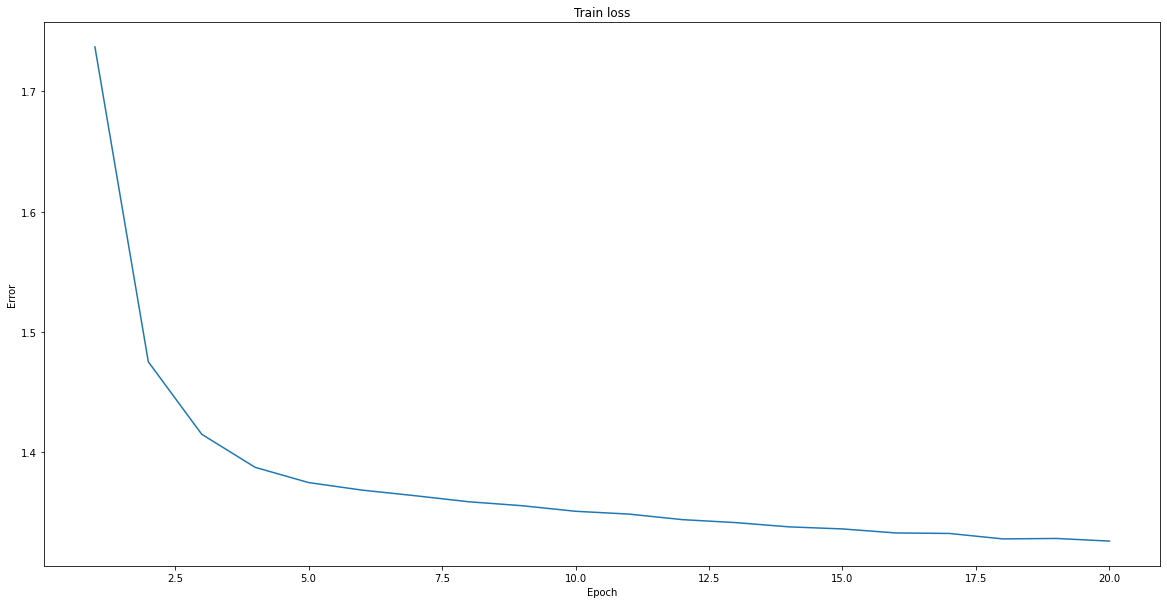

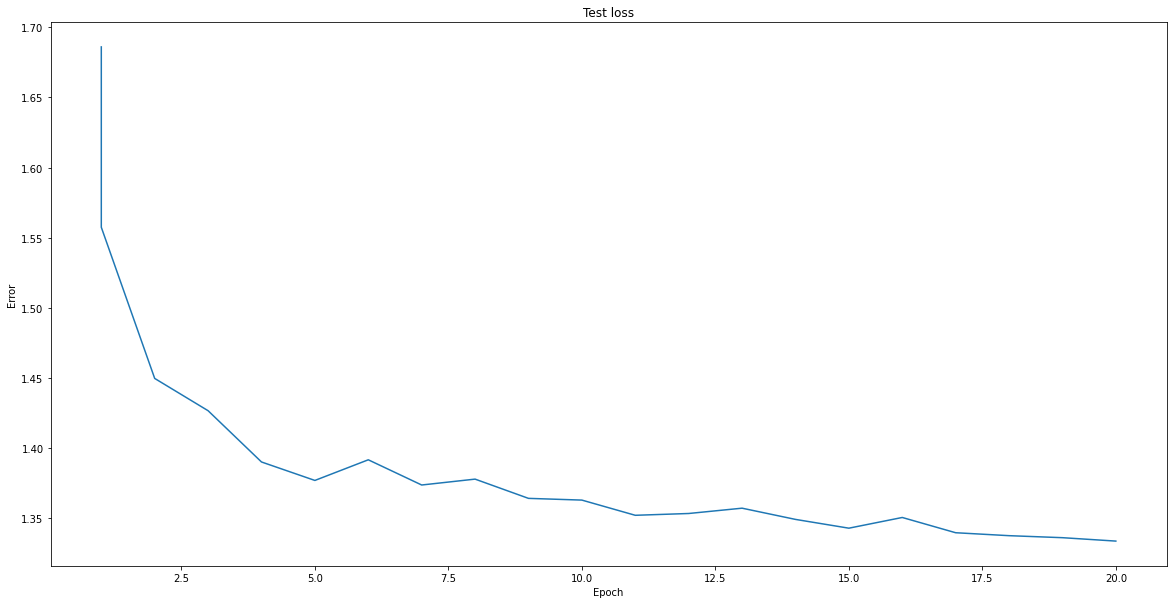

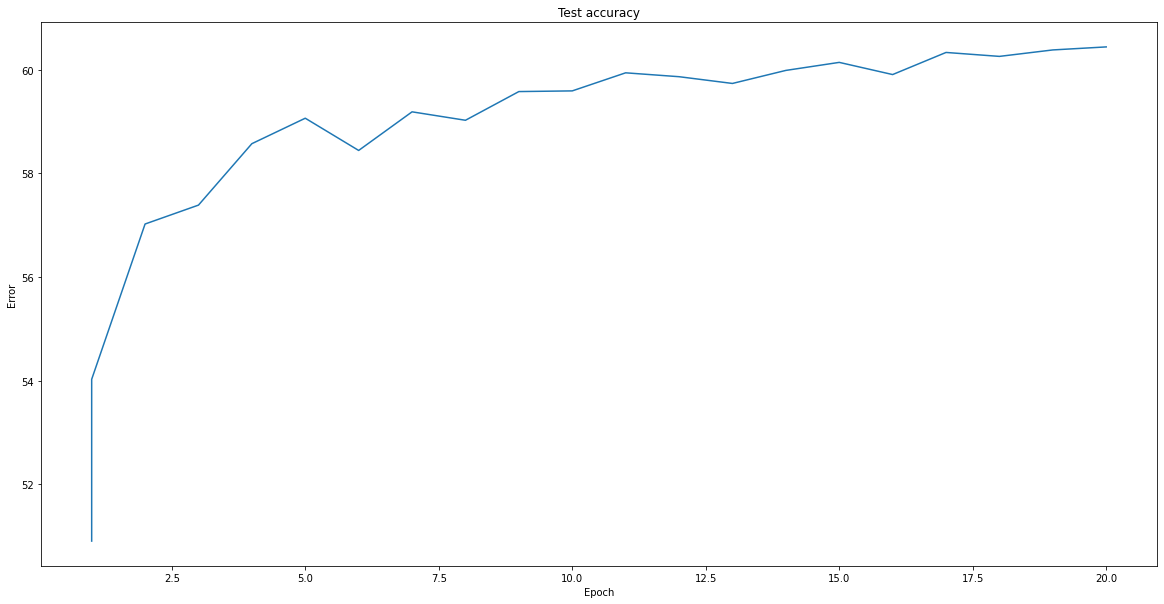

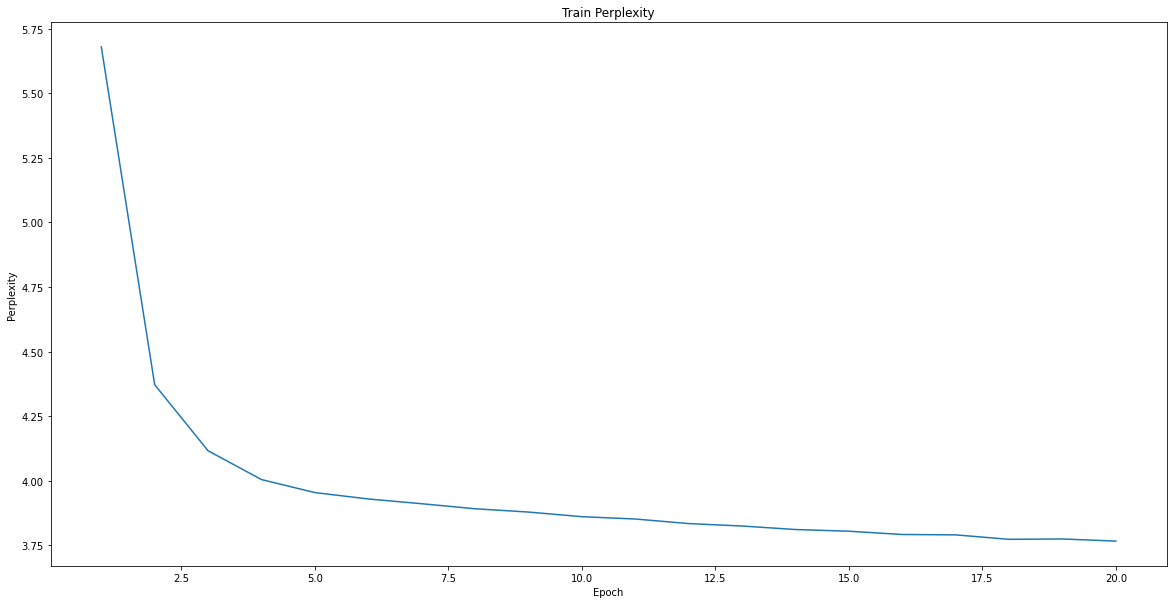

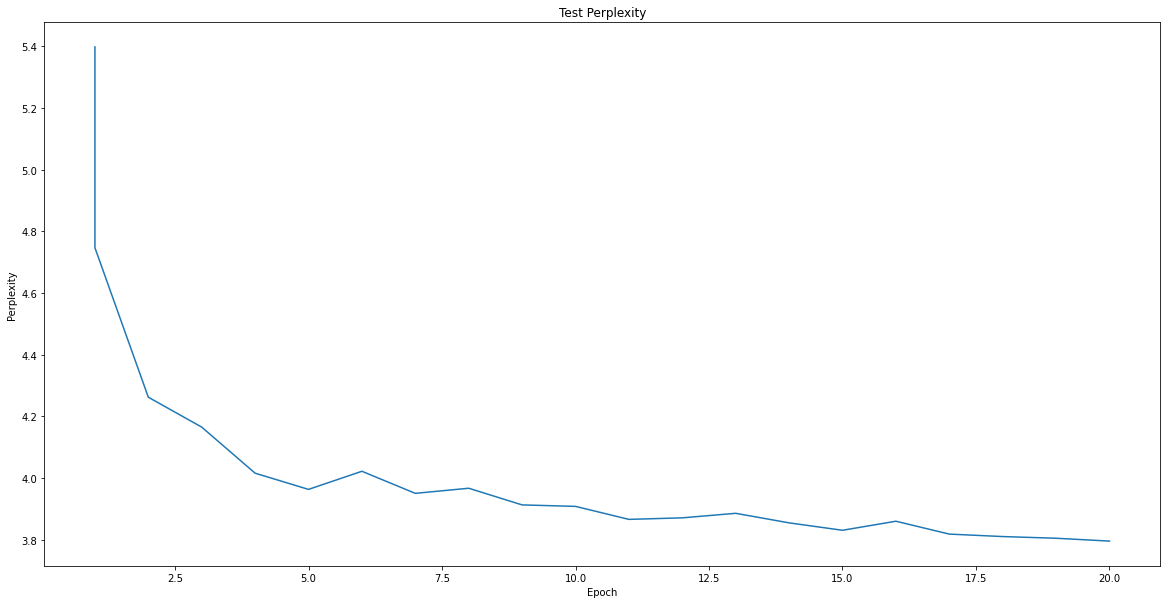

In [ ]:
# 3: LSTM

TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size, device):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1

        self.device = device
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        if hidden_state is None:
          # print("Empty Hidden State")
          hidden_state = (torch.zeros(1, batch_size, self.feature_size).to(device), torch.zeros(1, batch_size, self.feature_size).to(device))
        else:
          pass

        encodeOut = self.encoder(x)
        lstmOut, hidden_state = self.lstm(encodeOut, hidden_state)
        decodeOut = self.decoder(lstmOut)

        return decodeOut, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


import math
def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device):
    outputs = []
    beams = [([], output, hidden, 0)]
    # TODO

    # 1. Initialize the beam list with the single existing empty beam
    # 2. Repeat for the sequence length:
    #     1. For each beam in the beam list:
    #         1. Compute the next distribution over the output space for that state
    #         2. Sample from the distribution with replacement
    #         3. For each sample:
    #             1. Compute its score
    #             2. Record its hidden state and chosen value
    #         4. Add all the samples to the new beam list      
    #      2. Rank the new beam list
    #      3. Throw out all but the top beam_width beams
    #  3. Return the top beam's chosen values.
    beams[0][0].append(output.argmax().item())
    for i in range(0, sequence_length):
        new_beams = []
        for beam in beams:
            # next distribution
            nextInput = torch.tensor([beam[0][len(beam[0]) - 1]], dtype=torch.long).to(device)
            samples, hidden = model.inference(nextInput, beam[2], TEMPERATURE)
            # sample the distr. with replacement
            samples = samples[0]
            for i in range(0, len(samples)):
                sample = samples[i]

                # score compute
                current_prob = sample.item()
                if (current_prob <= 0):
                    current_prob = 0.00001;
                new_beam3 = beam[3] + math.log(current_prob)
                # record hidden state and chosen value
                new_beam2 = (hidden[0].detach().clone(), hidden[1].detach().clone())
                new_beam1 = sample.item()

                new_beam0 = []
                new_beam0.extend(beam[0])
                new_beam0.append(i)

                new_beam = (new_beam0, new_beam1, new_beam2, new_beam3)
                new_beams.append(new_beam)
            # all samples to new beam list
        # rank beam list
        new_beams.sort(key=lambda x:x[3], reverse = True)
        
        # keep only top n beams
        beams = new_beams[:beam_width]
    # top beam chosen value
    outputs = beams[0][0][1:]
    return outputs

def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE, device).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpointslstm')

    train_losses, test_losses, test_accuracies = ([], [], [])

    test_loss, test_accuracy = test(model, device, test_loader)
    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))

            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpointslstm/%03d.pt' % epoch)

            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpointslstm/%03d.pt' % epoch, 0)

        train_perplexity = list(map(lambda epochLoss: (epochLoss[0], math.exp(epochLoss[1])), train_losses))
        test_perplexity = list(map(lambda epochLoss: (epochLoss[0], math.exp(epochLoss[1])), test_losses))

        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexity)
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_perplexity)
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Perplexity')
        return model, vocab, device

final_model, vocab, device = main()

Using device cuda
num workers: 2
Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	,'/mm C)qQNZZC5qI5KKzzNSM9**FCp{qg'/LQC FNDq9eYq{55^{qnZZ{gTItR{vN9gggqNn]vzKiqQ$Mq{Qng9gg.gv**e"zMZ


Input	 said Harry. "Thank goodness," Ginny whispered. They looked at each other; Harry wanted to hug her, 
GT	said Harry. "Thank goodness," Ginny whispered. They looked at each other; Harry wanted to hug her, h
pred	q{QF/qrbPCk:qvpeg$MM{**i""{{{voq5vN$M*,'{I}C)i'qLeeoo]nnz'^qq.qKQKgg XeK)*qZQPCko*Q$AKiq9* gN{{gYSR{


Input	mort. He drew out his wand and compared the lengths. Lucius Malfoy made an involuntary movement; for
GT	ort. He drew out his wand and compared the lengths. Lucius Malfoy made an involuntary movement; for 
pred	PnCJLLr'qq))*q N9gg'{q*F$DqQ$Mq""Pz.C'pq9eYqLlZZXe{7q{No5F{q{Q8kn$om8q'qQ$MMMM*n8N9$CkqP 
'm'N9*Ar*C


Input	ose 

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 1/194 [00:00<00:52,  3.67it/s]

Train Epoch: 0 [0/49664 (0%)]	Loss: 15.337872
1


  1%|          | 2/194 [00:00<00:39,  4.91it/s]

2


  2%|▏         | 3/194 [00:00<00:33,  5.66it/s]

3


  2%|▏         | 4/194 [00:00<00:31,  6.05it/s]

4


  3%|▎         | 5/194 [00:00<00:30,  6.20it/s]

5


  3%|▎         | 6/194 [00:01<00:30,  6.25it/s]

6


  4%|▎         | 7/194 [00:01<00:29,  6.30it/s]

7


  4%|▍         | 8/194 [00:01<00:29,  6.34it/s]

8


  5%|▍         | 9/194 [00:01<00:28,  6.40it/s]

9


  5%|▌         | 10/194 [00:01<00:28,  6.44it/s]

10


  6%|▌         | 11/194 [00:01<00:28,  6.42it/s]

Train Epoch: 0 [2560/49664 (5%)]	Loss: 11.907113
11


  6%|▌         | 12/194 [00:01<00:28,  6.46it/s]

12


  7%|▋         | 13/194 [00:02<00:28,  6.43it/s]

13


  7%|▋         | 14/194 [00:02<00:27,  6.46it/s]

14


  8%|▊         | 15/194 [00:02<00:27,  6.48it/s]

15


  8%|▊         | 16/194 [00:02<00:27,  6.51it/s]

16


  9%|▉         | 17/194 [00:02<00:27,  6.50it/s]

17


  9%|▉         | 18/194 [00:02<00:26,  6.57it/s]

18


 10%|▉         | 19/194 [00:03<00:26,  6.61it/s]

19


 10%|█         | 20/194 [00:03<00:26,  6.55it/s]

20


 11%|█         | 21/194 [00:03<00:26,  6.51it/s]

Train Epoch: 0 [5120/49664 (10%)]	Loss: 6.069085
21


 11%|█▏        | 22/194 [00:03<00:26,  6.40it/s]

22


 12%|█▏        | 23/194 [00:03<00:26,  6.46it/s]

23


 12%|█▏        | 24/194 [00:03<00:26,  6.35it/s]

24


 13%|█▎        | 25/194 [00:03<00:26,  6.46it/s]

25


 13%|█▎        | 26/194 [00:04<00:25,  6.49it/s]

26


 14%|█▍        | 27/194 [00:04<00:25,  6.51it/s]

27


 14%|█▍        | 28/194 [00:04<00:25,  6.44it/s]

28


 15%|█▍        | 29/194 [00:04<00:25,  6.45it/s]

29


 15%|█▌        | 30/194 [00:04<00:25,  6.45it/s]

30


 16%|█▌        | 31/194 [00:04<00:25,  6.49it/s]

Train Epoch: 0 [7680/49664 (15%)]	Loss: 3.879329
31


 16%|█▋        | 32/194 [00:05<00:24,  6.53it/s]

32


 17%|█▋        | 33/194 [00:05<00:24,  6.53it/s]

33


 18%|█▊        | 34/194 [00:05<00:24,  6.56it/s]

34


 18%|█▊        | 35/194 [00:05<00:24,  6.55it/s]

35


 19%|█▊        | 36/194 [00:05<00:24,  6.49it/s]

36


 19%|█▉        | 37/194 [00:05<00:24,  6.47it/s]

37


 20%|█▉        | 38/194 [00:05<00:24,  6.45it/s]

38


 20%|██        | 39/194 [00:06<00:24,  6.42it/s]

39


 21%|██        | 40/194 [00:06<00:23,  6.43it/s]

40


 21%|██        | 41/194 [00:06<00:24,  6.35it/s]

Train Epoch: 0 [10240/49664 (21%)]	Loss: 2.861271
41


 22%|██▏       | 42/194 [00:06<00:23,  6.44it/s]

42


 22%|██▏       | 43/194 [00:06<00:23,  6.52it/s]

43


 23%|██▎       | 44/194 [00:06<00:22,  6.54it/s]

44


 23%|██▎       | 45/194 [00:07<00:22,  6.51it/s]

45


 24%|██▎       | 46/194 [00:07<00:22,  6.51it/s]

46


 24%|██▍       | 47/194 [00:07<00:22,  6.53it/s]

47


 25%|██▍       | 48/194 [00:07<00:22,  6.50it/s]

48


 25%|██▌       | 49/194 [00:07<00:22,  6.45it/s]

49


 26%|██▌       | 50/194 [00:07<00:22,  6.39it/s]

50


 26%|██▋       | 51/194 [00:07<00:22,  6.35it/s]

Train Epoch: 0 [12800/49664 (26%)]	Loss: 2.498019
51


 27%|██▋       | 52/194 [00:08<00:22,  6.39it/s]

52


 27%|██▋       | 53/194 [00:08<00:21,  6.43it/s]

53


 28%|██▊       | 54/194 [00:08<00:21,  6.42it/s]

54


 28%|██▊       | 55/194 [00:08<00:21,  6.43it/s]

55


 29%|██▉       | 56/194 [00:08<00:21,  6.35it/s]

56


 29%|██▉       | 57/194 [00:08<00:21,  6.34it/s]

57


 30%|██▉       | 58/194 [00:09<00:21,  6.32it/s]

58


 30%|███       | 59/194 [00:09<00:21,  6.35it/s]

59


 31%|███       | 60/194 [00:09<00:21,  6.33it/s]

60


 31%|███▏      | 61/194 [00:09<00:20,  6.36it/s]

Train Epoch: 0 [15360/49664 (31%)]	Loss: 3.618136
61


 32%|███▏      | 62/194 [00:09<00:20,  6.45it/s]

62


 32%|███▏      | 63/194 [00:09<00:20,  6.50it/s]

63


 33%|███▎      | 64/194 [00:10<00:20,  6.48it/s]

64


 34%|███▎      | 65/194 [00:10<00:19,  6.50it/s]

65


 34%|███▍      | 66/194 [00:10<00:19,  6.43it/s]

66


 35%|███▍      | 67/194 [00:10<00:19,  6.46it/s]

67


 35%|███▌      | 68/194 [00:10<00:19,  6.46it/s]

68


 36%|███▌      | 69/194 [00:10<00:19,  6.41it/s]

69


 36%|███▌      | 70/194 [00:10<00:19,  6.37it/s]

70


 37%|███▋      | 71/194 [00:11<00:19,  6.39it/s]

Train Epoch: 0 [17920/49664 (36%)]	Loss: 3.514781
71


 37%|███▋      | 72/194 [00:11<00:19,  6.40it/s]

72


 38%|███▊      | 73/194 [00:11<00:18,  6.44it/s]

73


 38%|███▊      | 74/194 [00:11<00:18,  6.43it/s]

74


 39%|███▊      | 75/194 [00:11<00:18,  6.47it/s]

75


 39%|███▉      | 76/194 [00:11<00:18,  6.48it/s]

76


 40%|███▉      | 77/194 [00:12<00:18,  6.46it/s]

77


 40%|████      | 78/194 [00:12<00:18,  6.43it/s]

78


 41%|████      | 79/194 [00:12<00:17,  6.45it/s]

79


 41%|████      | 80/194 [00:12<00:17,  6.48it/s]

80


 42%|████▏     | 81/194 [00:12<00:17,  6.48it/s]

Train Epoch: 0 [20480/49664 (41%)]	Loss: 2.652342
81


 42%|████▏     | 82/194 [00:12<00:17,  6.34it/s]

82


 43%|████▎     | 83/194 [00:12<00:17,  6.28it/s]

83


 43%|████▎     | 84/194 [00:13<00:17,  6.32it/s]

84


 44%|████▍     | 85/194 [00:13<00:17,  6.39it/s]

85


 44%|████▍     | 86/194 [00:13<00:16,  6.38it/s]

86


 45%|████▍     | 87/194 [00:13<00:16,  6.34it/s]

87


 45%|████▌     | 88/194 [00:13<00:16,  6.34it/s]

88


 46%|████▌     | 89/194 [00:13<00:16,  6.40it/s]

89


 46%|████▋     | 90/194 [00:14<00:16,  6.48it/s]

90


 47%|████▋     | 91/194 [00:14<00:15,  6.50it/s]

Train Epoch: 0 [23040/49664 (46%)]	Loss: 2.220424
91


 47%|████▋     | 92/194 [00:14<00:15,  6.54it/s]

92


 48%|████▊     | 93/194 [00:14<00:15,  6.54it/s]

93


 48%|████▊     | 94/194 [00:14<00:15,  6.53it/s]

94


 49%|████▉     | 95/194 [00:14<00:15,  6.47it/s]

95


 49%|████▉     | 96/194 [00:14<00:15,  6.36it/s]

96


 50%|█████     | 97/194 [00:15<00:15,  6.32it/s]

97


 51%|█████     | 98/194 [00:15<00:14,  6.42it/s]

98


 51%|█████     | 99/194 [00:15<00:14,  6.40it/s]

99


 52%|█████▏    | 100/194 [00:15<00:14,  6.42it/s]

100


 52%|█████▏    | 101/194 [00:15<00:14,  6.38it/s]

Train Epoch: 0 [25600/49664 (52%)]	Loss: 2.086013
101


 53%|█████▎    | 102/194 [00:15<00:14,  6.45it/s]

102


 53%|█████▎    | 103/194 [00:16<00:14,  6.46it/s]

103


 54%|█████▎    | 104/194 [00:16<00:14,  6.37it/s]

104


 54%|█████▍    | 105/194 [00:16<00:13,  6.42it/s]

105


 55%|█████▍    | 106/194 [00:16<00:13,  6.33it/s]

106


 55%|█████▌    | 107/194 [00:16<00:13,  6.39it/s]

107


 56%|█████▌    | 108/194 [00:16<00:13,  6.35it/s]

108


 56%|█████▌    | 109/194 [00:17<00:13,  6.32it/s]

109


 57%|█████▋    | 110/194 [00:17<00:13,  6.42it/s]

110


 57%|█████▋    | 111/194 [00:17<00:12,  6.40it/s]

Train Epoch: 0 [28160/49664 (57%)]	Loss: 2.009269
111


 58%|█████▊    | 112/194 [00:17<00:12,  6.47it/s]

112


 58%|█████▊    | 113/194 [00:17<00:12,  6.43it/s]

113


 59%|█████▉    | 114/194 [00:17<00:12,  6.45it/s]

114


 59%|█████▉    | 115/194 [00:17<00:12,  6.32it/s]

115


 60%|█████▉    | 116/194 [00:18<00:12,  6.40it/s]

116


 60%|██████    | 117/194 [00:18<00:12,  6.30it/s]

117


 61%|██████    | 118/194 [00:18<00:11,  6.34it/s]

118


 61%|██████▏   | 119/194 [00:18<00:11,  6.45it/s]

119


 62%|██████▏   | 120/194 [00:18<00:11,  6.46it/s]

120


 62%|██████▏   | 121/194 [00:18<00:11,  6.42it/s]

Train Epoch: 0 [30720/49664 (62%)]	Loss: 2.276851
121


 63%|██████▎   | 122/194 [00:19<00:11,  6.39it/s]

122


 63%|██████▎   | 123/194 [00:19<00:10,  6.47it/s]

123


 64%|██████▍   | 124/194 [00:19<00:10,  6.38it/s]

124


 64%|██████▍   | 125/194 [00:19<00:10,  6.37it/s]

125


 65%|██████▍   | 126/194 [00:19<00:10,  6.34it/s]

126


 65%|██████▌   | 127/194 [00:19<00:10,  6.42it/s]

127


 66%|██████▌   | 128/194 [00:19<00:10,  6.44it/s]

128


 66%|██████▋   | 129/194 [00:20<00:10,  6.45it/s]

129


 67%|██████▋   | 130/194 [00:20<00:09,  6.46it/s]

130


 68%|██████▊   | 131/194 [00:20<00:09,  6.48it/s]

Train Epoch: 0 [33280/49664 (67%)]	Loss: 2.132559
131


 68%|██████▊   | 132/194 [00:20<00:09,  6.47it/s]

132


 69%|██████▊   | 133/194 [00:20<00:09,  6.39it/s]

133


 69%|██████▉   | 134/194 [00:20<00:09,  6.40it/s]

134


 70%|██████▉   | 135/194 [00:21<00:09,  6.44it/s]

135


 70%|███████   | 136/194 [00:21<00:09,  6.28it/s]

136


 71%|███████   | 137/194 [00:21<00:08,  6.36it/s]

137


 71%|███████   | 138/194 [00:21<00:08,  6.39it/s]

138


 72%|███████▏  | 139/194 [00:21<00:08,  6.41it/s]

139


 72%|███████▏  | 140/194 [00:21<00:08,  6.37it/s]

140


 73%|███████▎  | 141/194 [00:22<00:08,  6.40it/s]

Train Epoch: 0 [35840/49664 (72%)]	Loss: 1.969893
141


 73%|███████▎  | 142/194 [00:22<00:08,  6.24it/s]

142


 74%|███████▎  | 143/194 [00:22<00:08,  6.25it/s]

143


 74%|███████▍  | 144/194 [00:22<00:07,  6.30it/s]

144


 75%|███████▍  | 145/194 [00:22<00:07,  6.30it/s]

145


 75%|███████▌  | 146/194 [00:22<00:07,  6.28it/s]

146


 76%|███████▌  | 147/194 [00:22<00:07,  6.27it/s]

147


 76%|███████▋  | 148/194 [00:23<00:07,  6.31it/s]

148


 77%|███████▋  | 149/194 [00:23<00:07,  6.30it/s]

149


 77%|███████▋  | 150/194 [00:23<00:07,  6.27it/s]

150


 78%|███████▊  | 151/194 [00:23<00:06,  6.32it/s]

Train Epoch: 0 [38400/49664 (77%)]	Loss: 2.074341
151


 78%|███████▊  | 152/194 [00:23<00:06,  6.35it/s]

152


 79%|███████▉  | 153/194 [00:23<00:06,  6.40it/s]

153


 79%|███████▉  | 154/194 [00:24<00:06,  6.33it/s]

154


 80%|███████▉  | 155/194 [00:24<00:06,  6.26it/s]

155


 80%|████████  | 156/194 [00:24<00:06,  6.24it/s]

156


 81%|████████  | 157/194 [00:24<00:05,  6.28it/s]

157


 81%|████████▏ | 158/194 [00:24<00:05,  6.31it/s]

158


 82%|████████▏ | 159/194 [00:24<00:05,  6.27it/s]

159


 82%|████████▏ | 160/194 [00:25<00:05,  6.32it/s]

160


 83%|████████▎ | 161/194 [00:25<00:05,  6.22it/s]

Train Epoch: 0 [40960/49664 (82%)]	Loss: 1.997796
161


 84%|████████▎ | 162/194 [00:25<00:05,  6.27it/s]

162


 84%|████████▍ | 163/194 [00:25<00:04,  6.36it/s]

163


 85%|████████▍ | 164/194 [00:25<00:04,  6.38it/s]

164


 85%|████████▌ | 165/194 [00:25<00:04,  6.41it/s]

165


 86%|████████▌ | 166/194 [00:25<00:04,  6.40it/s]

166


 86%|████████▌ | 167/194 [00:26<00:04,  6.33it/s]

167


 87%|████████▋ | 168/194 [00:26<00:04,  6.31it/s]

168


 87%|████████▋ | 169/194 [00:26<00:03,  6.35it/s]

169


 88%|████████▊ | 170/194 [00:26<00:03,  6.31it/s]

170


 88%|████████▊ | 171/194 [00:26<00:03,  6.30it/s]

Train Epoch: 0 [43520/49664 (88%)]	Loss: 1.939815
171


 89%|████████▊ | 172/194 [00:26<00:03,  6.36it/s]

172


 89%|████████▉ | 173/194 [00:27<00:03,  6.34it/s]

173


 90%|████████▉ | 174/194 [00:27<00:03,  6.32it/s]

174


 90%|█████████ | 175/194 [00:27<00:03,  6.24it/s]

175


 91%|█████████ | 176/194 [00:27<00:02,  6.26it/s]

176


 91%|█████████ | 177/194 [00:27<00:02,  6.33it/s]

177


 92%|█████████▏| 178/194 [00:27<00:02,  6.29it/s]

178


 92%|█████████▏| 179/194 [00:28<00:02,  6.20it/s]

179


 93%|█████████▎| 180/194 [00:28<00:02,  6.26it/s]

180


 93%|█████████▎| 181/194 [00:28<00:02,  6.20it/s]

Train Epoch: 0 [46080/49664 (93%)]	Loss: 2.274491
181


 94%|█████████▍| 182/194 [00:28<00:01,  6.25it/s]

182


 94%|█████████▍| 183/194 [00:28<00:01,  6.33it/s]

183


 95%|█████████▍| 184/194 [00:28<00:01,  6.19it/s]

184


 95%|█████████▌| 185/194 [00:29<00:01,  6.21it/s]

185


 96%|█████████▌| 186/194 [00:29<00:01,  6.18it/s]

186


 96%|█████████▋| 187/194 [00:29<00:01,  6.33it/s]

187


 97%|█████████▋| 188/194 [00:29<00:00,  6.40it/s]

188


 97%|█████████▋| 189/194 [00:29<00:00,  6.41it/s]

189


 98%|█████████▊| 190/194 [00:29<00:00,  6.33it/s]

190


 98%|█████████▊| 191/194 [00:29<00:00,  6.34it/s]

Train Epoch: 0 [48640/49664 (98%)]	Loss: 2.286633
191


 99%|█████████▉| 192/194 [00:30<00:00,  6.25it/s]

192


 99%|█████████▉| 193/194 [00:30<00:00,  6.31it/s]

193


100%|██████████| 194/194 [00:30<00:00,  6.36it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en fese h tos ehaealtng to ert  tem tneunt the ftde  wf tooupe"sut ia hratg   a   toietoet iet e?ng 


Input	 and Madame Delacour; you know they're arriving at eleven tomorrow morning." But as it turned out, t
GT	and Madame Delacour; you know they're arriving at eleven tomorrow morning." But as it turned out, th
pred	snd Halam  Maalrenls hou tnow toe  se hneyeeog t  txlses th  rt weteve eg   "ut i  tt three  tut "ah


Input	 his forehead. He crawled out of the pond and stumbled toward the great dark mass on the ground that
GT	his forehead. He crawled out of the pond and stumbled toward the great dark mass on the ground that 
pred	sam fer  ,rd  "e hlecee  aut of the sost tnd tporpled oo ert toe foe t oowk fin  fn the foeunt toet 


Input	et, but again, the scars on the back 

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 2/194 [00:00<00:43,  4.44it/s]

Train Epoch: 1 [0/49664 (0%)]	Loss: 2.011402
1
2


  2%|▏         | 4/194 [00:00<00:35,  5.34it/s]

3
4


  3%|▎         | 6/194 [00:01<00:33,  5.62it/s]

5
6


  4%|▍         | 8/194 [00:01<00:32,  5.79it/s]

7
8


  5%|▌         | 10/194 [00:01<00:31,  5.93it/s]

9
10


  6%|▌         | 12/194 [00:02<00:30,  5.96it/s]

Train Epoch: 1 [2560/49664 (5%)]	Loss: 1.893779
11
12


  7%|▋         | 14/194 [00:02<00:30,  5.98it/s]

13
14


  8%|▊         | 16/194 [00:02<00:29,  5.96it/s]

15
16


  9%|▉         | 18/194 [00:03<00:29,  6.04it/s]

17
18


 10%|█         | 20/194 [00:03<00:28,  6.16it/s]

19
20


 11%|█▏        | 22/194 [00:03<00:27,  6.23it/s]

Train Epoch: 1 [5120/49664 (10%)]	Loss: 1.811820
21
22


 12%|█▏        | 24/194 [00:04<00:27,  6.20it/s]

23
24


 13%|█▎        | 26/194 [00:04<00:26,  6.36it/s]

25
26


 14%|█▍        | 28/194 [00:04<00:25,  6.43it/s]

27
28


 15%|█▌        | 30/194 [00:05<00:26,  6.25it/s]

29
30


 16%|█▋        | 32/194 [00:05<00:26,  6.22it/s]

Train Epoch: 1 [7680/49664 (15%)]	Loss: 1.756457
31
32


 18%|█▊        | 34/194 [00:05<00:25,  6.25it/s]

33
34


 19%|█▊        | 36/194 [00:06<00:25,  6.26it/s]

35
36


 20%|█▉        | 38/194 [00:06<00:24,  6.29it/s]

37
38


 21%|██        | 40/194 [00:06<00:24,  6.39it/s]

39
40


 22%|██▏       | 42/194 [00:06<00:24,  6.31it/s]

Train Epoch: 1 [10240/49664 (21%)]	Loss: 1.739711
41
42


 23%|██▎       | 44/194 [00:07<00:23,  6.36it/s]

43
44


 24%|██▎       | 46/194 [00:07<00:23,  6.38it/s]

45
46


 25%|██▍       | 48/194 [00:07<00:23,  6.33it/s]

47
48


 26%|██▌       | 50/194 [00:08<00:22,  6.27it/s]

49
50


 27%|██▋       | 52/194 [00:08<00:22,  6.23it/s]

Train Epoch: 1 [12800/49664 (26%)]	Loss: 2.119929
51
52


 28%|██▊       | 54/194 [00:08<00:21,  6.38it/s]

53
54


 29%|██▉       | 56/194 [00:09<00:21,  6.39it/s]

55
56


 30%|██▉       | 58/194 [00:09<00:21,  6.27it/s]

57
58


 31%|███       | 60/194 [00:09<00:21,  6.26it/s]

59
60


 32%|███▏      | 62/194 [00:10<00:21,  6.28it/s]

Train Epoch: 1 [15360/49664 (31%)]	Loss: 1.993372
61
62


 33%|███▎      | 64/194 [00:10<00:20,  6.31it/s]

63
64


 34%|███▍      | 66/194 [00:10<00:20,  6.37it/s]

65
66


 35%|███▌      | 68/194 [00:11<00:19,  6.39it/s]

67
68


 36%|███▌      | 70/194 [00:11<00:19,  6.30it/s]

69
70


 37%|███▋      | 72/194 [00:11<00:19,  6.36it/s]

Train Epoch: 1 [17920/49664 (36%)]	Loss: 1.875876
71
72


 38%|███▊      | 74/194 [00:12<00:18,  6.36it/s]

73
74


 39%|███▉      | 76/194 [00:12<00:18,  6.33it/s]

75
76


 40%|████      | 78/194 [00:12<00:18,  6.22it/s]

77
78


 41%|████      | 80/194 [00:12<00:18,  6.33it/s]

79
80


 42%|████▏     | 82/194 [00:13<00:17,  6.33it/s]

Train Epoch: 1 [20480/49664 (41%)]	Loss: 1.881230
81
82


 43%|████▎     | 84/194 [00:13<00:17,  6.37it/s]

83
84


 44%|████▍     | 86/194 [00:13<00:17,  6.34it/s]

85
86


 45%|████▌     | 88/194 [00:14<00:16,  6.39it/s]

87
88


 46%|████▋     | 90/194 [00:14<00:16,  6.40it/s]

89
90


 47%|████▋     | 92/194 [00:14<00:16,  6.24it/s]

Train Epoch: 1 [23040/49664 (46%)]	Loss: 1.808060
91
92


 48%|████▊     | 94/194 [00:15<00:16,  6.24it/s]

93
94


 49%|████▉     | 96/194 [00:15<00:15,  6.20it/s]

95
96


 51%|█████     | 98/194 [00:15<00:15,  6.26it/s]

97
98


 52%|█████▏    | 100/194 [00:16<00:15,  6.18it/s]

99
100


 53%|█████▎    | 102/194 [00:16<00:14,  6.25it/s]

Train Epoch: 1 [25600/49664 (52%)]	Loss: 1.728863
101
102


 54%|█████▎    | 104/194 [00:16<00:14,  6.17it/s]

103
104


 55%|█████▍    | 106/194 [00:17<00:14,  6.22it/s]

105
106


 56%|█████▌    | 108/194 [00:17<00:13,  6.33it/s]

107
108


 57%|█████▋    | 110/194 [00:17<00:13,  6.28it/s]

109
110


 58%|█████▊    | 112/194 [00:18<00:13,  6.24it/s]

Train Epoch: 1 [28160/49664 (57%)]	Loss: 1.855214
111
112


 59%|█████▉    | 114/194 [00:18<00:12,  6.25it/s]

113
114


 60%|█████▉    | 116/194 [00:18<00:12,  6.18it/s]

115
116


 61%|██████    | 118/194 [00:19<00:12,  6.31it/s]

117
118


 62%|██████▏   | 120/194 [00:19<00:11,  6.29it/s]

119
120


 63%|██████▎   | 122/194 [00:19<00:11,  6.35it/s]

Train Epoch: 1 [30720/49664 (62%)]	Loss: 1.774219
121
122


 64%|██████▍   | 124/194 [00:19<00:11,  6.36it/s]

123
124


 65%|██████▍   | 126/194 [00:20<00:10,  6.35it/s]

125
126


 66%|██████▌   | 128/194 [00:20<00:10,  6.32it/s]

127
128


 67%|██████▋   | 130/194 [00:20<00:10,  6.32it/s]

129
130


 68%|██████▊   | 132/194 [00:21<00:09,  6.43it/s]

Train Epoch: 1 [33280/49664 (67%)]	Loss: 1.800041
131
132


 69%|██████▉   | 134/194 [00:21<00:09,  6.43it/s]

133
134


 70%|███████   | 136/194 [00:21<00:09,  6.34it/s]

135
136


 71%|███████   | 138/194 [00:22<00:08,  6.29it/s]

137
138


 72%|███████▏  | 140/194 [00:22<00:08,  6.29it/s]

139
140


 73%|███████▎  | 142/194 [00:22<00:08,  6.16it/s]

Train Epoch: 1 [35840/49664 (72%)]	Loss: 1.748122
141
142


 74%|███████▍  | 144/194 [00:23<00:08,  6.22it/s]

143
144


 75%|███████▌  | 146/194 [00:23<00:07,  6.28it/s]

145
146


 76%|███████▋  | 148/194 [00:23<00:07,  6.28it/s]

147
148


 77%|███████▋  | 150/194 [00:24<00:06,  6.32it/s]

149
150


 78%|███████▊  | 152/194 [00:24<00:06,  6.38it/s]

Train Epoch: 1 [38400/49664 (77%)]	Loss: 1.726258
151
152


 79%|███████▉  | 154/194 [00:24<00:06,  6.30it/s]

153
154


 80%|████████  | 156/194 [00:25<00:06,  6.29it/s]

155
156


 81%|████████▏ | 158/194 [00:25<00:05,  6.21it/s]

157
158


 82%|████████▏ | 160/194 [00:25<00:05,  6.22it/s]

159
160


 84%|████████▎ | 162/194 [00:26<00:05,  6.29it/s]

Train Epoch: 1 [40960/49664 (82%)]	Loss: 1.702617
161
162


 85%|████████▍ | 164/194 [00:26<00:04,  6.24it/s]

163
164


 86%|████████▌ | 166/194 [00:26<00:04,  6.26it/s]

165
166


 87%|████████▋ | 168/194 [00:26<00:04,  6.35it/s]

167
168


 88%|████████▊ | 170/194 [00:27<00:03,  6.35it/s]

169
170


 89%|████████▊ | 172/194 [00:27<00:03,  6.30it/s]

Train Epoch: 1 [43520/49664 (88%)]	Loss: 1.637597
171
172


 90%|████████▉ | 174/194 [00:27<00:03,  6.36it/s]

173
174


 91%|█████████ | 176/194 [00:28<00:02,  6.10it/s]

175
176


 92%|█████████▏| 178/194 [00:28<00:02,  6.27it/s]

177
178


 93%|█████████▎| 180/194 [00:28<00:02,  6.22it/s]

179
180


 94%|█████████▍| 182/194 [00:29<00:01,  6.10it/s]

Train Epoch: 1 [46080/49664 (93%)]	Loss: 1.678502
181
182


 95%|█████████▍| 184/194 [00:29<00:01,  6.27it/s]

183
184


 96%|█████████▌| 186/194 [00:29<00:01,  6.22it/s]

185
186


 97%|█████████▋| 188/194 [00:30<00:00,  6.08it/s]

187
188


 98%|█████████▊| 190/194 [00:30<00:00,  6.14it/s]

189
190


 99%|█████████▉| 192/194 [00:30<00:00,  6.25it/s]

Train Epoch: 1 [48640/49664 (98%)]	Loss: 1.719192
191
192


100%|██████████| 194/194 [00:31<00:00,  6.23it/s]


193
Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	an iire i tirmnoaaaatng ih ard  oas tnound thammtle. of toauie tut tardaaneed ond tow that titie?ng 


Input	lohov's forehead and said, "Obliviate." At once, Dolohov's eyes became unfocused and dreamy. "Brilli
GT	ohov's forehead and said, "Obliviate." At once, Dolohov's eyes became unfocused and dreamy. "Brillia
pred	aoares for  ard.ond toyd, " neunenlid  "n tfee. tubdrales fyes oeeaue ipiirule  tnd tiiami  "Iuigl n


Input	from his jeans pocket. "This." She had to look at Ron to see what he was showing them. "The Delumina
GT	rom his jeans pocket. "This." She had to look at Ron to see what he was showing them. "The Deluminat
pred	 om tas fuar.etriked. "Ihas   "ie mad so book ot ton.ir teemtiat iarwas ooeulng ioem  "Ihaymaalsbngt


Input	mfortably crowded. "I'll pack the

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 2/194 [00:00<00:44,  4.32it/s]

Train Epoch: 2 [0/49664 (0%)]	Loss: 1.758201
1
2


  2%|▏         | 4/194 [00:00<00:36,  5.24it/s]

3
4


  3%|▎         | 6/194 [00:01<00:34,  5.47it/s]

5
6


  4%|▍         | 8/194 [00:01<00:32,  5.73it/s]

7
8


  5%|▌         | 10/194 [00:01<00:31,  5.81it/s]

9
10


  6%|▌         | 12/194 [00:02<00:30,  5.95it/s]

Train Epoch: 2 [2560/49664 (5%)]	Loss: 1.653399
11
12


  7%|▋         | 14/194 [00:02<00:29,  6.06it/s]

13
14


  8%|▊         | 16/194 [00:02<00:28,  6.17it/s]

15
16


  9%|▉         | 18/194 [00:03<00:28,  6.21it/s]

17
18


 10%|█         | 20/194 [00:03<00:27,  6.34it/s]

19
20


 11%|█▏        | 22/194 [00:03<00:27,  6.29it/s]

Train Epoch: 2 [5120/49664 (10%)]	Loss: 1.645992
21
22


 12%|█▏        | 24/194 [00:04<00:26,  6.31it/s]

23
24


 13%|█▎        | 26/194 [00:04<00:26,  6.25it/s]

25
26


 14%|█▍        | 28/194 [00:04<00:26,  6.34it/s]

27
28


 15%|█▌        | 30/194 [00:05<00:26,  6.17it/s]

29
30


 16%|█▋        | 32/194 [00:05<00:26,  6.20it/s]

Train Epoch: 2 [7680/49664 (15%)]	Loss: 1.631187
31
32


 18%|█▊        | 34/194 [00:05<00:25,  6.22it/s]

33
34


 19%|█▊        | 36/194 [00:06<00:25,  6.26it/s]

35
36


 20%|█▉        | 38/194 [00:06<00:24,  6.28it/s]

37
38


 21%|██        | 40/194 [00:06<00:24,  6.32it/s]

39
40


 22%|██▏       | 42/194 [00:06<00:24,  6.30it/s]

Train Epoch: 2 [10240/49664 (21%)]	Loss: 1.700597
41
42


 23%|██▎       | 44/194 [00:07<00:23,  6.33it/s]

43
44


 24%|██▎       | 46/194 [00:07<00:23,  6.18it/s]

45
46


 25%|██▍       | 48/194 [00:07<00:24,  6.05it/s]

47
48


 26%|██▌       | 50/194 [00:08<00:23,  6.20it/s]

49
50


 27%|██▋       | 52/194 [00:08<00:22,  6.32it/s]

Train Epoch: 2 [12800/49664 (26%)]	Loss: 1.695315
51
52


 28%|██▊       | 54/194 [00:08<00:22,  6.23it/s]

53
54


 29%|██▉       | 56/194 [00:09<00:21,  6.31it/s]

55
56


 30%|██▉       | 58/194 [00:09<00:21,  6.30it/s]

57
58


 31%|███       | 60/194 [00:09<00:21,  6.37it/s]

59
60


 32%|███▏      | 62/194 [00:10<00:20,  6.33it/s]

Train Epoch: 2 [15360/49664 (31%)]	Loss: 1.622468
61
62


 33%|███▎      | 64/194 [00:10<00:20,  6.36it/s]

63
64


 34%|███▍      | 66/194 [00:10<00:20,  6.17it/s]

65
66


 35%|███▌      | 68/194 [00:11<00:20,  6.28it/s]

67
68


 36%|███▌      | 70/194 [00:11<00:19,  6.37it/s]

69
70


 37%|███▋      | 72/194 [00:11<00:19,  6.30it/s]

Train Epoch: 2 [17920/49664 (36%)]	Loss: 1.612230
71
72


 38%|███▊      | 74/194 [00:12<00:18,  6.36it/s]

73
74


 39%|███▉      | 76/194 [00:12<00:18,  6.25it/s]

75
76


 40%|████      | 78/194 [00:12<00:18,  6.34it/s]

77
78


 41%|████      | 80/194 [00:13<00:18,  6.15it/s]

79
80


 42%|████▏     | 82/194 [00:13<00:18,  6.15it/s]

Train Epoch: 2 [20480/49664 (41%)]	Loss: 1.609416
81
82


 43%|████▎     | 84/194 [00:13<00:17,  6.15it/s]

83
84


 44%|████▍     | 86/194 [00:13<00:17,  6.19it/s]

85
86


 45%|████▌     | 88/194 [00:14<00:17,  6.14it/s]

87
88


 46%|████▋     | 90/194 [00:14<00:16,  6.29it/s]

89
90


 47%|████▋     | 92/194 [00:14<00:16,  6.30it/s]

Train Epoch: 2 [23040/49664 (46%)]	Loss: 1.609205
91
92


 48%|████▊     | 94/194 [00:15<00:15,  6.27it/s]

93
94


 49%|████▉     | 96/194 [00:15<00:15,  6.33it/s]

95
96


 51%|█████     | 98/194 [00:15<00:15,  6.30it/s]

97
98


 52%|█████▏    | 100/194 [00:16<00:14,  6.28it/s]

99
100


 53%|█████▎    | 102/194 [00:16<00:14,  6.27it/s]

Train Epoch: 2 [25600/49664 (52%)]	Loss: 1.629730
101
102


 54%|█████▎    | 104/194 [00:16<00:14,  6.27it/s]

103
104


 55%|█████▍    | 106/194 [00:17<00:13,  6.37it/s]

105
106


 56%|█████▌    | 108/194 [00:17<00:13,  6.37it/s]

107
108


 57%|█████▋    | 110/194 [00:17<00:13,  6.17it/s]

109
110


 58%|█████▊    | 112/194 [00:18<00:13,  6.17it/s]

Train Epoch: 2 [28160/49664 (57%)]	Loss: 1.601080
111
112


 59%|█████▉    | 114/194 [00:18<00:12,  6.18it/s]

113
114


 60%|█████▉    | 116/194 [00:18<00:12,  6.15it/s]

115
116


 61%|██████    | 118/194 [00:19<00:12,  6.14it/s]

117
118


 62%|██████▏   | 120/194 [00:19<00:11,  6.21it/s]

119
120


 63%|██████▎   | 122/194 [00:19<00:11,  6.22it/s]

Train Epoch: 2 [30720/49664 (62%)]	Loss: 1.635191
121
122


 64%|██████▍   | 124/194 [00:20<00:11,  6.24it/s]

123
124


 65%|██████▍   | 126/194 [00:20<00:10,  6.29it/s]

125
126


 66%|██████▌   | 128/194 [00:20<00:10,  6.25it/s]

127
128


 67%|██████▋   | 130/194 [00:21<00:10,  6.30it/s]

129
130


 68%|██████▊   | 132/194 [00:21<00:09,  6.25it/s]

Train Epoch: 2 [33280/49664 (67%)]	Loss: 1.647909
131
132


 69%|██████▉   | 134/194 [00:21<00:09,  6.08it/s]

133
134


 70%|███████   | 136/194 [00:22<00:09,  6.22it/s]

135
136


 71%|███████   | 138/194 [00:22<00:08,  6.23it/s]

137
138


 72%|███████▏  | 140/194 [00:22<00:08,  6.23it/s]

139
140


 73%|███████▎  | 142/194 [00:22<00:08,  6.17it/s]

Train Epoch: 2 [35840/49664 (72%)]	Loss: 1.617501
141
142


 74%|███████▍  | 144/194 [00:23<00:07,  6.31it/s]

143
144


 75%|███████▌  | 146/194 [00:23<00:07,  6.24it/s]

145
146


 76%|███████▋  | 148/194 [00:23<00:07,  6.23it/s]

147
148


 77%|███████▋  | 150/194 [00:24<00:06,  6.33it/s]

149
150


 78%|███████▊  | 152/194 [00:24<00:06,  6.17it/s]

Train Epoch: 2 [38400/49664 (77%)]	Loss: 1.569266
151
152


 79%|███████▉  | 154/194 [00:24<00:06,  6.17it/s]

153
154


 80%|████████  | 156/194 [00:25<00:06,  6.18it/s]

155
156


 81%|████████▏ | 158/194 [00:25<00:05,  6.27it/s]

157
158


 82%|████████▏ | 160/194 [00:25<00:05,  6.28it/s]

159
160


 84%|████████▎ | 162/194 [00:26<00:05,  6.15it/s]

Train Epoch: 2 [40960/49664 (82%)]	Loss: 1.641386
161
162


 85%|████████▍ | 164/194 [00:26<00:04,  6.13it/s]

163
164


 86%|████████▌ | 166/194 [00:26<00:04,  6.27it/s]

165
166


 87%|████████▋ | 168/194 [00:27<00:04,  6.17it/s]

167
168


 88%|████████▊ | 170/194 [00:27<00:03,  6.26it/s]

169
170


 89%|████████▊ | 172/194 [00:27<00:03,  6.14it/s]

Train Epoch: 2 [43520/49664 (88%)]	Loss: 1.591115
171
172


 90%|████████▉ | 174/194 [00:28<00:03,  6.19it/s]

173
174


 91%|█████████ | 176/194 [00:28<00:02,  6.28it/s]

175
176


 92%|█████████▏| 178/194 [00:28<00:02,  6.24it/s]

177
178


 93%|█████████▎| 180/194 [00:29<00:02,  6.16it/s]

179
180


 94%|█████████▍| 182/194 [00:29<00:01,  6.22it/s]

Train Epoch: 2 [46080/49664 (93%)]	Loss: 1.543598
181
182


 95%|█████████▍| 184/194 [00:29<00:01,  6.24it/s]

183
184


 96%|█████████▌| 186/194 [00:30<00:01,  6.29it/s]

185
186


 97%|█████████▋| 188/194 [00:30<00:00,  6.24it/s]

187
188


 98%|█████████▊| 190/194 [00:30<00:00,  6.34it/s]

189
190


 99%|█████████▉| 192/194 [00:30<00:00,  6.30it/s]

Train Epoch: 2 [48640/49664 (98%)]	Loss: 1.563529
191
192


100%|██████████| 194/194 [00:31<00:00,  6.19it/s]

193


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	es teme t  ireebooattng to ard  tom t ound the ctde .of tooui  but te woonk d o d waw thet wot e-ng 


Input	readful scream from overhead. Wormtail's eyes rolled upward in his purple face; he gave a last twitc
GT	eadful scream from overhead. Wormtail's eyes rolled upward in his purple face; he gave a last twitch
pred	e tyulloeoeatewoom tfer ard  "eottail s syes wobled tp ard tt tis srttre ooce  te wove t gort toocch


Input	gered hand had drawn his wand. "where is he?" "Das weiff ich nicht! He move! I know not, I know not!
GT	ered hand had drawn his wand. "where is he?" "Das weiff ich nicht! He move! I know not, I know not!"
pred	     tivd,tev boaw  wis fasd, "Weore tt tea" "Woikserteeit,,soge,,"Ie wuue  I'wnow wot  a'wnow wot "


Input	e back, but--" The rest of her speech

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 2/194 [00:00<00:45,  4.26it/s]

Train Epoch: 3 [0/49664 (0%)]	Loss: 1.516044
1
2


  2%|▏         | 4/194 [00:00<00:36,  5.25it/s]

3
4


  3%|▎         | 6/194 [00:01<00:34,  5.46it/s]

5
6


  4%|▍         | 8/194 [00:01<00:32,  5.70it/s]

7
8


  5%|▌         | 10/194 [00:01<00:31,  5.89it/s]

9
10


  6%|▌         | 12/194 [00:02<00:30,  5.94it/s]

Train Epoch: 3 [2560/49664 (5%)]	Loss: 1.534581
11
12


  7%|▋         | 14/194 [00:02<00:30,  5.93it/s]

13
14


  8%|▊         | 16/194 [00:02<00:29,  6.11it/s]

15
16


  9%|▉         | 18/194 [00:03<00:28,  6.18it/s]

17
18


 10%|█         | 20/194 [00:03<00:27,  6.27it/s]

19
20


 11%|█▏        | 22/194 [00:03<00:27,  6.28it/s]

Train Epoch: 3 [5120/49664 (10%)]	Loss: 1.494004
21
22


 12%|█▏        | 24/194 [00:04<00:27,  6.22it/s]

23
24


 13%|█▎        | 26/194 [00:04<00:26,  6.24it/s]

25
26


 14%|█▍        | 28/194 [00:04<00:26,  6.26it/s]

27
28


 15%|█▌        | 30/194 [00:05<00:26,  6.26it/s]

29
30


 16%|█▋        | 32/194 [00:05<00:26,  6.23it/s]

Train Epoch: 3 [7680/49664 (15%)]	Loss: 1.543752
31
32


 18%|█▊        | 34/194 [00:05<00:25,  6.23it/s]

33
34


 19%|█▊        | 36/194 [00:06<00:24,  6.32it/s]

35
36


 20%|█▉        | 38/194 [00:06<00:24,  6.28it/s]

37
38


 21%|██        | 40/194 [00:06<00:25,  6.15it/s]

39
40


 22%|██▏       | 42/194 [00:06<00:24,  6.28it/s]

Train Epoch: 3 [10240/49664 (21%)]	Loss: 1.647166
41
42


 23%|██▎       | 44/194 [00:07<00:24,  6.19it/s]

43
44


 24%|██▎       | 46/194 [00:07<00:24,  6.10it/s]

45
46


 25%|██▍       | 48/194 [00:07<00:23,  6.24it/s]

47
48


 26%|██▌       | 50/194 [00:08<00:23,  6.20it/s]

49
50


 27%|██▋       | 52/194 [00:08<00:23,  6.17it/s]

Train Epoch: 3 [12800/49664 (26%)]	Loss: 1.538034
51
52


 28%|██▊       | 54/194 [00:08<00:22,  6.17it/s]

53
54


 29%|██▉       | 56/194 [00:09<00:22,  6.06it/s]

55
56


 30%|██▉       | 58/194 [00:09<00:21,  6.20it/s]

57
58


 31%|███       | 60/194 [00:09<00:21,  6.18it/s]

59
60


 32%|███▏      | 62/194 [00:10<00:21,  6.14it/s]

Train Epoch: 3 [15360/49664 (31%)]	Loss: 1.544851
61
62


 33%|███▎      | 64/194 [00:10<00:20,  6.29it/s]

63
64


 34%|███▍      | 66/194 [00:10<00:20,  6.20it/s]

65
66


 35%|███▌      | 68/194 [00:11<00:20,  6.11it/s]

67
68


 36%|███▌      | 70/194 [00:11<00:19,  6.27it/s]

69
70


 37%|███▋      | 72/194 [00:11<00:20,  6.07it/s]

Train Epoch: 3 [17920/49664 (36%)]	Loss: 1.490802
71
72


 38%|███▊      | 74/194 [00:12<00:19,  6.10it/s]

73
74


 39%|███▉      | 76/194 [00:12<00:19,  6.20it/s]

75
76


 40%|████      | 78/194 [00:12<00:18,  6.19it/s]

77
78


 41%|████      | 80/194 [00:13<00:18,  6.24it/s]

79
80


 42%|████▏     | 82/194 [00:13<00:18,  6.14it/s]

Train Epoch: 3 [20480/49664 (41%)]	Loss: 1.496185
81
82


 43%|████▎     | 84/194 [00:13<00:17,  6.20it/s]

83
84


 44%|████▍     | 86/194 [00:14<00:17,  6.26it/s]

85
86


 45%|████▌     | 88/194 [00:14<00:17,  6.21it/s]

87
88


 46%|████▋     | 90/194 [00:14<00:16,  6.27it/s]

89
90


 47%|████▋     | 92/194 [00:15<00:16,  6.27it/s]

Train Epoch: 3 [23040/49664 (46%)]	Loss: 1.464658
91
92


 48%|████▊     | 94/194 [00:15<00:16,  6.14it/s]

93
94


 49%|████▉     | 96/194 [00:15<00:15,  6.21it/s]

95
96


 51%|█████     | 98/194 [00:16<00:15,  6.24it/s]

97
98


 52%|█████▏    | 100/194 [00:16<00:15,  6.24it/s]

99
100


 53%|█████▎    | 102/194 [00:16<00:14,  6.18it/s]

Train Epoch: 3 [25600/49664 (52%)]	Loss: 1.529748
101
102


 54%|█████▎    | 104/194 [00:17<00:14,  6.13it/s]

103
104


 55%|█████▍    | 106/194 [00:17<00:14,  6.15it/s]

105
106


 56%|█████▌    | 108/194 [00:17<00:14,  6.14it/s]

107
108


 57%|█████▋    | 110/194 [00:17<00:13,  6.16it/s]

109
110


 58%|█████▊    | 112/194 [00:18<00:13,  6.15it/s]

Train Epoch: 3 [28160/49664 (57%)]	Loss: 1.505024
111
112


 59%|█████▉    | 114/194 [00:18<00:12,  6.27it/s]

113
114


 60%|█████▉    | 116/194 [00:18<00:12,  6.13it/s]

115
116


 61%|██████    | 118/194 [00:19<00:12,  6.11it/s]

117
118


 62%|██████▏   | 120/194 [00:19<00:11,  6.25it/s]

119
120


 63%|██████▎   | 122/194 [00:19<00:11,  6.14it/s]

Train Epoch: 3 [30720/49664 (62%)]	Loss: 1.505114
121
122


 64%|██████▍   | 124/194 [00:20<00:11,  6.21it/s]

123
124


 65%|██████▍   | 126/194 [00:20<00:11,  6.14it/s]

125
126


 66%|██████▌   | 128/194 [00:20<00:10,  6.30it/s]

127
128


 67%|██████▋   | 130/194 [00:21<00:10,  6.20it/s]

129
130


 68%|██████▊   | 132/194 [00:21<00:10,  6.14it/s]

Train Epoch: 3 [33280/49664 (67%)]	Loss: 1.548917
131
132


 69%|██████▉   | 134/194 [00:21<00:09,  6.12it/s]

133
134


 70%|███████   | 136/194 [00:22<00:09,  6.25it/s]

135
136


 71%|███████   | 138/194 [00:22<00:08,  6.24it/s]

137
138


 72%|███████▏  | 140/194 [00:22<00:08,  6.25it/s]

139
140


 73%|███████▎  | 142/194 [00:23<00:08,  6.20it/s]

Train Epoch: 3 [35840/49664 (72%)]	Loss: 1.519851
141
142


 74%|███████▍  | 144/194 [00:23<00:07,  6.29it/s]

143
144


 75%|███████▌  | 146/194 [00:23<00:07,  6.32it/s]

145
146


 76%|███████▋  | 148/194 [00:24<00:07,  6.27it/s]

147
148


 77%|███████▋  | 150/194 [00:24<00:07,  6.19it/s]

149
150


 78%|███████▊  | 152/194 [00:24<00:06,  6.07it/s]

Train Epoch: 3 [38400/49664 (77%)]	Loss: 1.487879
151
152


 79%|███████▉  | 154/194 [00:25<00:06,  6.20it/s]

153
154


 80%|████████  | 156/194 [00:25<00:06,  6.14it/s]

155
156


 81%|████████▏ | 158/194 [00:25<00:05,  6.20it/s]

157
158


 82%|████████▏ | 160/194 [00:26<00:05,  6.27it/s]

159
160


 84%|████████▎ | 162/194 [00:26<00:05,  6.23it/s]

Train Epoch: 3 [40960/49664 (82%)]	Loss: 1.466035
161
162


 85%|████████▍ | 164/194 [00:26<00:04,  6.29it/s]

163
164


 86%|████████▌ | 166/194 [00:27<00:04,  6.13it/s]

165
166


 87%|████████▋ | 168/194 [00:27<00:04,  6.08it/s]

167
168


 88%|████████▊ | 170/194 [00:27<00:03,  6.17it/s]

169
170


 89%|████████▊ | 172/194 [00:28<00:03,  6.01it/s]

Train Epoch: 3 [43520/49664 (88%)]	Loss: 1.447854
171
172


 90%|████████▉ | 174/194 [00:28<00:03,  6.08it/s]

173
174


 91%|█████████ | 176/194 [00:28<00:02,  6.23it/s]

175
176


 92%|█████████▏| 178/194 [00:28<00:02,  6.08it/s]

177
178


 93%|█████████▎| 180/194 [00:29<00:02,  6.30it/s]

179
180


 94%|█████████▍| 182/194 [00:29<00:01,  6.27it/s]

Train Epoch: 3 [46080/49664 (93%)]	Loss: 1.497068
181
182


 95%|█████████▍| 184/194 [00:29<00:01,  6.12it/s]

183
184


 96%|█████████▌| 186/194 [00:30<00:01,  6.11it/s]

185
186


 97%|█████████▋| 188/194 [00:30<00:00,  6.21it/s]

187
188


 98%|█████████▊| 190/194 [00:30<00:00,  6.22it/s]

189
190


 99%|█████████▉| 192/194 [00:31<00:00,  6.20it/s]

Train Epoch: 3 [48640/49664 (98%)]	Loss: 1.468739
191
192


100%|██████████| 194/194 [00:31<00:00,  6.33it/s]

193


100%|██████████| 194/194 [00:31<00:00,  6.14it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en tere t  er nbaoactng th ard  tim tnound the stte taf tiiui  but te weone d atd tti thet hit ifng 


Input	 sky in the late afternoon before the funeral and landed on the edge of the Forest. Harry watched fr
GT	sky in the late afternoon before the funeral and landed on the edge of the Forest. Harry watched fro
pred	tti wt the saseroster oom ae ore the firns t tsd touded tf the bnge of the far  t  "arry waschid tro


Input	out his wand, and started casting the usual protective spells around them. When he had finished, he 
GT	ut his wand, and started casting the usual protective spells around them. When he had finished, he j
pred	   oas fand  and ttarted tartlog the snualltaepectioe tiial  anound the   "een te wad binished  "i w


Input	dore's last plan hasn't backfired on 

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 1/194 [00:00<00:54,  3.55it/s]

Train Epoch: 4 [0/49664 (0%)]	Loss: 1.476979


  1%|          | 2/194 [00:00<00:43,  4.43it/s]

1
2


  2%|▏         | 4/194 [00:00<00:35,  5.35it/s]

3
4


  3%|▎         | 6/194 [00:01<00:33,  5.66it/s]

5
6


  4%|▍         | 8/194 [00:01<00:32,  5.78it/s]

7
8


  5%|▌         | 10/194 [00:01<00:31,  5.92it/s]

9
10


  6%|▌         | 12/194 [00:02<00:30,  6.01it/s]

Train Epoch: 4 [2560/49664 (5%)]	Loss: 1.507374
11
12


  7%|▋         | 14/194 [00:02<00:29,  6.10it/s]

13
14


  8%|▊         | 16/194 [00:02<00:28,  6.17it/s]

15
16


  9%|▉         | 18/194 [00:03<00:28,  6.19it/s]

17
18


 10%|█         | 20/194 [00:03<00:27,  6.27it/s]

19
20


 11%|█▏        | 22/194 [00:03<00:27,  6.18it/s]

Train Epoch: 4 [5120/49664 (10%)]	Loss: 1.469350
21
22


 12%|█▏        | 24/194 [00:04<00:27,  6.27it/s]

23
24


 13%|█▎        | 26/194 [00:04<00:26,  6.33it/s]

25
26


 14%|█▍        | 28/194 [00:04<00:26,  6.32it/s]

27
28


 15%|█▌        | 30/194 [00:05<00:26,  6.24it/s]

29
30


 16%|█▋        | 32/194 [00:05<00:25,  6.32it/s]

Train Epoch: 4 [7680/49664 (15%)]	Loss: 1.435185
31
32


 18%|█▊        | 34/194 [00:05<00:25,  6.25it/s]

33
34


 19%|█▊        | 36/194 [00:05<00:25,  6.30it/s]

35
36


 20%|█▉        | 38/194 [00:06<00:24,  6.25it/s]

37
38


 21%|██        | 40/194 [00:06<00:24,  6.21it/s]

39
40


 22%|██▏       | 42/194 [00:06<00:24,  6.21it/s]

Train Epoch: 4 [10240/49664 (21%)]	Loss: 1.451016
41
42


 23%|██▎       | 44/194 [00:07<00:24,  6.23it/s]

43
44


 24%|██▎       | 46/194 [00:07<00:23,  6.37it/s]

45
46


 25%|██▍       | 48/194 [00:07<00:23,  6.32it/s]

47
48


 26%|██▌       | 50/194 [00:08<00:23,  6.22it/s]

49
50


 27%|██▋       | 52/194 [00:08<00:22,  6.23it/s]

Train Epoch: 4 [12800/49664 (26%)]	Loss: 1.470698
51
52


 28%|██▊       | 54/194 [00:08<00:22,  6.16it/s]

53
54


 29%|██▉       | 56/194 [00:09<00:22,  6.12it/s]

55
56


 30%|██▉       | 58/194 [00:09<00:21,  6.24it/s]

57
58


 31%|███       | 60/194 [00:09<00:21,  6.19it/s]

59
60


 32%|███▏      | 62/194 [00:10<00:21,  6.27it/s]

Train Epoch: 4 [15360/49664 (31%)]	Loss: 1.487753
61
62


 33%|███▎      | 64/194 [00:10<00:20,  6.23it/s]

63
64


 34%|███▍      | 66/194 [00:10<00:20,  6.24it/s]

65
66


 35%|███▌      | 68/194 [00:11<00:19,  6.35it/s]

67
68


 36%|███▌      | 70/194 [00:11<00:19,  6.24it/s]

69
70


 37%|███▋      | 72/194 [00:11<00:19,  6.12it/s]

Train Epoch: 4 [17920/49664 (36%)]	Loss: 1.498256
71
72


 38%|███▊      | 74/194 [00:12<00:19,  6.04it/s]

73
74


 39%|███▉      | 76/194 [00:12<00:18,  6.22it/s]

75
76


 40%|████      | 78/194 [00:12<00:18,  6.20it/s]

77
78


 41%|████      | 80/194 [00:13<00:18,  6.21it/s]

79
80


 42%|████▏     | 82/194 [00:13<00:18,  6.22it/s]

Train Epoch: 4 [20480/49664 (41%)]	Loss: 1.437811
81
82


 43%|████▎     | 84/194 [00:13<00:17,  6.30it/s]

83
84


 44%|████▍     | 86/194 [00:14<00:17,  6.30it/s]

85
86


 45%|████▌     | 88/194 [00:14<00:16,  6.37it/s]

87
88


 46%|████▋     | 90/194 [00:14<00:16,  6.36it/s]

89
90


 47%|████▋     | 92/194 [00:14<00:16,  6.19it/s]

Train Epoch: 4 [23040/49664 (46%)]	Loss: 1.473254
91
92


 48%|████▊     | 94/194 [00:15<00:16,  6.22it/s]

93
94


 49%|████▉     | 96/194 [00:15<00:15,  6.18it/s]

95
96


 51%|█████     | 98/194 [00:15<00:15,  6.13it/s]

97
98


 52%|█████▏    | 100/194 [00:16<00:15,  6.19it/s]

99
100


 53%|█████▎    | 102/194 [00:16<00:15,  6.13it/s]

Train Epoch: 4 [25600/49664 (52%)]	Loss: 1.455517
101
102


 54%|█████▎    | 104/194 [00:16<00:14,  6.18it/s]

103
104


 55%|█████▍    | 106/194 [00:17<00:14,  6.19it/s]

105
106


 56%|█████▌    | 108/194 [00:17<00:13,  6.21it/s]

107
108


 57%|█████▋    | 110/194 [00:17<00:13,  6.11it/s]

109
110


 58%|█████▊    | 112/194 [00:18<00:13,  6.08it/s]

Train Epoch: 4 [28160/49664 (57%)]	Loss: 1.463409
111
112


 59%|█████▉    | 114/194 [00:18<00:13,  6.15it/s]

113
114


 60%|█████▉    | 116/194 [00:18<00:12,  6.06it/s]

115
116


 61%|██████    | 118/194 [00:19<00:12,  6.14it/s]

117
118


 62%|██████▏   | 120/194 [00:19<00:12,  6.02it/s]

119
120


 63%|██████▎   | 122/194 [00:19<00:11,  6.07it/s]

Train Epoch: 4 [30720/49664 (62%)]	Loss: 1.472731
121
122


 64%|██████▍   | 124/194 [00:20<00:11,  5.94it/s]

123
124


 65%|██████▍   | 126/194 [00:20<00:11,  6.11it/s]

125
126


 66%|██████▌   | 128/194 [00:20<00:10,  6.03it/s]

127
128


 67%|██████▋   | 130/194 [00:21<00:10,  6.19it/s]

129
130


 68%|██████▊   | 132/194 [00:21<00:10,  6.09it/s]

Train Epoch: 4 [33280/49664 (67%)]	Loss: 1.475630
131
132


 69%|██████▉   | 134/194 [00:21<00:09,  6.14it/s]

133
134


 70%|███████   | 136/194 [00:22<00:09,  6.15it/s]

135
136


 71%|███████   | 138/194 [00:22<00:09,  6.13it/s]

137
138


 72%|███████▏  | 140/194 [00:22<00:08,  6.24it/s]

139
140


 73%|███████▎  | 142/194 [00:23<00:08,  6.16it/s]

Train Epoch: 4 [35840/49664 (72%)]	Loss: 1.415761
141
142


 74%|███████▍  | 144/194 [00:23<00:08,  6.23it/s]

143
144


 75%|███████▌  | 146/194 [00:23<00:07,  6.29it/s]

145
146


 76%|███████▋  | 148/194 [00:24<00:07,  6.29it/s]

147
148


 77%|███████▋  | 150/194 [00:24<00:07,  6.13it/s]

149
150


 78%|███████▊  | 152/194 [00:24<00:06,  6.20it/s]

Train Epoch: 4 [38400/49664 (77%)]	Loss: 1.439281
151
152


 79%|███████▉  | 154/194 [00:25<00:06,  6.17it/s]

153
154


 80%|████████  | 156/194 [00:25<00:06,  6.21it/s]

155
156


 81%|████████▏ | 158/194 [00:25<00:05,  6.30it/s]

157
158


 82%|████████▏ | 160/194 [00:25<00:05,  6.32it/s]

159
160


 84%|████████▎ | 162/194 [00:26<00:05,  6.11it/s]

Train Epoch: 4 [40960/49664 (82%)]	Loss: 1.453796
161
162


 85%|████████▍ | 164/194 [00:26<00:04,  6.12it/s]

163
164


 86%|████████▌ | 166/194 [00:26<00:04,  6.23it/s]

165
166


 87%|████████▋ | 168/194 [00:27<00:04,  6.19it/s]

167
168


 88%|████████▊ | 170/194 [00:27<00:03,  6.19it/s]

169
170


 89%|████████▊ | 172/194 [00:27<00:03,  6.24it/s]

Train Epoch: 4 [43520/49664 (88%)]	Loss: 1.501833
171
172


 90%|████████▉ | 174/194 [00:28<00:03,  6.24it/s]

173
174


 91%|█████████ | 176/194 [00:28<00:02,  6.33it/s]

175
176


 92%|█████████▏| 178/194 [00:28<00:02,  6.04it/s]

177
178


 93%|█████████▎| 180/194 [00:29<00:02,  6.16it/s]

179
180


 94%|█████████▍| 182/194 [00:29<00:01,  6.05it/s]

Train Epoch: 4 [46080/49664 (93%)]	Loss: 1.477840
181
182


 95%|█████████▍| 184/194 [00:29<00:01,  6.10it/s]

183
184


 96%|█████████▌| 186/194 [00:30<00:01,  6.18it/s]

185
186


 97%|█████████▋| 188/194 [00:30<00:00,  6.14it/s]

187
188


 98%|█████████▊| 190/194 [00:30<00:00,  6.24it/s]

189
190


 99%|█████████▉| 192/194 [00:31<00:00,  6.19it/s]

Train Epoch: 4 [48640/49664 (98%)]	Loss: 1.466635
191
192


100%|██████████| 194/194 [00:31<00:00,  6.15it/s]

193


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aere h  oreehoeacing hh ard  tim anmund hhe chle  af hhoui  hut he heoneid h d hai hhet hot ipng 


Input	all, he, Harry, was not a television aerial; he could only see what Voldemort was thinking at the ti
GT	ll, he, Harry, was not a television aerial; he could only see what Voldemort was thinking at the tim
pred	rl  hi  harry  hhs sot t lrrl inion w  ool  he hould hf y hhemhhot holdemort hhs aheng ng h  hhe crm


Input	deed Potter, he must not be harmed," she muttered, more to herself than to the others. "The Dark Lor
GT	eed Potter, he must not be harmed," she muttered, more to herself than to the others. "The Dark Lord
pred	 rn hrtter, hi hust hot heeaavdsn   sae suttered  "are sh hireelf hhet hh hhe cther   "Wheyhurk aord


Input	uld be utterly bamboozled by all thos

  0%|          | 0/194 [00:00<?, ?it/s]

0
Train Epoch: 5 [0/49664 (0%)]	Loss: 1.452839


  1%|          | 2/194 [00:00<00:44,  4.33it/s]

1
2


  2%|▏         | 4/194 [00:00<00:36,  5.19it/s]

3
4


  3%|▎         | 6/194 [00:01<00:34,  5.48it/s]

5
6


  4%|▍         | 8/194 [00:01<00:32,  5.64it/s]

7
8


  5%|▌         | 10/194 [00:01<00:32,  5.74it/s]

9
10


  6%|▌         | 12/194 [00:02<00:31,  5.87it/s]

Train Epoch: 5 [2560/49664 (5%)]	Loss: 1.460013
11
12


  7%|▋         | 14/194 [00:02<00:30,  5.92it/s]

13
14


  8%|▊         | 16/194 [00:02<00:29,  5.98it/s]

15
16


  9%|▉         | 18/194 [00:03<00:29,  6.05it/s]

17
18


 10%|█         | 20/194 [00:03<00:28,  6.21it/s]

19
20


 11%|█▏        | 22/194 [00:03<00:27,  6.19it/s]

Train Epoch: 5 [5120/49664 (10%)]	Loss: 1.488976
21
22


 12%|█▏        | 24/194 [00:04<00:27,  6.18it/s]

23
24


 13%|█▎        | 26/194 [00:04<00:27,  6.19it/s]

25
26


 14%|█▍        | 28/194 [00:04<00:27,  6.15it/s]

27
28


 15%|█▌        | 30/194 [00:05<00:26,  6.18it/s]

29
30


 16%|█▋        | 32/194 [00:05<00:25,  6.28it/s]

Train Epoch: 5 [7680/49664 (15%)]	Loss: 1.423924
31
32


 18%|█▊        | 34/194 [00:05<00:25,  6.26it/s]

33
34


 19%|█▊        | 36/194 [00:06<00:25,  6.14it/s]

35
36


 20%|█▉        | 38/194 [00:06<00:25,  6.23it/s]

37
38


 21%|██        | 40/194 [00:06<00:24,  6.22it/s]

39
40


 22%|██▏       | 42/194 [00:07<00:24,  6.27it/s]

Train Epoch: 5 [10240/49664 (21%)]	Loss: 1.458660
41
42


 23%|██▎       | 44/194 [00:07<00:23,  6.29it/s]

43
44


 24%|██▎       | 46/194 [00:07<00:23,  6.32it/s]

45
46


 25%|██▍       | 48/194 [00:08<00:23,  6.24it/s]

47
48


 26%|██▌       | 50/194 [00:08<00:22,  6.27it/s]

49
50


 27%|██▋       | 52/194 [00:08<00:23,  6.10it/s]

Train Epoch: 5 [12800/49664 (26%)]	Loss: 1.459648
51
52


 28%|██▊       | 54/194 [00:08<00:22,  6.25it/s]

53
54


 29%|██▉       | 56/194 [00:09<00:22,  6.18it/s]

55
56


 30%|██▉       | 58/194 [00:09<00:21,  6.19it/s]

57
58


 31%|███       | 60/194 [00:09<00:21,  6.15it/s]

59
60


 32%|███▏      | 62/194 [00:10<00:21,  6.28it/s]

Train Epoch: 5 [15360/49664 (31%)]	Loss: 1.437715
61
62


 33%|███▎      | 64/194 [00:10<00:20,  6.23it/s]

63
64


 34%|███▍      | 66/194 [00:10<00:20,  6.17it/s]

65
66


 35%|███▌      | 68/194 [00:11<00:20,  6.00it/s]

67
68


 36%|███▌      | 70/194 [00:11<00:20,  6.12it/s]

69
70


 37%|███▋      | 72/194 [00:11<00:19,  6.24it/s]

Train Epoch: 5 [17920/49664 (36%)]	Loss: 1.481475
71
72


 38%|███▊      | 74/194 [00:12<00:19,  6.29it/s]

73
74


 39%|███▉      | 76/194 [00:12<00:19,  6.20it/s]

75
76


 40%|████      | 78/194 [00:12<00:18,  6.22it/s]

77
78


 41%|████      | 80/194 [00:13<00:18,  6.28it/s]

79
80


 42%|████▏     | 82/194 [00:13<00:17,  6.28it/s]

Train Epoch: 5 [20480/49664 (41%)]	Loss: 1.447959
81
82


 43%|████▎     | 84/194 [00:13<00:17,  6.27it/s]

83
84


 44%|████▍     | 86/194 [00:14<00:17,  6.21it/s]

85
86


 45%|████▌     | 88/194 [00:14<00:17,  6.22it/s]

87
88


 46%|████▋     | 90/194 [00:14<00:16,  6.29it/s]

89
90


 47%|████▋     | 92/194 [00:15<00:16,  6.33it/s]

Train Epoch: 5 [23040/49664 (46%)]	Loss: 1.481557
91
92


 48%|████▊     | 94/194 [00:15<00:16,  6.21it/s]

93
94


 49%|████▉     | 96/194 [00:15<00:15,  6.22it/s]

95
96


 51%|█████     | 98/194 [00:16<00:15,  6.18it/s]

97
98


 52%|█████▏    | 100/194 [00:16<00:14,  6.32it/s]

99
100


 53%|█████▎    | 102/194 [00:16<00:14,  6.36it/s]

Train Epoch: 5 [25600/49664 (52%)]	Loss: 1.407977
101
102


 54%|█████▎    | 104/194 [00:17<00:14,  6.35it/s]

103
104


 55%|█████▍    | 106/194 [00:17<00:13,  6.37it/s]

105
106


 56%|█████▌    | 108/194 [00:17<00:13,  6.22it/s]

107
108


 57%|█████▋    | 110/194 [00:17<00:13,  6.27it/s]

109
110


 58%|█████▊    | 112/194 [00:18<00:13,  6.29it/s]

Train Epoch: 5 [28160/49664 (57%)]	Loss: 1.459415
111
112


 59%|█████▉    | 114/194 [00:18<00:12,  6.22it/s]

113
114


 60%|█████▉    | 116/194 [00:18<00:12,  6.29it/s]

115
116


 61%|██████    | 118/194 [00:19<00:12,  6.31it/s]

117
118


 62%|██████▏   | 120/194 [00:19<00:11,  6.28it/s]

119
120


 63%|██████▎   | 122/194 [00:19<00:11,  6.33it/s]

Train Epoch: 5 [30720/49664 (62%)]	Loss: 1.433615
121
122


 64%|██████▍   | 124/194 [00:20<00:10,  6.37it/s]

123
124


 65%|██████▍   | 126/194 [00:20<00:10,  6.29it/s]

125
126


 66%|██████▌   | 128/194 [00:20<00:10,  6.33it/s]

127
128


 67%|██████▋   | 130/194 [00:21<00:10,  6.34it/s]

129
130


 68%|██████▊   | 132/194 [00:21<00:09,  6.27it/s]

Train Epoch: 5 [33280/49664 (67%)]	Loss: 1.448415
131
132


 69%|██████▉   | 134/194 [00:21<00:09,  6.17it/s]

133
134


 70%|███████   | 136/194 [00:22<00:09,  6.29it/s]

135
136


 71%|███████   | 138/194 [00:22<00:08,  6.29it/s]

137
138


 72%|███████▏  | 140/194 [00:22<00:08,  6.16it/s]

139
140


 73%|███████▎  | 142/194 [00:23<00:08,  6.06it/s]

Train Epoch: 5 [35840/49664 (72%)]	Loss: 1.442329
141
142


 74%|███████▍  | 144/194 [00:23<00:08,  6.21it/s]

143
144


 75%|███████▌  | 146/194 [00:23<00:07,  6.19it/s]

145
146


 76%|███████▋  | 148/194 [00:24<00:07,  6.13it/s]

147
148


 77%|███████▋  | 150/194 [00:24<00:07,  6.15it/s]

149
150


 78%|███████▊  | 152/194 [00:24<00:06,  6.23it/s]

Train Epoch: 5 [38400/49664 (77%)]	Loss: 1.432131
151
152


 79%|███████▉  | 154/194 [00:25<00:06,  6.10it/s]

153
154


 80%|████████  | 156/194 [00:25<00:06,  6.04it/s]

155
156


 81%|████████▏ | 158/194 [00:25<00:05,  6.24it/s]

157
158


 82%|████████▏ | 160/194 [00:25<00:05,  6.28it/s]

159
160


 84%|████████▎ | 162/194 [00:26<00:05,  6.16it/s]

Train Epoch: 5 [40960/49664 (82%)]	Loss: 1.422670
161
162


 85%|████████▍ | 164/194 [00:26<00:04,  6.17it/s]

163
164


 86%|████████▌ | 166/194 [00:26<00:04,  6.20it/s]

165
166


 87%|████████▋ | 168/194 [00:27<00:04,  6.33it/s]

167
168


 88%|████████▊ | 170/194 [00:27<00:03,  6.32it/s]

169
170


 89%|████████▊ | 172/194 [00:27<00:03,  6.17it/s]

Train Epoch: 5 [43520/49664 (88%)]	Loss: 1.421722
171
172


 90%|████████▉ | 174/194 [00:28<00:03,  6.08it/s]

173
174


 91%|█████████ | 176/194 [00:28<00:02,  6.10it/s]

175
176


 92%|█████████▏| 178/194 [00:28<00:02,  6.08it/s]

177
178


 93%|█████████▎| 180/194 [00:29<00:02,  6.16it/s]

179
180


 94%|█████████▍| 182/194 [00:29<00:01,  6.17it/s]

Train Epoch: 5 [46080/49664 (93%)]	Loss: 1.416083
181
182


 95%|█████████▍| 184/194 [00:29<00:01,  6.23it/s]

183
184


 96%|█████████▌| 186/194 [00:30<00:01,  6.22it/s]

185
186


 97%|█████████▋| 188/194 [00:30<00:00,  6.07it/s]

187
188


 98%|█████████▊| 190/194 [00:30<00:00,  6.08it/s]

189
190


 99%|█████████▉| 192/194 [00:31<00:00,  6.12it/s]

Train Epoch: 5 [48640/49664 (98%)]	Loss: 1.404677
191
192


100%|██████████| 194/194 [00:31<00:00,  6.28it/s]

193


100%|██████████| 194/194 [00:31<00:00,  6.15it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en tare t veleeboeasing th ard  tis anound the chle  wf thoui  wut te waank d hsd shi thet ho  ipng 


Input	eadful scream from overhead. Wormtail's eyes rolled upward in his purple face; he gave a last twitch
GT	adful scream from overhead. Wormtail's eyes rolled upward in his purple face; he gave a last twitch,
pred	 s ulloereamiwoom tner aad. "ho tail s hves webled op ardstn tis halple ooce. ti wrve a sort thosch 


Input	apsed in front of the door. "Expulso!" bellowed the Death Eater, and the table behind which Harry wa
GT	psed in front of the door. "Expulso!" bellowed the Death Eater, and the table behind which Harry was
pred	re d tn tront of the caor  "Ircetl  " sucoowed the saath Eater. wnd Hhe crble talind tiech harry has


Input	pered. "We can't leave you here," sai

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 2/194 [00:00<00:45,  4.22it/s]

Train Epoch: 6 [0/49664 (0%)]	Loss: 1.411303
1


  2%|▏         | 3/194 [00:00<00:40,  4.68it/s]

2
3


  3%|▎         | 5/194 [00:01<00:35,  5.29it/s]

4
5


  4%|▎         | 7/194 [00:01<00:33,  5.51it/s]

6
7


  5%|▍         | 9/194 [00:01<00:32,  5.77it/s]

8
9


  6%|▌         | 11/194 [00:02<00:31,  5.78it/s]

10
Train Epoch: 6 [2560/49664 (5%)]	Loss: 1.407494
11


  7%|▋         | 13/194 [00:02<00:30,  5.86it/s]

12
13


  8%|▊         | 15/194 [00:02<00:29,  6.09it/s]

14
15


  9%|▉         | 17/194 [00:03<00:28,  6.16it/s]

16
17


 10%|▉         | 19/194 [00:03<00:27,  6.30it/s]

18
19


 11%|█         | 21/194 [00:03<00:27,  6.23it/s]

20
Train Epoch: 6 [5120/49664 (10%)]	Loss: 1.412935
21


 12%|█▏        | 23/194 [00:03<00:27,  6.24it/s]

22
23


 13%|█▎        | 25/194 [00:04<00:27,  6.14it/s]

24
25


 14%|█▍        | 27/194 [00:04<00:26,  6.21it/s]

26
27


 15%|█▍        | 29/194 [00:04<00:26,  6.29it/s]

28
29


 16%|█▌        | 31/194 [00:05<00:25,  6.38it/s]

30
Train Epoch: 6 [7680/49664 (15%)]	Loss: 1.393997
31


 17%|█▋        | 33/194 [00:05<00:25,  6.25it/s]

32
33


 18%|█▊        | 35/194 [00:05<00:25,  6.22it/s]

34
35


 19%|█▉        | 37/194 [00:06<00:25,  6.21it/s]

36
37


 20%|██        | 39/194 [00:06<00:24,  6.31it/s]

38
39


 21%|██        | 41/194 [00:06<00:24,  6.30it/s]

40
Train Epoch: 6 [10240/49664 (21%)]	Loss: 1.408530
41


 22%|██▏       | 43/194 [00:07<00:23,  6.37it/s]

42
43


 23%|██▎       | 45/194 [00:07<00:23,  6.45it/s]

44
45


 24%|██▍       | 47/194 [00:07<00:23,  6.39it/s]

46
47


 25%|██▌       | 49/194 [00:08<00:22,  6.33it/s]

48
49


 26%|██▋       | 51/194 [00:08<00:22,  6.35it/s]

50
Train Epoch: 6 [12800/49664 (26%)]	Loss: 1.416686
51


 27%|██▋       | 53/194 [00:08<00:22,  6.41it/s]

52
53


 28%|██▊       | 55/194 [00:09<00:21,  6.35it/s]

54
55


 29%|██▉       | 57/194 [00:09<00:21,  6.28it/s]

56
57


 30%|███       | 59/194 [00:09<00:21,  6.20it/s]

58
59


 31%|███▏      | 61/194 [00:10<00:21,  6.16it/s]

60
Train Epoch: 6 [15360/49664 (31%)]	Loss: 1.456157
61


 32%|███▏      | 63/194 [00:10<00:20,  6.30it/s]

62
63


 34%|███▎      | 65/194 [00:10<00:20,  6.23it/s]

64
65


 35%|███▍      | 67/194 [00:10<00:20,  6.17it/s]

66
67


 36%|███▌      | 69/194 [00:11<00:20,  6.15it/s]

68
69


 37%|███▋      | 71/194 [00:11<00:19,  6.19it/s]

70
Train Epoch: 6 [17920/49664 (36%)]	Loss: 1.413655
71


 38%|███▊      | 73/194 [00:11<00:19,  6.31it/s]

72
73


 39%|███▊      | 75/194 [00:12<00:19,  6.00it/s]

74
75


 40%|███▉      | 77/194 [00:12<00:18,  6.23it/s]

76
77


 41%|████      | 79/194 [00:12<00:18,  6.25it/s]

78
79


 42%|████▏     | 81/194 [00:13<00:18,  6.27it/s]

80
Train Epoch: 6 [20480/49664 (41%)]	Loss: 1.447280
81


 43%|████▎     | 83/194 [00:13<00:18,  6.09it/s]

82
83


 44%|████▍     | 85/194 [00:13<00:17,  6.11it/s]

84
85


 45%|████▍     | 87/194 [00:14<00:17,  6.16it/s]

86
87


 46%|████▌     | 89/194 [00:14<00:16,  6.22it/s]

88
89


 47%|████▋     | 91/194 [00:14<00:16,  6.09it/s]

90
Train Epoch: 6 [23040/49664 (46%)]	Loss: 1.434170
91


 48%|████▊     | 93/194 [00:15<00:16,  6.15it/s]

92
93


 49%|████▉     | 95/194 [00:15<00:16,  6.16it/s]

94
95


 50%|█████     | 97/194 [00:15<00:15,  6.07it/s]

96
97


 51%|█████     | 99/194 [00:16<00:15,  6.27it/s]

98
99


 52%|█████▏    | 101/194 [00:16<00:14,  6.26it/s]

100
Train Epoch: 6 [25600/49664 (52%)]	Loss: 1.414472
101


 53%|█████▎    | 103/194 [00:16<00:15,  6.00it/s]

102
103


 54%|█████▍    | 105/194 [00:17<00:14,  6.06it/s]

104
105


 55%|█████▌    | 107/194 [00:17<00:14,  6.15it/s]

106
107


 56%|█████▌    | 109/194 [00:17<00:13,  6.19it/s]

108
109


 57%|█████▋    | 111/194 [00:18<00:13,  6.20it/s]

110
Train Epoch: 6 [28160/49664 (57%)]	Loss: 1.398210
111


 58%|█████▊    | 113/194 [00:18<00:13,  6.21it/s]

112
113


 59%|█████▉    | 115/194 [00:18<00:12,  6.31it/s]

114
115


 60%|██████    | 117/194 [00:19<00:12,  6.35it/s]

116
117


 61%|██████▏   | 119/194 [00:19<00:12,  6.25it/s]

118
119


 62%|██████▏   | 121/194 [00:19<00:11,  6.35it/s]

120
Train Epoch: 6 [30720/49664 (62%)]	Loss: 1.386032
121


 63%|██████▎   | 123/194 [00:20<00:11,  6.36it/s]

122
123


 64%|██████▍   | 125/194 [00:20<00:11,  6.21it/s]

124
125


 65%|██████▌   | 127/194 [00:20<00:10,  6.31it/s]

126
127


 66%|██████▋   | 129/194 [00:20<00:10,  6.36it/s]

128
129


 68%|██████▊   | 131/194 [00:21<00:10,  6.21it/s]

130
Train Epoch: 6 [33280/49664 (67%)]	Loss: 1.406361
131


 69%|██████▊   | 133/194 [00:21<00:09,  6.33it/s]

132
133


 70%|██████▉   | 135/194 [00:21<00:09,  6.28it/s]

134
135


 71%|███████   | 137/194 [00:22<00:09,  6.27it/s]

136
137


 72%|███████▏  | 139/194 [00:22<00:08,  6.24it/s]

138
139


 73%|███████▎  | 141/194 [00:22<00:08,  6.25it/s]

140
Train Epoch: 6 [35840/49664 (72%)]	Loss: 1.403187
141


 74%|███████▎  | 143/194 [00:23<00:08,  6.28it/s]

142
143


 75%|███████▍  | 145/194 [00:23<00:07,  6.27it/s]

144
145


 76%|███████▌  | 147/194 [00:23<00:07,  6.31it/s]

146
147


 77%|███████▋  | 149/194 [00:24<00:07,  6.21it/s]

148
149


 78%|███████▊  | 151/194 [00:24<00:06,  6.33it/s]

150
Train Epoch: 6 [38400/49664 (77%)]	Loss: 1.416542
151


 79%|███████▉  | 153/194 [00:24<00:06,  6.24it/s]

152
153


 80%|███████▉  | 155/194 [00:25<00:06,  6.25it/s]

154
155


 81%|████████  | 157/194 [00:25<00:05,  6.30it/s]

156
157


 82%|████████▏ | 159/194 [00:25<00:05,  6.10it/s]

158
159


 83%|████████▎ | 161/194 [00:26<00:05,  6.18it/s]

160
Train Epoch: 6 [40960/49664 (82%)]	Loss: 1.383667
161


 84%|████████▍ | 163/194 [00:26<00:04,  6.26it/s]

162
163


 85%|████████▌ | 165/194 [00:26<00:04,  6.17it/s]

164
165


 86%|████████▌ | 167/194 [00:27<00:04,  6.26it/s]

166
167


 87%|████████▋ | 169/194 [00:27<00:03,  6.26it/s]

168
169


 88%|████████▊ | 171/194 [00:27<00:03,  6.23it/s]

170
Train Epoch: 6 [43520/49664 (88%)]	Loss: 1.421558
171


 89%|████████▉ | 173/194 [00:28<00:03,  6.05it/s]

172
173


 90%|█████████ | 175/194 [00:28<00:03,  6.20it/s]

174
175


 91%|█████████ | 177/194 [00:28<00:02,  6.15it/s]

176
177


 92%|█████████▏| 179/194 [00:29<00:02,  6.13it/s]

178
179


 93%|█████████▎| 181/194 [00:29<00:02,  6.18it/s]

180
Train Epoch: 6 [46080/49664 (93%)]	Loss: 1.401774
181


 94%|█████████▍| 183/194 [00:29<00:01,  6.31it/s]

182
183


 95%|█████████▌| 185/194 [00:29<00:01,  6.21it/s]

184
185


 96%|█████████▋| 187/194 [00:30<00:01,  6.01it/s]

186
187


 97%|█████████▋| 189/194 [00:30<00:00,  6.22it/s]

188
189


 98%|█████████▊| 191/194 [00:30<00:00,  6.15it/s]

190
Train Epoch: 6 [48640/49664 (98%)]	Loss: 1.424574
191


 99%|█████████▉| 193/194 [00:31<00:00,  6.30it/s]

192
193


100%|██████████| 194/194 [00:31<00:00,  6.16it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en iore i serenaaeating hh ard  tem anrund the wtle  of theui  hut he weunk d htd stw thet hothifng 


Input	 him and my brilliant brother . . . Didn't I understand, my poor sister wouldn't have to be hidden o
GT	him and my brilliant brother . . . Didn't I understand, my poor sister wouldn't have to be hidden on
pred	hes and sa saeglinnt seeoher t . . .udd't h dsder tand  wa said tonter,aarld 't have th be aemden if


Input	alked away toward the fireplace where his mother stood watching. "We had better be certain, Lucius,"
GT	lked away toward the fireplace where his mother stood watching. "We had better be certain, Lucius," 
pred	nl d anay fh ard the hlrs lace waere hes houher wiopd aasch ng  "Ihlhad aeeter te aontainl aopkas   


Input	 - and even if they haven't worked," 

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 1/194 [00:00<00:57,  3.37it/s]

Train Epoch: 7 [0/49664 (0%)]	Loss: 1.395957
1


  1%|          | 2/194 [00:00<00:46,  4.15it/s]

2


  2%|▏         | 3/194 [00:00<00:41,  4.66it/s]

3


  2%|▏         | 4/194 [00:00<00:37,  5.07it/s]

4


  3%|▎         | 5/194 [00:01<00:35,  5.31it/s]

5


  3%|▎         | 6/194 [00:01<00:34,  5.42it/s]

6


  4%|▎         | 7/194 [00:01<00:34,  5.47it/s]

7


  4%|▍         | 8/194 [00:01<00:33,  5.61it/s]

8


  5%|▍         | 9/194 [00:01<00:32,  5.65it/s]

9


  5%|▌         | 10/194 [00:01<00:32,  5.74it/s]

10


  6%|▌         | 11/194 [00:02<00:31,  5.87it/s]

Train Epoch: 7 [2560/49664 (5%)]	Loss: 1.411348
11


  6%|▌         | 12/194 [00:02<00:31,  5.76it/s]

12


  7%|▋         | 13/194 [00:02<00:31,  5.82it/s]

13


  7%|▋         | 14/194 [00:02<00:30,  5.98it/s]

14


  8%|▊         | 15/194 [00:02<00:29,  6.11it/s]

15


  8%|▊         | 16/194 [00:02<00:29,  6.13it/s]

16


  9%|▉         | 17/194 [00:03<00:28,  6.13it/s]

17


  9%|▉         | 18/194 [00:03<00:28,  6.14it/s]

18


 10%|▉         | 19/194 [00:03<00:28,  6.06it/s]

19


 10%|█         | 20/194 [00:03<00:28,  6.19it/s]

20


 11%|█         | 21/194 [00:03<00:28,  6.17it/s]

Train Epoch: 7 [5120/49664 (10%)]	Loss: 1.393462
21


 11%|█▏        | 22/194 [00:03<00:27,  6.23it/s]

22


 12%|█▏        | 23/194 [00:04<00:27,  6.24it/s]

23


 12%|█▏        | 24/194 [00:04<00:27,  6.29it/s]

24


 13%|█▎        | 25/194 [00:04<00:27,  6.26it/s]

25


 13%|█▎        | 26/194 [00:04<00:26,  6.30it/s]

26


 14%|█▍        | 27/194 [00:04<00:26,  6.35it/s]

27


 14%|█▍        | 28/194 [00:04<00:26,  6.26it/s]

28


 15%|█▍        | 29/194 [00:04<00:26,  6.23it/s]

29


 15%|█▌        | 30/194 [00:05<00:26,  6.24it/s]

30


 16%|█▌        | 31/194 [00:05<00:27,  6.00it/s]

Train Epoch: 7 [7680/49664 (15%)]	Loss: 1.411799
31


 16%|█▋        | 32/194 [00:05<00:26,  6.06it/s]

32


 17%|█▋        | 33/194 [00:05<00:26,  6.14it/s]

33


 18%|█▊        | 34/194 [00:05<00:26,  6.06it/s]

34


 18%|█▊        | 35/194 [00:05<00:25,  6.16it/s]

35


 19%|█▊        | 36/194 [00:06<00:25,  6.17it/s]

36


 19%|█▉        | 37/194 [00:06<00:25,  6.14it/s]

37


 20%|█▉        | 38/194 [00:06<00:26,  5.98it/s]

38


 20%|██        | 39/194 [00:06<00:25,  6.09it/s]

39


 21%|██        | 40/194 [00:06<00:25,  6.12it/s]

40


 21%|██        | 41/194 [00:06<00:25,  6.10it/s]

Train Epoch: 7 [10240/49664 (21%)]	Loss: 1.393256
41


 22%|██▏       | 42/194 [00:07<00:24,  6.21it/s]

42


 22%|██▏       | 43/194 [00:07<00:24,  6.27it/s]

43


 23%|██▎       | 44/194 [00:07<00:24,  6.23it/s]

44


 23%|██▎       | 45/194 [00:07<00:24,  6.18it/s]

45


 24%|██▎       | 46/194 [00:07<00:23,  6.19it/s]

46


 24%|██▍       | 47/194 [00:07<00:23,  6.16it/s]

47


 25%|██▍       | 48/194 [00:08<00:23,  6.26it/s]

48


 25%|██▌       | 49/194 [00:08<00:23,  6.17it/s]

49


 26%|██▌       | 50/194 [00:08<00:23,  6.14it/s]

50


 26%|██▋       | 51/194 [00:08<00:23,  6.20it/s]

Train Epoch: 7 [12800/49664 (26%)]	Loss: 1.365663
51


 27%|██▋       | 52/194 [00:08<00:23,  6.15it/s]

52


 27%|██▋       | 53/194 [00:08<00:22,  6.17it/s]

53


 28%|██▊       | 54/194 [00:09<00:22,  6.22it/s]

54


 28%|██▊       | 55/194 [00:09<00:22,  6.27it/s]

55


 29%|██▉       | 56/194 [00:09<00:22,  6.20it/s]

56


 29%|██▉       | 57/194 [00:09<00:21,  6.28it/s]

57


 30%|██▉       | 58/194 [00:09<00:21,  6.18it/s]

58


 30%|███       | 59/194 [00:09<00:21,  6.26it/s]

59


 31%|███       | 60/194 [00:09<00:21,  6.32it/s]

60


 31%|███▏      | 61/194 [00:10<00:21,  6.19it/s]

Train Epoch: 7 [15360/49664 (31%)]	Loss: 1.395900
61


 32%|███▏      | 62/194 [00:10<00:21,  6.10it/s]

62


 32%|███▏      | 63/194 [00:10<00:21,  6.08it/s]

63


 33%|███▎      | 64/194 [00:10<00:21,  6.15it/s]

64


 34%|███▎      | 65/194 [00:10<00:20,  6.17it/s]

65


 34%|███▍      | 66/194 [00:10<00:20,  6.17it/s]

66


 35%|███▍      | 67/194 [00:11<00:20,  6.11it/s]

67


 35%|███▌      | 68/194 [00:11<00:20,  6.05it/s]

68


 36%|███▌      | 69/194 [00:11<00:20,  6.20it/s]

69


 36%|███▌      | 70/194 [00:11<00:20,  6.17it/s]

70


 37%|███▋      | 71/194 [00:11<00:19,  6.23it/s]

Train Epoch: 7 [17920/49664 (36%)]	Loss: 1.386629
71


 37%|███▋      | 72/194 [00:11<00:19,  6.29it/s]

72


 38%|███▊      | 73/194 [00:12<00:19,  6.25it/s]

73


 38%|███▊      | 74/194 [00:12<00:19,  6.27it/s]

74


 39%|███▊      | 75/194 [00:12<00:19,  6.09it/s]

75


 39%|███▉      | 76/194 [00:12<00:19,  6.15it/s]

76


 40%|███▉      | 77/194 [00:12<00:18,  6.22it/s]

77


 40%|████      | 78/194 [00:12<00:18,  6.23it/s]

78


 41%|████      | 79/194 [00:13<00:18,  6.27it/s]

79


 41%|████      | 80/194 [00:13<00:18,  6.22it/s]

80


 42%|████▏     | 81/194 [00:13<00:18,  6.15it/s]

Train Epoch: 7 [20480/49664 (41%)]	Loss: 1.417781
81


 42%|████▏     | 82/194 [00:13<00:18,  6.11it/s]

82


 43%|████▎     | 83/194 [00:13<00:18,  6.11it/s]

83


 43%|████▎     | 84/194 [00:13<00:17,  6.17it/s]

84


 44%|████▍     | 85/194 [00:14<00:17,  6.11it/s]

85


 44%|████▍     | 86/194 [00:14<00:17,  6.20it/s]

86


 45%|████▍     | 87/194 [00:14<00:17,  6.18it/s]

87


 45%|████▌     | 88/194 [00:14<00:17,  6.17it/s]

88


 46%|████▌     | 89/194 [00:14<00:16,  6.26it/s]

89


 46%|████▋     | 90/194 [00:14<00:16,  6.17it/s]

90


 47%|████▋     | 91/194 [00:14<00:16,  6.28it/s]

Train Epoch: 7 [23040/49664 (46%)]	Loss: 1.389143
91


 47%|████▋     | 92/194 [00:15<00:16,  6.32it/s]

92


 48%|████▊     | 93/194 [00:15<00:15,  6.33it/s]

93


 48%|████▊     | 94/194 [00:15<00:15,  6.26it/s]

94


 49%|████▉     | 95/194 [00:15<00:15,  6.24it/s]

95


 49%|████▉     | 96/194 [00:15<00:15,  6.24it/s]

96


 50%|█████     | 97/194 [00:15<00:15,  6.27it/s]

97


 51%|█████     | 98/194 [00:16<00:15,  6.33it/s]

98


 51%|█████     | 99/194 [00:16<00:15,  6.29it/s]

99


 52%|█████▏    | 100/194 [00:16<00:15,  6.18it/s]

100


 52%|█████▏    | 101/194 [00:16<00:14,  6.23it/s]

Train Epoch: 7 [25600/49664 (52%)]	Loss: 1.373147
101


 53%|█████▎    | 102/194 [00:16<00:14,  6.27it/s]

102


 53%|█████▎    | 103/194 [00:16<00:14,  6.32it/s]

103


 54%|█████▎    | 104/194 [00:17<00:14,  6.35it/s]

104


 54%|█████▍    | 105/194 [00:17<00:14,  6.35it/s]

105


 55%|█████▍    | 106/194 [00:17<00:13,  6.35it/s]

106


 55%|█████▌    | 107/194 [00:17<00:13,  6.28it/s]

107


 56%|█████▌    | 108/194 [00:17<00:13,  6.20it/s]

108


 56%|█████▌    | 109/194 [00:17<00:13,  6.21it/s]

109


 57%|█████▋    | 110/194 [00:18<00:13,  6.15it/s]

110


 57%|█████▋    | 111/194 [00:18<00:13,  6.11it/s]

Train Epoch: 7 [28160/49664 (57%)]	Loss: 1.385371
111


 58%|█████▊    | 112/194 [00:18<00:13,  6.06it/s]

112


 58%|█████▊    | 113/194 [00:18<00:13,  6.18it/s]

113


 59%|█████▉    | 114/194 [00:18<00:12,  6.26it/s]

114


 59%|█████▉    | 115/194 [00:18<00:13,  5.97it/s]

115


 60%|█████▉    | 116/194 [00:19<00:12,  6.08it/s]

116


 60%|██████    | 117/194 [00:19<00:12,  6.14it/s]

117


 61%|██████    | 118/194 [00:19<00:12,  6.16it/s]

118


 61%|██████▏   | 119/194 [00:19<00:12,  6.15it/s]

119


 62%|██████▏   | 120/194 [00:19<00:11,  6.18it/s]

120


 62%|██████▏   | 121/194 [00:19<00:11,  6.25it/s]

Train Epoch: 7 [30720/49664 (62%)]	Loss: 1.394632
121


 63%|██████▎   | 122/194 [00:19<00:11,  6.30it/s]

122


 63%|██████▎   | 123/194 [00:20<00:11,  6.21it/s]

123


 64%|██████▍   | 124/194 [00:20<00:11,  6.04it/s]

124


 64%|██████▍   | 125/194 [00:20<00:11,  6.18it/s]

125


 65%|██████▍   | 126/194 [00:20<00:10,  6.27it/s]

126


 65%|██████▌   | 127/194 [00:20<00:10,  6.19it/s]

127


 66%|██████▌   | 128/194 [00:20<00:10,  6.22it/s]

128


 66%|██████▋   | 129/194 [00:21<00:10,  6.17it/s]

129


 67%|██████▋   | 130/194 [00:21<00:10,  6.23it/s]

130


 68%|██████▊   | 131/194 [00:21<00:10,  6.26it/s]

Train Epoch: 7 [33280/49664 (67%)]	Loss: 1.392347
131


 68%|██████▊   | 132/194 [00:21<00:09,  6.32it/s]

132


 69%|██████▊   | 133/194 [00:21<00:09,  6.33it/s]

133


 69%|██████▉   | 134/194 [00:21<00:09,  6.38it/s]

134


 70%|██████▉   | 135/194 [00:22<00:09,  6.33it/s]

135


 70%|███████   | 136/194 [00:22<00:09,  6.15it/s]

136


 71%|███████   | 137/194 [00:22<00:09,  6.18it/s]

137


 71%|███████   | 138/194 [00:22<00:09,  6.12it/s]

138


 72%|███████▏  | 139/194 [00:22<00:08,  6.23it/s]

139


 72%|███████▏  | 140/194 [00:22<00:08,  6.27it/s]

140


 73%|███████▎  | 141/194 [00:23<00:08,  6.22it/s]

Train Epoch: 7 [35840/49664 (72%)]	Loss: 1.369372
141


 73%|███████▎  | 142/194 [00:23<00:08,  6.23it/s]

142


 74%|███████▎  | 143/194 [00:23<00:08,  6.08it/s]

143


 74%|███████▍  | 144/194 [00:23<00:08,  6.05it/s]

144


 75%|███████▍  | 145/194 [00:23<00:07,  6.19it/s]

145


 75%|███████▌  | 146/194 [00:23<00:07,  6.21it/s]

146


 76%|███████▌  | 147/194 [00:24<00:07,  6.18it/s]

147


 76%|███████▋  | 148/194 [00:24<00:07,  6.22it/s]

148


 77%|███████▋  | 149/194 [00:24<00:07,  6.30it/s]

149


 77%|███████▋  | 150/194 [00:24<00:07,  6.24it/s]

150


 78%|███████▊  | 151/194 [00:24<00:06,  6.15it/s]

Train Epoch: 7 [38400/49664 (77%)]	Loss: 1.413178
151


 78%|███████▊  | 152/194 [00:24<00:06,  6.19it/s]

152


 79%|███████▉  | 153/194 [00:24<00:06,  6.29it/s]

153


 79%|███████▉  | 154/194 [00:25<00:06,  6.30it/s]

154


 80%|███████▉  | 155/194 [00:25<00:06,  6.33it/s]

155


 80%|████████  | 156/194 [00:25<00:05,  6.38it/s]

156


 81%|████████  | 157/194 [00:25<00:05,  6.39it/s]

157


 81%|████████▏ | 158/194 [00:25<00:05,  6.44it/s]

158


 82%|████████▏ | 159/194 [00:25<00:05,  6.35it/s]

159


 82%|████████▏ | 160/194 [00:26<00:05,  6.38it/s]

160


 83%|████████▎ | 161/194 [00:26<00:05,  6.24it/s]

Train Epoch: 7 [40960/49664 (82%)]	Loss: 1.391049
161


 84%|████████▎ | 162/194 [00:26<00:05,  6.29it/s]

162


 84%|████████▍ | 163/194 [00:26<00:04,  6.30it/s]

163


 85%|████████▍ | 164/194 [00:26<00:04,  6.21it/s]

164


 85%|████████▌ | 165/194 [00:26<00:04,  6.26it/s]

165


 86%|████████▌ | 166/194 [00:27<00:04,  6.21it/s]

166


 86%|████████▌ | 167/194 [00:27<00:04,  6.23it/s]

167


 87%|████████▋ | 168/194 [00:27<00:04,  6.22it/s]

168


 87%|████████▋ | 169/194 [00:27<00:04,  6.16it/s]

169


 88%|████████▊ | 170/194 [00:27<00:03,  6.20it/s]

170


 88%|████████▊ | 171/194 [00:27<00:03,  6.13it/s]

Train Epoch: 7 [43520/49664 (88%)]	Loss: 1.426561
171


 89%|████████▊ | 172/194 [00:28<00:03,  6.18it/s]

172


 89%|████████▉ | 173/194 [00:28<00:03,  6.13it/s]

173


 90%|████████▉ | 174/194 [00:28<00:03,  6.25it/s]

174


 90%|█████████ | 175/194 [00:28<00:03,  6.18it/s]

175


 91%|█████████ | 176/194 [00:28<00:02,  6.17it/s]

176


 91%|█████████ | 177/194 [00:28<00:02,  6.25it/s]

177


 92%|█████████▏| 178/194 [00:28<00:02,  6.26it/s]

178


 92%|█████████▏| 179/194 [00:29<00:02,  6.33it/s]

179


 93%|█████████▎| 180/194 [00:29<00:02,  6.24it/s]

180


 93%|█████████▎| 181/194 [00:29<00:02,  6.29it/s]

Train Epoch: 7 [46080/49664 (93%)]	Loss: 1.396972
181


 94%|█████████▍| 182/194 [00:29<00:01,  6.25it/s]

182


 94%|█████████▍| 183/194 [00:29<00:01,  6.31it/s]

183


 95%|█████████▍| 184/194 [00:29<00:01,  6.35it/s]

184


 95%|█████████▌| 185/194 [00:30<00:01,  6.32it/s]

185


 96%|█████████▌| 186/194 [00:30<00:01,  6.29it/s]

186


 96%|█████████▋| 187/194 [00:30<00:01,  6.29it/s]

187


 97%|█████████▋| 188/194 [00:30<00:00,  6.33it/s]

188


 97%|█████████▋| 189/194 [00:30<00:00,  6.37it/s]

189


 98%|█████████▊| 190/194 [00:30<00:00,  6.35it/s]

190


 98%|█████████▊| 191/194 [00:31<00:00,  6.31it/s]

Train Epoch: 7 [48640/49664 (98%)]	Loss: 1.418149
191


 99%|█████████▉| 192/194 [00:31<00:00,  6.32it/s]

192


 99%|█████████▉| 193/194 [00:31<00:00,  6.33it/s]

193


100%|██████████| 194/194 [00:31<00:00,  6.15it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en tare t  ilinsoeassng th ard  tem a ound the wtde  of tioue  wut te weenk d h d sew thet hew ifng 


Input	 picked up at school. The two young men were staying at the Leaky Cauldron in London, preparing to d
GT	picked up at school. The two young men were staying at the Leaky Cauldron in London, preparing to de
pred	trcked up t  tehool  "he wro oou d taattire serning t  the foat  orrndron tn tungen  wuotareng th to


Input	l-known Dark wizard! Such ignorance. There is nothing Dark about the Hallows - at least not in that 
GT	-known Dark wizard! Such ignorance. There is nothing Dark about the Hallows - at least not in that c
pred	e iew  turk aatard "Hnpk annorente  "he e ws sot ing turk hnout the warl w  a tn teast tiw tn thet t


Input	ou to do something," said Harry. He g

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 2/194 [00:00<00:46,  4.16it/s]

Train Epoch: 8 [0/49664 (0%)]	Loss: 1.375061
1
2


  2%|▏         | 4/194 [00:00<00:38,  5.00it/s]

3
4


  3%|▎         | 6/194 [00:01<00:34,  5.51it/s]

5
6


  4%|▍         | 8/194 [00:01<00:33,  5.60it/s]

7
8


  5%|▌         | 10/194 [00:01<00:31,  5.84it/s]

9
10


  6%|▌         | 12/194 [00:02<00:31,  5.87it/s]

Train Epoch: 8 [2560/49664 (5%)]	Loss: 1.424517
11
12


  7%|▋         | 14/194 [00:02<00:30,  5.94it/s]

13
14


  8%|▊         | 16/194 [00:02<00:29,  6.11it/s]

15
16


  9%|▉         | 18/194 [00:03<00:28,  6.24it/s]

17
18


 10%|█         | 20/194 [00:03<00:28,  6.12it/s]

19
20


 11%|█▏        | 22/194 [00:03<00:28,  6.01it/s]

Train Epoch: 8 [5120/49664 (10%)]	Loss: 1.371495
21
22


 12%|█▏        | 24/194 [00:04<00:27,  6.15it/s]

23
24


 13%|█▎        | 26/194 [00:04<00:27,  6.16it/s]

25
26


 14%|█▍        | 28/194 [00:04<00:27,  6.14it/s]

27
28


 15%|█▌        | 30/194 [00:05<00:26,  6.27it/s]

29
30


 16%|█▋        | 32/194 [00:05<00:26,  6.06it/s]

Train Epoch: 8 [7680/49664 (15%)]	Loss: 1.428491
31
32


 18%|█▊        | 34/194 [00:05<00:26,  6.08it/s]

33
34


 19%|█▊        | 36/194 [00:06<00:25,  6.25it/s]

35
36


 20%|█▉        | 38/194 [00:06<00:25,  6.18it/s]

37
38


 21%|██        | 40/194 [00:06<00:24,  6.27it/s]

39
40


 22%|██▏       | 42/194 [00:07<00:24,  6.29it/s]

Train Epoch: 8 [10240/49664 (21%)]	Loss: 1.374380
41
42


 23%|██▎       | 44/194 [00:07<00:24,  6.25it/s]

43
44


 24%|██▎       | 46/194 [00:07<00:24,  6.09it/s]

45
46


 25%|██▍       | 48/194 [00:08<00:23,  6.21it/s]

47
48


 26%|██▌       | 50/194 [00:08<00:23,  6.19it/s]

49
50


 27%|██▋       | 52/194 [00:08<00:22,  6.23it/s]

Train Epoch: 8 [12800/49664 (26%)]	Loss: 1.407570
51
52


 28%|██▊       | 54/194 [00:09<00:23,  6.04it/s]

53
54


 29%|██▉       | 56/194 [00:09<00:22,  6.08it/s]

55
56


 30%|██▉       | 58/194 [00:09<00:21,  6.20it/s]

57
58


 31%|███       | 60/194 [00:09<00:21,  6.24it/s]

59
60


 32%|███▏      | 62/194 [00:10<00:21,  6.21it/s]

Train Epoch: 8 [15360/49664 (31%)]	Loss: 1.410963
61
62


 33%|███▎      | 64/194 [00:10<00:20,  6.24it/s]

63
64


 34%|███▍      | 66/194 [00:10<00:20,  6.20it/s]

65
66


 35%|███▌      | 68/194 [00:11<00:20,  6.23it/s]

67
68


 36%|███▌      | 70/194 [00:11<00:19,  6.21it/s]

69
70


 37%|███▋      | 72/194 [00:11<00:19,  6.17it/s]

Train Epoch: 8 [17920/49664 (36%)]	Loss: 1.420819
71
72


 38%|███▊      | 74/194 [00:12<00:18,  6.32it/s]

73
74


 39%|███▉      | 76/194 [00:12<00:18,  6.26it/s]

75
76


 40%|████      | 78/194 [00:12<00:18,  6.21it/s]

77
78


 41%|████      | 80/194 [00:13<00:18,  6.18it/s]

79
80


 42%|████▏     | 82/194 [00:13<00:18,  6.10it/s]

Train Epoch: 8 [20480/49664 (41%)]	Loss: 1.406452
81
82


 43%|████▎     | 84/194 [00:13<00:17,  6.13it/s]

83
84


 44%|████▍     | 86/194 [00:14<00:17,  6.21it/s]

85
86


 45%|████▌     | 88/194 [00:14<00:17,  6.20it/s]

87
88


 46%|████▋     | 90/194 [00:14<00:17,  6.08it/s]

89
90


 47%|████▋     | 92/194 [00:15<00:16,  6.08it/s]

Train Epoch: 8 [23040/49664 (46%)]	Loss: 1.359536
91
92


 48%|████▊     | 94/194 [00:15<00:15,  6.25it/s]

93
94


 49%|████▉     | 96/194 [00:15<00:15,  6.20it/s]

95
96


 51%|█████     | 98/194 [00:16<00:15,  6.31it/s]

97
98


 52%|█████▏    | 100/194 [00:16<00:14,  6.29it/s]

99
100


 53%|█████▎    | 102/194 [00:16<00:14,  6.26it/s]

Train Epoch: 8 [25600/49664 (52%)]	Loss: 1.375055
101
102


 54%|█████▎    | 104/194 [00:17<00:14,  6.32it/s]

103
104


 55%|█████▍    | 106/194 [00:17<00:14,  6.26it/s]

105
106


 56%|█████▌    | 108/194 [00:17<00:13,  6.34it/s]

107
108


 57%|█████▋    | 110/194 [00:18<00:13,  6.29it/s]

109
110


 58%|█████▊    | 112/194 [00:18<00:13,  6.19it/s]

Train Epoch: 8 [28160/49664 (57%)]	Loss: 1.370892
111
112


 59%|█████▉    | 114/194 [00:18<00:12,  6.28it/s]

113
114


 60%|█████▉    | 116/194 [00:18<00:12,  6.34it/s]

115
116


 61%|██████    | 118/194 [00:19<00:12,  6.24it/s]

117
118


 62%|██████▏   | 120/194 [00:19<00:11,  6.18it/s]

119
120


 63%|██████▎   | 122/194 [00:19<00:11,  6.24it/s]

Train Epoch: 8 [30720/49664 (62%)]	Loss: 1.378696
121
122


 64%|██████▍   | 124/194 [00:20<00:11,  6.29it/s]

123
124


 65%|██████▍   | 126/194 [00:20<00:10,  6.37it/s]

125
126


 66%|██████▌   | 128/194 [00:20<00:10,  6.29it/s]

127
128


 67%|██████▋   | 130/194 [00:21<00:10,  6.30it/s]

129
130


 68%|██████▊   | 132/194 [00:21<00:09,  6.28it/s]

Train Epoch: 8 [33280/49664 (67%)]	Loss: 1.410768
131
132


 69%|██████▉   | 134/194 [00:21<00:09,  6.25it/s]

133
134


 70%|███████   | 136/194 [00:22<00:09,  6.32it/s]

135
136


 71%|███████   | 138/194 [00:22<00:08,  6.28it/s]

137
138


 72%|███████▏  | 140/194 [00:22<00:08,  6.26it/s]

139
140


 73%|███████▎  | 142/194 [00:23<00:08,  6.24it/s]

Train Epoch: 8 [35840/49664 (72%)]	Loss: 1.340676
141
142


 74%|███████▍  | 144/194 [00:23<00:08,  6.19it/s]

143
144


 75%|███████▌  | 146/194 [00:23<00:07,  6.22it/s]

145
146


 76%|███████▋  | 148/194 [00:24<00:07,  6.14it/s]

147
148


 77%|███████▋  | 150/194 [00:24<00:07,  6.20it/s]

149
150


 78%|███████▊  | 152/194 [00:24<00:06,  6.25it/s]

Train Epoch: 8 [38400/49664 (77%)]	Loss: 1.381509
151
152


 79%|███████▉  | 154/194 [00:25<00:06,  6.17it/s]

153
154


 80%|████████  | 156/194 [00:25<00:06,  6.18it/s]

155
156


 81%|████████▏ | 158/194 [00:25<00:05,  6.25it/s]

157
158


 82%|████████▏ | 160/194 [00:26<00:05,  6.29it/s]

159
160


 84%|████████▎ | 162/194 [00:26<00:05,  6.33it/s]

Train Epoch: 8 [40960/49664 (82%)]	Loss: 1.347786
161
162


 85%|████████▍ | 164/194 [00:26<00:04,  6.43it/s]

163
164


 86%|████████▌ | 166/194 [00:26<00:04,  6.26it/s]

165
166


 87%|████████▋ | 168/194 [00:27<00:04,  6.31it/s]

167
168


 88%|████████▊ | 170/194 [00:27<00:03,  6.15it/s]

169
170


 89%|████████▊ | 172/194 [00:27<00:03,  6.19it/s]

Train Epoch: 8 [43520/49664 (88%)]	Loss: 1.404502
171
172


 90%|████████▉ | 174/194 [00:28<00:03,  6.17it/s]

173
174


 91%|█████████ | 176/194 [00:28<00:02,  6.07it/s]

175
176


 92%|█████████▏| 178/194 [00:28<00:02,  6.17it/s]

177
178


 93%|█████████▎| 180/194 [00:29<00:02,  6.11it/s]

179
180


 94%|█████████▍| 182/194 [00:29<00:01,  6.28it/s]

Train Epoch: 8 [46080/49664 (93%)]	Loss: 1.373027
181
182


 95%|█████████▍| 184/194 [00:29<00:01,  6.27it/s]

183
184


 96%|█████████▌| 186/194 [00:30<00:01,  6.38it/s]

185
186


 97%|█████████▋| 188/194 [00:30<00:00,  6.29it/s]

187
188


 98%|█████████▊| 190/194 [00:30<00:00,  6.22it/s]

189
190


 99%|█████████▉| 192/194 [00:31<00:00,  6.26it/s]

Train Epoch: 8 [48640/49664 (98%)]	Loss: 1.374682
191
192


100%|██████████| 194/194 [00:31<00:00,  6.38it/s]

193


100%|██████████| 194/194 [00:31<00:00,  6.15it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en tare t  elenaaeapsng th ards tem a ound the stle  of tiaui  wut te weonked t d saw thet to  isng 


Input	hicken coo?" Ron rolled his eyes and said, with his cheeks bulging, "Er-my-nee, 'oo worry 'oo much. 
GT	icken coo?" Ron rolled his eyes and said, with his cheeks bulging, "Er-my-nee, 'oo worry 'oo much. '
pred	enk d tanl  son sooled ois fyes and said, "ith ais waesrs aetlang  aIrefa "ead"ae dsarky aetddach "I


Input	 job to do.' 'Well, then, you must get on and do it, my dear boy,' said Dumbledore softly. There was
GT	job to do.' 'Well, then, you must get on and do it, my dear boy,' said Dumbledore softly. There was 
pred	tuubso to   tve l  whe , Iou sast hot tu t y tonit  ta saar,oey," said Humbledore,sa t y  "he e was 


Input	 was no pretending; Harry was sure sh

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 1/194 [00:00<00:57,  3.39it/s]

Train Epoch: 9 [0/49664 (0%)]	Loss: 1.361120


  1%|          | 2/194 [00:00<00:43,  4.38it/s]

1
2


  2%|▏         | 4/194 [00:00<00:35,  5.37it/s]

3
4


  3%|▎         | 6/194 [00:01<00:34,  5.41it/s]

5
6


  4%|▍         | 8/194 [00:01<00:32,  5.67it/s]

7
8


  5%|▌         | 10/194 [00:01<00:31,  5.88it/s]

9
10


  6%|▌         | 12/194 [00:02<00:31,  5.79it/s]

Train Epoch: 9 [2560/49664 (5%)]	Loss: 1.389037
11
12


  7%|▋         | 14/194 [00:02<00:30,  5.98it/s]

13
14


  8%|▊         | 16/194 [00:02<00:30,  5.92it/s]

15
16


  9%|▉         | 18/194 [00:03<00:29,  6.06it/s]

17
18


 10%|█         | 20/194 [00:03<00:28,  6.14it/s]

19
20


 11%|█▏        | 22/194 [00:03<00:27,  6.28it/s]

Train Epoch: 9 [5120/49664 (10%)]	Loss: 1.370166
21
22


 12%|█▏        | 24/194 [00:04<00:27,  6.24it/s]

23
24


 13%|█▎        | 26/194 [00:04<00:26,  6.33it/s]

25
26


 14%|█▍        | 28/194 [00:04<00:26,  6.31it/s]

27
28


 15%|█▌        | 30/194 [00:05<00:26,  6.28it/s]

29
30


 16%|█▋        | 32/194 [00:05<00:25,  6.36it/s]

Train Epoch: 9 [7680/49664 (15%)]	Loss: 1.386530
31
32


 18%|█▊        | 34/194 [00:05<00:25,  6.35it/s]

33
34


 19%|█▊        | 36/194 [00:06<00:24,  6.41it/s]

35
36


 20%|█▉        | 38/194 [00:06<00:24,  6.26it/s]

37
38


 21%|██        | 40/194 [00:06<00:24,  6.27it/s]

39
40


 22%|██▏       | 42/194 [00:06<00:24,  6.29it/s]

Train Epoch: 9 [10240/49664 (21%)]	Loss: 1.352343
41
42


 23%|██▎       | 44/194 [00:07<00:23,  6.27it/s]

43
44


 24%|██▎       | 46/194 [00:07<00:23,  6.32it/s]

45
46


 25%|██▍       | 48/194 [00:07<00:23,  6.16it/s]

47
48


 26%|██▌       | 50/194 [00:08<00:23,  6.21it/s]

49
50


 27%|██▋       | 52/194 [00:08<00:22,  6.26it/s]

Train Epoch: 9 [12800/49664 (26%)]	Loss: 1.380302
51
52


 28%|██▊       | 54/194 [00:08<00:22,  6.28it/s]

53
54


 29%|██▉       | 56/194 [00:09<00:22,  6.19it/s]

55
56


 30%|██▉       | 58/194 [00:09<00:21,  6.20it/s]

57
58


 31%|███       | 60/194 [00:09<00:21,  6.26it/s]

59
60


 32%|███▏      | 62/194 [00:10<00:21,  6.11it/s]

Train Epoch: 9 [15360/49664 (31%)]	Loss: 1.380727
61
62


 33%|███▎      | 64/194 [00:10<00:20,  6.20it/s]

63
64


 34%|███▍      | 66/194 [00:10<00:20,  6.22it/s]

65
66


 35%|███▌      | 68/194 [00:11<00:20,  6.17it/s]

67
68


 36%|███▌      | 70/194 [00:11<00:19,  6.20it/s]

69
70


 37%|███▋      | 72/194 [00:11<00:19,  6.25it/s]

Train Epoch: 9 [17920/49664 (36%)]	Loss: 1.384505
71
72


 38%|███▊      | 74/194 [00:12<00:19,  6.22it/s]

73
74


 39%|███▉      | 76/194 [00:12<00:18,  6.32it/s]

75
76


 40%|████      | 78/194 [00:12<00:18,  6.25it/s]

77
78


 41%|████      | 80/194 [00:13<00:18,  6.30it/s]

79
80


 42%|████▏     | 82/194 [00:13<00:17,  6.25it/s]

Train Epoch: 9 [20480/49664 (41%)]	Loss: 1.378165
81
82


 43%|████▎     | 84/194 [00:13<00:17,  6.16it/s]

83
84


 44%|████▍     | 86/194 [00:14<00:17,  6.26it/s]

85
86


 45%|████▌     | 88/194 [00:14<00:17,  6.21it/s]

87
88


 46%|████▋     | 90/194 [00:14<00:17,  5.96it/s]

89
90


 47%|████▋     | 92/194 [00:15<00:16,  6.10it/s]

Train Epoch: 9 [23040/49664 (46%)]	Loss: 1.413918
91
92


 48%|████▊     | 94/194 [00:15<00:16,  6.22it/s]

93
94


 49%|████▉     | 96/194 [00:15<00:15,  6.16it/s]

95
96


 51%|█████     | 98/194 [00:16<00:15,  6.16it/s]

97
98


 52%|█████▏    | 100/194 [00:16<00:15,  6.10it/s]

99
100


 53%|█████▎    | 102/194 [00:16<00:14,  6.27it/s]

Train Epoch: 9 [25600/49664 (52%)]	Loss: 1.378845
101
102


 54%|█████▎    | 104/194 [00:17<00:15,  5.99it/s]

103
104


 55%|█████▍    | 106/194 [00:17<00:14,  6.11it/s]

105
106


 56%|█████▌    | 108/194 [00:17<00:14,  6.12it/s]

107
108


 57%|█████▋    | 110/194 [00:17<00:13,  6.09it/s]

109
110


 58%|█████▊    | 112/194 [00:18<00:13,  6.14it/s]

Train Epoch: 9 [28160/49664 (57%)]	Loss: 1.383192
111
112


 59%|█████▉    | 114/194 [00:18<00:12,  6.19it/s]

113
114


 60%|█████▉    | 116/194 [00:18<00:12,  6.23it/s]

115
116


 61%|██████    | 118/194 [00:19<00:12,  6.26it/s]

117
118


 62%|██████▏   | 120/194 [00:19<00:11,  6.26it/s]

119
120


 63%|██████▎   | 122/194 [00:19<00:11,  6.25it/s]

Train Epoch: 9 [30720/49664 (62%)]	Loss: 1.400086
121
122


 64%|██████▍   | 124/194 [00:20<00:11,  6.13it/s]

123
124


 65%|██████▍   | 126/194 [00:20<00:11,  6.12it/s]

125
126


 66%|██████▌   | 128/194 [00:20<00:10,  6.17it/s]

127
128


 67%|██████▋   | 130/194 [00:21<00:10,  6.04it/s]

129
130


 68%|██████▊   | 132/194 [00:21<00:10,  6.08it/s]

Train Epoch: 9 [33280/49664 (67%)]	Loss: 1.367548
131
132


 69%|██████▉   | 134/194 [00:21<00:09,  6.09it/s]

133
134


 70%|███████   | 136/194 [00:22<00:09,  6.24it/s]

135
136


 71%|███████   | 138/194 [00:22<00:09,  6.21it/s]

137
138


 72%|███████▏  | 140/194 [00:22<00:08,  6.17it/s]

139
140


 73%|███████▎  | 142/194 [00:23<00:08,  6.12it/s]

Train Epoch: 9 [35840/49664 (72%)]	Loss: 1.342996
141
142


 74%|███████▍  | 144/194 [00:23<00:08,  6.25it/s]

143
144


 75%|███████▌  | 146/194 [00:23<00:07,  6.13it/s]

145
146


 76%|███████▋  | 148/194 [00:24<00:07,  6.21it/s]

147
148


 77%|███████▋  | 150/194 [00:24<00:07,  6.19it/s]

149
150


 78%|███████▊  | 152/194 [00:24<00:06,  6.19it/s]

Train Epoch: 9 [38400/49664 (77%)]	Loss: 1.363629
151
152


 79%|███████▉  | 154/194 [00:25<00:06,  6.26it/s]

153
154


 80%|████████  | 156/194 [00:25<00:06,  6.29it/s]

155
156


 81%|████████▏ | 158/194 [00:25<00:05,  6.32it/s]

157
158


 82%|████████▏ | 160/194 [00:26<00:05,  6.23it/s]

159
160


 84%|████████▎ | 162/194 [00:26<00:05,  6.26it/s]

Train Epoch: 9 [40960/49664 (82%)]	Loss: 1.354555
161
162


 85%|████████▍ | 164/194 [00:26<00:04,  6.31it/s]

163
164


 86%|████████▌ | 166/194 [00:27<00:04,  6.13it/s]

165
166


 87%|████████▋ | 168/194 [00:27<00:04,  6.15it/s]

167
168


 88%|████████▊ | 170/194 [00:27<00:03,  6.22it/s]

169
170


 89%|████████▊ | 172/194 [00:28<00:03,  6.14it/s]

Train Epoch: 9 [43520/49664 (88%)]	Loss: 1.368120
171
172


 90%|████████▉ | 174/194 [00:28<00:03,  6.02it/s]

173
174


 91%|█████████ | 176/194 [00:28<00:02,  6.16it/s]

175
176


 92%|█████████▏| 178/194 [00:28<00:02,  6.24it/s]

177
178


 93%|█████████▎| 180/194 [00:29<00:02,  6.22it/s]

179
180


 94%|█████████▍| 182/194 [00:29<00:01,  6.23it/s]

Train Epoch: 9 [46080/49664 (93%)]	Loss: 1.397642
181
182


 95%|█████████▍| 184/194 [00:29<00:01,  6.33it/s]

183
184


 96%|█████████▌| 186/194 [00:30<00:01,  6.12it/s]

185
186


 97%|█████████▋| 188/194 [00:30<00:00,  6.21it/s]

187
188


 98%|█████████▊| 190/194 [00:30<00:00,  6.14it/s]

189
190


 99%|█████████▉| 192/194 [00:31<00:00,  6.25it/s]

Train Epoch: 9 [48640/49664 (98%)]	Loss: 1.389043
191
192


100%|██████████| 194/194 [00:31<00:00,  6.28it/s]

193


100%|██████████| 194/194 [00:31<00:00,  6.14it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en tome t cileeaoeasing th ards tem tnound the wtde  of tioue  wut te weonked t d tti thet ho hifng 


Input	 aware then that Dumbledore had left you anything?" "A-all of us?" said Ron, "Me and Hermione too?" 
GT	aware then that Dumbledore had left you anything?" "A-all of us?" said Ron, "Me and Hermione too?" "
pred	tnayd the  thet tumbledore wad toat tou tny hing " "Yn nl tf ts " "aid Hon, aIarcnd termione wh k" s


Input	the mention of the thief. He could not entirely blame them, when they were so desperate for a lean o
GT	he mention of the thief. He could not entirely blame them, when they were so desperate for a lean on
pred	he lamtion of the ciind  He would hot tvteredy teacesohe   ahin they were tt teaperatedtor t moareof


Input	and the Shield Charm expanded in the 

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 2/194 [00:00<00:46,  4.13it/s]

Train Epoch: 10 [0/49664 (0%)]	Loss: 1.371002
1


  2%|▏         | 3/194 [00:00<00:40,  4.71it/s]

2
3


  3%|▎         | 5/194 [00:01<00:35,  5.31it/s]

4
5


  4%|▎         | 7/194 [00:01<00:34,  5.47it/s]

6
7


  5%|▍         | 9/194 [00:01<00:31,  5.79it/s]

8
9


  6%|▌         | 11/194 [00:02<00:30,  5.93it/s]

10
Train Epoch: 10 [2560/49664 (5%)]	Loss: 1.364595
11


  7%|▋         | 13/194 [00:02<00:30,  6.03it/s]

12
13


  8%|▊         | 15/194 [00:02<00:29,  6.12it/s]

14
15


  9%|▉         | 17/194 [00:03<00:29,  6.09it/s]

16
17


 10%|▉         | 19/194 [00:03<00:28,  6.19it/s]

18
19


 11%|█         | 21/194 [00:03<00:28,  6.16it/s]

20
Train Epoch: 10 [5120/49664 (10%)]	Loss: 1.369935
21


 12%|█▏        | 23/194 [00:03<00:27,  6.19it/s]

22
23


 13%|█▎        | 25/194 [00:04<00:27,  6.22it/s]

24
25


 14%|█▍        | 27/194 [00:04<00:26,  6.27it/s]

26
27


 15%|█▍        | 29/194 [00:04<00:26,  6.32it/s]

28
29


 16%|█▌        | 31/194 [00:05<00:25,  6.29it/s]

30
Train Epoch: 10 [7680/49664 (15%)]	Loss: 1.389076
31


 17%|█▋        | 33/194 [00:05<00:25,  6.25it/s]

32
33


 18%|█▊        | 35/194 [00:05<00:24,  6.37it/s]

34
35


 19%|█▉        | 37/194 [00:06<00:24,  6.42it/s]

36
37


 20%|██        | 39/194 [00:06<00:24,  6.27it/s]

38
39


 21%|██        | 41/194 [00:06<00:24,  6.27it/s]

40
Train Epoch: 10 [10240/49664 (21%)]	Loss: 1.385035
41


 22%|██▏       | 43/194 [00:07<00:24,  6.26it/s]

42
43


 23%|██▎       | 45/194 [00:07<00:23,  6.28it/s]

44
45


 24%|██▍       | 47/194 [00:07<00:23,  6.20it/s]

46
47


 25%|██▌       | 49/194 [00:08<00:23,  6.16it/s]

48
49


 26%|██▋       | 51/194 [00:08<00:22,  6.22it/s]

50
Train Epoch: 10 [12800/49664 (26%)]	Loss: 1.382333
51


 27%|██▋       | 53/194 [00:08<00:22,  6.23it/s]

52
53


 28%|██▊       | 55/194 [00:09<00:22,  6.24it/s]

54
55


 29%|██▉       | 57/194 [00:09<00:21,  6.34it/s]

56
57


 30%|███       | 59/194 [00:09<00:21,  6.33it/s]

58
59


 31%|███▏      | 61/194 [00:10<00:21,  6.22it/s]

60
Train Epoch: 10 [15360/49664 (31%)]	Loss: 1.367517
61


 32%|███▏      | 63/194 [00:10<00:20,  6.28it/s]

62
63


 34%|███▎      | 65/194 [00:10<00:20,  6.25it/s]

64
65


 35%|███▍      | 67/194 [00:11<00:20,  6.19it/s]

66
67


 36%|███▌      | 69/194 [00:11<00:20,  6.22it/s]

68
69


 37%|███▋      | 71/194 [00:11<00:20,  6.10it/s]

70
Train Epoch: 10 [17920/49664 (36%)]	Loss: 1.369531
71


 38%|███▊      | 73/194 [00:11<00:19,  6.24it/s]

72
73


 39%|███▊      | 75/194 [00:12<00:19,  6.14it/s]

74
75


 40%|███▉      | 77/194 [00:12<00:18,  6.28it/s]

76
77


 41%|████      | 79/194 [00:12<00:18,  6.21it/s]

78
79


 42%|████▏     | 81/194 [00:13<00:18,  6.10it/s]

80
Train Epoch: 10 [20480/49664 (41%)]	Loss: 1.407365
81


 43%|████▎     | 83/194 [00:13<00:18,  6.08it/s]

82
83


 44%|████▍     | 85/194 [00:13<00:17,  6.24it/s]

84
85


 45%|████▍     | 87/194 [00:14<00:17,  6.23it/s]

86
87


 46%|████▌     | 89/194 [00:14<00:16,  6.34it/s]

88
89


 47%|████▋     | 91/194 [00:14<00:16,  6.21it/s]

90
Train Epoch: 10 [23040/49664 (46%)]	Loss: 1.367587
91


 48%|████▊     | 93/194 [00:15<00:15,  6.33it/s]

92
93


 49%|████▉     | 95/194 [00:15<00:15,  6.37it/s]

94
95


 50%|█████     | 97/194 [00:15<00:15,  6.32it/s]

96
97


 51%|█████     | 99/194 [00:16<00:15,  6.14it/s]

98
99


 52%|█████▏    | 101/194 [00:16<00:15,  6.12it/s]

100
Train Epoch: 10 [25600/49664 (52%)]	Loss: 1.367727
101


 53%|█████▎    | 103/194 [00:16<00:14,  6.20it/s]

102
103


 54%|█████▍    | 105/194 [00:17<00:14,  6.28it/s]

104
105


 55%|█████▌    | 107/194 [00:17<00:13,  6.26it/s]

106
107


 56%|█████▌    | 109/194 [00:17<00:13,  6.18it/s]

108
109


 57%|█████▋    | 111/194 [00:18<00:13,  6.32it/s]

110
Train Epoch: 10 [28160/49664 (57%)]	Loss: 1.401623
111


 58%|█████▊    | 113/194 [00:18<00:12,  6.28it/s]

112
113


 59%|█████▉    | 115/194 [00:18<00:12,  6.24it/s]

114
115


 60%|██████    | 117/194 [00:19<00:12,  6.27it/s]

116
117


 61%|██████▏   | 119/194 [00:19<00:12,  6.15it/s]

118
119


 62%|██████▏   | 121/194 [00:19<00:11,  6.15it/s]

120
Train Epoch: 10 [30720/49664 (62%)]	Loss: 1.332098
121


 63%|██████▎   | 123/194 [00:20<00:11,  6.18it/s]

122
123


 64%|██████▍   | 125/194 [00:20<00:11,  6.17it/s]

124
125


 65%|██████▌   | 127/194 [00:20<00:10,  6.29it/s]

126
127


 66%|██████▋   | 129/194 [00:20<00:10,  6.32it/s]

128
129


 68%|██████▊   | 131/194 [00:21<00:09,  6.37it/s]

130
Train Epoch: 10 [33280/49664 (67%)]	Loss: 1.347875
131


 69%|██████▊   | 133/194 [00:21<00:09,  6.15it/s]

132
133


 70%|██████▉   | 135/194 [00:21<00:09,  6.30it/s]

134
135


 71%|███████   | 137/194 [00:22<00:09,  6.32it/s]

136
137


 72%|███████▏  | 139/194 [00:22<00:08,  6.22it/s]

138
139


 73%|███████▎  | 141/194 [00:22<00:08,  6.34it/s]

140
Train Epoch: 10 [35840/49664 (72%)]	Loss: 1.401059
141


 74%|███████▎  | 143/194 [00:23<00:07,  6.41it/s]

142
143


 75%|███████▍  | 145/194 [00:23<00:07,  6.16it/s]

144
145


 76%|███████▌  | 147/194 [00:23<00:07,  6.23it/s]

146
147


 77%|███████▋  | 149/194 [00:24<00:07,  6.11it/s]

148
149


 78%|███████▊  | 151/194 [00:24<00:07,  6.10it/s]

150
Train Epoch: 10 [38400/49664 (77%)]	Loss: 1.377376
151


 79%|███████▉  | 153/194 [00:24<00:06,  6.15it/s]

152
153


 80%|███████▉  | 155/194 [00:25<00:06,  6.26it/s]

154
155


 81%|████████  | 157/194 [00:25<00:05,  6.28it/s]

156
157


 82%|████████▏ | 159/194 [00:25<00:05,  6.21it/s]

158
159


 83%|████████▎ | 161/194 [00:26<00:05,  6.32it/s]

160
Train Epoch: 10 [40960/49664 (82%)]	Loss: 1.356035
161


 84%|████████▍ | 163/194 [00:26<00:04,  6.39it/s]

162
163


 85%|████████▌ | 165/194 [00:26<00:04,  6.37it/s]

164
165


 86%|████████▌ | 167/194 [00:27<00:04,  6.13it/s]

166
167


 87%|████████▋ | 169/194 [00:27<00:04,  6.13it/s]

168
169


 88%|████████▊ | 171/194 [00:27<00:03,  6.26it/s]

170
Train Epoch: 10 [43520/49664 (88%)]	Loss: 1.357484
171


 89%|████████▉ | 173/194 [00:28<00:03,  6.34it/s]

172
173


 90%|█████████ | 175/194 [00:28<00:03,  6.27it/s]

174
175


 91%|█████████ | 177/194 [00:28<00:02,  6.20it/s]

176
177


 92%|█████████▏| 179/194 [00:28<00:02,  6.32it/s]

178
179


 93%|█████████▎| 181/194 [00:29<00:02,  6.23it/s]

180
Train Epoch: 10 [46080/49664 (93%)]	Loss: 1.359766
181


 94%|█████████▍| 183/194 [00:29<00:01,  6.31it/s]

182
183


 95%|█████████▌| 185/194 [00:29<00:01,  6.17it/s]

184
185


 96%|█████████▋| 187/194 [00:30<00:01,  6.22it/s]

186
187


 97%|█████████▋| 189/194 [00:30<00:00,  6.23it/s]

188
189


 98%|█████████▊| 191/194 [00:30<00:00,  6.20it/s]

190
Train Epoch: 10 [48640/49664 (98%)]	Loss: 1.355262
191


 99%|█████████▉| 193/194 [00:31<00:00,  6.31it/s]

192
193


100%|██████████| 194/194 [00:31<00:00,  6.17it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aare t tilieaaeacsng th ard  tem.anound the ctde  af tioui  tut he weunked tsd tai ahat howhi'tg 


Input	d out her palm. The flower sat there, opening and closing its petals, like some bizarre, many-lipped
GT	 out her palm. The flower sat there, opening and closing its petals, like some bizarre, many-lipped 
pred	 tnt oir harea "he wooo r oht dhe e  aneneng t d touseng tt. aartc   aote aome oatirdys aada finied 


Input	ndle scrubs still resting in its sockets, solid wax banging in frostlike drips. A fine film of dust 
GT	dle scrubs still resting in its sockets, solid wax banging in frostlike drips. A fine film of dust c
pred	d esotremb aoall saat ng tnttt. aomksts  at id aisiaacging tnttront yne aoamp  "ntand oorleaf tantaa


Input	ers, and Wizengamot Administration Se

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 1/194 [00:00<00:57,  3.33it/s]

Train Epoch: 11 [0/49664 (0%)]	Loss: 1.362962
1


  2%|▏         | 3/194 [00:00<00:41,  4.56it/s]

2
3


  3%|▎         | 5/194 [00:01<00:36,  5.21it/s]

4
5


  4%|▎         | 7/194 [00:01<00:34,  5.49it/s]

6
7


  5%|▍         | 9/194 [00:01<00:33,  5.57it/s]

8
9


  6%|▌         | 11/194 [00:02<00:32,  5.63it/s]

10
Train Epoch: 11 [2560/49664 (5%)]	Loss: 1.345056
11


  7%|▋         | 13/194 [00:02<00:30,  5.96it/s]

12
13


  8%|▊         | 15/194 [00:02<00:29,  6.16it/s]

14
15


  9%|▉         | 17/194 [00:03<00:28,  6.28it/s]

16
17


 10%|▉         | 19/194 [00:03<00:28,  6.25it/s]

18
19


 11%|█         | 21/194 [00:03<00:27,  6.18it/s]

20
Train Epoch: 11 [5120/49664 (10%)]	Loss: 1.324288
21


 12%|█▏        | 23/194 [00:04<00:28,  5.92it/s]

22
23


 13%|█▎        | 25/194 [00:04<00:27,  6.19it/s]

24
25


 14%|█▍        | 27/194 [00:04<00:26,  6.25it/s]

26
27


 15%|█▍        | 29/194 [00:04<00:26,  6.26it/s]

28
29


 16%|█▌        | 31/194 [00:05<00:26,  6.25it/s]

30
Train Epoch: 11 [7680/49664 (15%)]	Loss: 1.344316
31


 17%|█▋        | 33/194 [00:05<00:25,  6.29it/s]

32
33


 18%|█▊        | 35/194 [00:05<00:25,  6.16it/s]

34
35


 19%|█▉        | 37/194 [00:06<00:25,  6.12it/s]

36
37


 20%|██        | 39/194 [00:06<00:24,  6.34it/s]

38
39


 21%|██        | 41/194 [00:06<00:24,  6.27it/s]

40
Train Epoch: 11 [10240/49664 (21%)]	Loss: 1.372636
41


 22%|██▏       | 43/194 [00:07<00:24,  6.21it/s]

42
43


 23%|██▎       | 45/194 [00:07<00:24,  6.16it/s]

44
45


 24%|██▍       | 47/194 [00:07<00:23,  6.20it/s]

46
47


 25%|██▌       | 49/194 [00:08<00:23,  6.14it/s]

48
49


 26%|██▋       | 51/194 [00:08<00:23,  6.15it/s]

50
Train Epoch: 11 [12800/49664 (26%)]	Loss: 1.360709
51


 27%|██▋       | 53/194 [00:08<00:23,  5.96it/s]

52
53


 28%|██▊       | 55/194 [00:09<00:22,  6.22it/s]

54
55


 29%|██▉       | 57/194 [00:09<00:21,  6.29it/s]

56
57


 30%|███       | 59/194 [00:09<00:22,  6.10it/s]

58
59


 31%|███▏      | 61/194 [00:10<00:21,  6.17it/s]

60
Train Epoch: 11 [15360/49664 (31%)]	Loss: 1.384219
61


 32%|███▏      | 63/194 [00:10<00:21,  6.20it/s]

62
63


 34%|███▎      | 65/194 [00:10<00:21,  6.07it/s]

64
65


 35%|███▍      | 67/194 [00:11<00:20,  6.20it/s]

66
67


 36%|███▌      | 69/194 [00:11<00:20,  6.20it/s]

68
69


 37%|███▋      | 71/194 [00:11<00:19,  6.21it/s]

70
Train Epoch: 11 [17920/49664 (36%)]	Loss: 1.375378
71


 38%|███▊      | 73/194 [00:12<00:19,  6.25it/s]

72
73


 39%|███▊      | 75/194 [00:12<00:19,  6.23it/s]

74
75


 40%|███▉      | 77/194 [00:12<00:18,  6.22it/s]

76
77


 41%|████      | 79/194 [00:13<00:18,  6.16it/s]

78
79


 42%|████▏     | 81/194 [00:13<00:18,  6.12it/s]

80
Train Epoch: 11 [20480/49664 (41%)]	Loss: 1.344608
81


 43%|████▎     | 83/194 [00:13<00:17,  6.27it/s]

82
83


 44%|████▍     | 85/194 [00:14<00:17,  6.29it/s]

84
85


 45%|████▍     | 87/194 [00:14<00:17,  6.14it/s]

86
87


 46%|████▌     | 89/194 [00:14<00:16,  6.34it/s]

88
89


 47%|████▋     | 91/194 [00:14<00:16,  6.33it/s]

90
Train Epoch: 11 [23040/49664 (46%)]	Loss: 1.377146
91


 48%|████▊     | 93/194 [00:15<00:16,  6.20it/s]

92
93


 49%|████▉     | 95/194 [00:15<00:15,  6.24it/s]

94
95


 50%|█████     | 97/194 [00:15<00:15,  6.16it/s]

96
97


 51%|█████     | 99/194 [00:16<00:15,  6.22it/s]

98
99


 52%|█████▏    | 101/194 [00:16<00:15,  6.11it/s]

100
Train Epoch: 11 [25600/49664 (52%)]	Loss: 1.373941
101


 53%|█████▎    | 103/194 [00:16<00:14,  6.22it/s]

102
103


 54%|█████▍    | 105/194 [00:17<00:14,  6.09it/s]

104
105


 55%|█████▌    | 107/194 [00:17<00:13,  6.26it/s]

106
107


 56%|█████▌    | 109/194 [00:17<00:13,  6.17it/s]

108
109


 57%|█████▋    | 111/194 [00:18<00:13,  6.13it/s]

110
Train Epoch: 11 [28160/49664 (57%)]	Loss: 1.395921
111


 58%|█████▊    | 113/194 [00:18<00:13,  6.22it/s]

112
113


 59%|█████▉    | 115/194 [00:18<00:12,  6.18it/s]

114
115


 60%|██████    | 117/194 [00:19<00:12,  6.21it/s]

116
117


 61%|██████▏   | 119/194 [00:19<00:12,  6.21it/s]

118
119


 62%|██████▏   | 121/194 [00:19<00:11,  6.26it/s]

120
Train Epoch: 11 [30720/49664 (62%)]	Loss: 1.373502
121


 63%|██████▎   | 123/194 [00:20<00:11,  6.18it/s]

122
123


 64%|██████▍   | 125/194 [00:20<00:11,  6.20it/s]

124
125


 65%|██████▌   | 127/194 [00:20<00:10,  6.17it/s]

126
127


 66%|██████▋   | 129/194 [00:21<00:10,  6.16it/s]

128
129


 68%|██████▊   | 131/194 [00:21<00:10,  6.23it/s]

130
Train Epoch: 11 [33280/49664 (67%)]	Loss: 1.340506
131


 69%|██████▊   | 133/194 [00:21<00:09,  6.17it/s]

132
133


 70%|██████▉   | 135/194 [00:22<00:09,  6.25it/s]

134
135


 71%|███████   | 137/194 [00:22<00:09,  6.26it/s]

136
137


 72%|███████▏  | 139/194 [00:22<00:08,  6.21it/s]

138
139


 73%|███████▎  | 141/194 [00:23<00:08,  6.28it/s]

140
Train Epoch: 11 [35840/49664 (72%)]	Loss: 1.358307
141


 74%|███████▎  | 143/194 [00:23<00:08,  6.21it/s]

142
143


 75%|███████▍  | 145/194 [00:23<00:07,  6.31it/s]

144
145


 76%|███████▌  | 147/194 [00:24<00:07,  6.39it/s]

146
147


 77%|███████▋  | 149/194 [00:24<00:07,  6.21it/s]

148
149


 78%|███████▊  | 151/194 [00:24<00:07,  6.08it/s]

150
Train Epoch: 11 [38400/49664 (77%)]	Loss: 1.362469
151


 79%|███████▉  | 153/194 [00:25<00:06,  6.09it/s]

152
153


 80%|███████▉  | 155/194 [00:25<00:06,  6.09it/s]

154
155


 81%|████████  | 157/194 [00:25<00:06,  6.09it/s]

156
157


 82%|████████▏ | 159/194 [00:25<00:05,  6.16it/s]

158
159


 83%|████████▎ | 161/194 [00:26<00:05,  6.21it/s]

160
Train Epoch: 11 [40960/49664 (82%)]	Loss: 1.364537
161


 84%|████████▍ | 163/194 [00:26<00:05,  6.11it/s]

162
163


 85%|████████▌ | 165/194 [00:26<00:04,  6.13it/s]

164
165


 86%|████████▌ | 167/194 [00:27<00:04,  6.26it/s]

166
167


 87%|████████▋ | 169/194 [00:27<00:03,  6.30it/s]

168
169


 88%|████████▊ | 171/194 [00:27<00:03,  6.07it/s]

170
Train Epoch: 11 [43520/49664 (88%)]	Loss: 1.355747
171


 89%|████████▉ | 173/194 [00:28<00:03,  6.21it/s]

172
173


 90%|█████████ | 175/194 [00:28<00:03,  6.30it/s]

174
175


 91%|█████████ | 177/194 [00:28<00:02,  6.23it/s]

176
177


 92%|█████████▏| 179/194 [00:29<00:02,  6.18it/s]

178
179


 93%|█████████▎| 181/194 [00:29<00:02,  6.06it/s]

180
Train Epoch: 11 [46080/49664 (93%)]	Loss: 1.368373
181


 94%|█████████▍| 183/194 [00:29<00:01,  6.19it/s]

182
183


 95%|█████████▌| 185/194 [00:30<00:01,  6.19it/s]

184
185


 96%|█████████▋| 187/194 [00:30<00:01,  6.22it/s]

186
187


 97%|█████████▋| 189/194 [00:30<00:00,  6.27it/s]

188
189


 98%|█████████▊| 191/194 [00:31<00:00,  6.22it/s]

190
Train Epoch: 11 [48640/49664 (98%)]	Loss: 1.394702
191


 99%|█████████▉| 193/194 [00:31<00:00,  6.22it/s]

192
193


100%|██████████| 194/194 [00:31<00:00,  6.12it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en tare h dilinaaeasing th ard  tis anound the side  of tieu   aut he weenked h d saw thet how i tg 


Input	 that's not what happened!" said Doge, but Auntie Muriel steamrollered on, still addressing Harry. S
GT	that's not what happened!" said Doge, but Auntie Muriel steamrollered on, still addressing Harry. Sq
pred	thet s ao  haat wedpened " said Hunws hut hnnt nddaggosyaiapd eussd d tn  tiall sndrasseng tarry  "h


Input	the dead, but he could not see any of the people he loved, no hint of Hermione, Ron, Ginny, or any o
GT	he dead, but he could not see any of the people he loved, no hint of Hermione, Ron, Ginny, or any of
pred	he sest  tut te would not hee hnytmf the sorple wa wooed  aowoisdeof tarmione  won  wrnny  wn snd mf


Input	ed in purple velvet spangled with gol

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 1/194 [00:00<01:00,  3.18it/s]

Train Epoch: 12 [0/49664 (0%)]	Loss: 1.326533
1


  2%|▏         | 3/194 [00:00<00:42,  4.52it/s]

2
3


  3%|▎         | 5/194 [00:01<00:36,  5.15it/s]

4
5


  4%|▎         | 7/194 [00:01<00:33,  5.57it/s]

6
7


  5%|▍         | 9/194 [00:01<00:32,  5.74it/s]

8
9


  6%|▌         | 11/194 [00:02<00:31,  5.77it/s]

10
Train Epoch: 12 [2560/49664 (5%)]	Loss: 1.349553
11


  7%|▋         | 13/194 [00:02<00:30,  5.96it/s]

12
13


  8%|▊         | 15/194 [00:02<00:29,  6.06it/s]

14
15


  9%|▉         | 17/194 [00:03<00:28,  6.13it/s]

16
17


 10%|▉         | 19/194 [00:03<00:28,  6.22it/s]

18
19


 11%|█         | 21/194 [00:03<00:27,  6.28it/s]

20
Train Epoch: 12 [5120/49664 (10%)]	Loss: 1.387610
21


 12%|█▏        | 23/194 [00:04<00:27,  6.19it/s]

22
23


 13%|█▎        | 25/194 [00:04<00:26,  6.32it/s]

24
25


 14%|█▍        | 27/194 [00:04<00:26,  6.26it/s]

26
27


 15%|█▍        | 29/194 [00:04<00:26,  6.26it/s]

28
29


 16%|█▌        | 31/194 [00:05<00:25,  6.37it/s]

30
Train Epoch: 12 [7680/49664 (15%)]	Loss: 1.338867
31


 17%|█▋        | 33/194 [00:05<00:25,  6.24it/s]

32
33


 18%|█▊        | 35/194 [00:05<00:25,  6.28it/s]

34
35


 19%|█▉        | 37/194 [00:06<00:25,  6.22it/s]

36
37


 20%|██        | 39/194 [00:06<00:24,  6.32it/s]

38
39


 21%|██        | 41/194 [00:06<00:24,  6.22it/s]

40
Train Epoch: 12 [10240/49664 (21%)]	Loss: 1.371163
41


 22%|██▏       | 43/194 [00:07<00:24,  6.26it/s]

42
43


 23%|██▎       | 45/194 [00:07<00:23,  6.24it/s]

44
45


 24%|██▍       | 47/194 [00:07<00:23,  6.21it/s]

46
47


 25%|██▌       | 49/194 [00:08<00:23,  6.28it/s]

48
49


 26%|██▋       | 51/194 [00:08<00:22,  6.25it/s]

50
Train Epoch: 12 [12800/49664 (26%)]	Loss: 1.348581
51


 27%|██▋       | 53/194 [00:08<00:22,  6.25it/s]

52
53


 28%|██▊       | 55/194 [00:09<00:22,  6.21it/s]

54
55


 29%|██▉       | 57/194 [00:09<00:21,  6.30it/s]

56
57


 30%|███       | 59/194 [00:09<00:21,  6.28it/s]

58
59


 31%|███▏      | 61/194 [00:10<00:21,  6.30it/s]

60
Train Epoch: 12 [15360/49664 (31%)]	Loss: 1.352821
61


 32%|███▏      | 63/194 [00:10<00:21,  6.18it/s]

62
63


 34%|███▎      | 65/194 [00:10<00:20,  6.24it/s]

64
65


 35%|███▍      | 67/194 [00:11<00:20,  6.22it/s]

66
67


 36%|███▌      | 69/194 [00:11<00:20,  6.21it/s]

68
69


 37%|███▋      | 71/194 [00:11<00:19,  6.25it/s]

70
Train Epoch: 12 [17920/49664 (36%)]	Loss: 1.402626
71


 38%|███▊      | 73/194 [00:12<00:19,  6.28it/s]

72
73


 39%|███▊      | 75/194 [00:12<00:18,  6.30it/s]

74
75


 40%|███▉      | 77/194 [00:12<00:18,  6.30it/s]

76
77


 41%|████      | 79/194 [00:12<00:18,  6.24it/s]

78
79


 42%|████▏     | 81/194 [00:13<00:18,  6.12it/s]

80
Train Epoch: 12 [20480/49664 (41%)]	Loss: 1.365033
81


 43%|████▎     | 83/194 [00:13<00:17,  6.26it/s]

82
83


 44%|████▍     | 85/194 [00:13<00:17,  6.22it/s]

84
85


 45%|████▍     | 87/194 [00:14<00:17,  6.27it/s]

86
87


 46%|████▌     | 89/194 [00:14<00:16,  6.23it/s]

88
89


 47%|████▋     | 91/194 [00:14<00:16,  6.10it/s]

90
Train Epoch: 12 [23040/49664 (46%)]	Loss: 1.327012
91


 48%|████▊     | 93/194 [00:15<00:16,  6.16it/s]

92
93


 49%|████▉     | 95/194 [00:15<00:15,  6.21it/s]

94
95


 50%|█████     | 97/194 [00:15<00:15,  6.22it/s]

96
97


 51%|█████     | 99/194 [00:16<00:15,  6.19it/s]

98
99


 52%|█████▏    | 101/194 [00:16<00:15,  6.12it/s]

100
Train Epoch: 12 [25600/49664 (52%)]	Loss: 1.373659
101


 53%|█████▎    | 103/194 [00:16<00:14,  6.22it/s]

102
103


 54%|█████▍    | 105/194 [00:17<00:14,  6.24it/s]

104
105


 55%|█████▌    | 107/194 [00:17<00:14,  6.18it/s]

106
107


 56%|█████▌    | 109/194 [00:17<00:13,  6.31it/s]

108
109


 57%|█████▋    | 111/194 [00:18<00:13,  6.23it/s]

110
Train Epoch: 12 [28160/49664 (57%)]	Loss: 1.373244
111


 58%|█████▊    | 113/194 [00:18<00:13,  6.23it/s]

112
113


 59%|█████▉    | 115/194 [00:18<00:12,  6.30it/s]

114
115


 60%|██████    | 117/194 [00:19<00:12,  6.24it/s]

116
117


 61%|██████▏   | 119/194 [00:19<00:12,  6.17it/s]

118
119


 62%|██████▏   | 121/194 [00:19<00:11,  6.29it/s]

120
Train Epoch: 12 [30720/49664 (62%)]	Loss: 1.363734
121


 63%|██████▎   | 123/194 [00:20<00:11,  6.22it/s]

122
123


 64%|██████▍   | 125/194 [00:20<00:11,  6.23it/s]

124
125


 65%|██████▌   | 127/194 [00:20<00:10,  6.32it/s]

126
127


 66%|██████▋   | 129/194 [00:21<00:10,  6.24it/s]

128
129


 68%|██████▊   | 131/194 [00:21<00:10,  6.28it/s]

130
Train Epoch: 12 [33280/49664 (67%)]	Loss: 1.361631
131


 69%|██████▊   | 133/194 [00:21<00:09,  6.28it/s]

132
133


 70%|██████▉   | 135/194 [00:21<00:09,  6.28it/s]

134
135


 71%|███████   | 137/194 [00:22<00:09,  6.27it/s]

136
137


 72%|███████▏  | 139/194 [00:22<00:08,  6.21it/s]

138
139


 73%|███████▎  | 141/194 [00:22<00:08,  6.18it/s]

140
Train Epoch: 12 [35840/49664 (72%)]	Loss: 1.383749
141


 74%|███████▎  | 143/194 [00:23<00:08,  6.07it/s]

142
143


 75%|███████▍  | 145/194 [00:23<00:07,  6.28it/s]

144
145


 76%|███████▌  | 147/194 [00:23<00:07,  6.25it/s]

146
147


 77%|███████▋  | 149/194 [00:24<00:07,  6.23it/s]

148
149


 78%|███████▊  | 151/194 [00:24<00:06,  6.22it/s]

150
Train Epoch: 12 [38400/49664 (77%)]	Loss: 1.362850
151


 79%|███████▉  | 153/194 [00:24<00:06,  6.14it/s]

152
153


 80%|███████▉  | 155/194 [00:25<00:06,  6.15it/s]

154
155


 81%|████████  | 157/194 [00:25<00:05,  6.29it/s]

156
157


 82%|████████▏ | 159/194 [00:25<00:05,  6.21it/s]

158
159


 83%|████████▎ | 161/194 [00:26<00:05,  6.33it/s]

160
Train Epoch: 12 [40960/49664 (82%)]	Loss: 1.345592
161


 84%|████████▍ | 163/194 [00:26<00:04,  6.21it/s]

162
163


 85%|████████▌ | 165/194 [00:26<00:04,  6.25it/s]

164
165


 86%|████████▌ | 167/194 [00:27<00:04,  6.19it/s]

166
167


 87%|████████▋ | 169/194 [00:27<00:04,  6.08it/s]

168
169


 88%|████████▊ | 171/194 [00:27<00:03,  6.01it/s]

170
Train Epoch: 12 [43520/49664 (88%)]	Loss: 1.318456
171


 89%|████████▉ | 173/194 [00:28<00:03,  5.99it/s]

172
173


 90%|█████████ | 175/194 [00:28<00:03,  6.08it/s]

174
175


 91%|█████████ | 177/194 [00:28<00:02,  6.18it/s]

176
177


 92%|█████████▏| 179/194 [00:29<00:02,  6.18it/s]

178
179


 93%|█████████▎| 181/194 [00:29<00:02,  6.21it/s]

180
Train Epoch: 12 [46080/49664 (93%)]	Loss: 1.330441
181


 94%|█████████▍| 183/194 [00:29<00:01,  6.25it/s]

182
183


 95%|█████████▌| 185/194 [00:30<00:01,  6.25it/s]

184
185


 96%|█████████▋| 187/194 [00:30<00:01,  6.33it/s]

186
187


 97%|█████████▋| 189/194 [00:30<00:00,  6.40it/s]

188
189


 98%|█████████▊| 191/194 [00:31<00:00,  6.21it/s]

190
Train Epoch: 12 [48640/49664 (98%)]	Loss: 1.359278
191


 99%|█████████▉| 193/194 [00:31<00:00,  6.34it/s]

192
193


100%|██████████| 194/194 [00:31<00:00,  6.15it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en tere t tilinnoeasing th ard  tem tnound the wtge  af tieui  tut te weonked htd tti thet hiw i'ng 


Input	killed --- " "Aren't you listening? Snape never beat Dumbledore! Dumbledore's death was planned betw
GT	illed --- " "Aren't you listening? Snape never beat Dumbledore! Dumbledore's death was planned betwe
pred	enl d t   aI"I e 't you tokten ng "Iiape woaer teem tumbledore ""umbledore s nearhetas teeciid tehwe


Input	emor, another giant came lurching out of the darkness from the direction of the forest, brandishing 
GT	mor, another giant came lurching out of the darkness from the direction of the forest, brandishing a
pred	 ere andther toant tlle tongheng tnt of the work ess toom the coaection of the wirest  tuiiginheng t


Input	and Voldemort were sharing had change

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 2/194 [00:00<00:45,  4.20it/s]

Train Epoch: 13 [0/49664 (0%)]	Loss: 1.369792
1


  2%|▏         | 3/194 [00:00<00:39,  4.80it/s]

2
3


  3%|▎         | 5/194 [00:01<00:35,  5.36it/s]

4
5


  4%|▎         | 7/194 [00:01<00:32,  5.70it/s]

6
7


  5%|▍         | 9/194 [00:01<00:31,  5.88it/s]

8
9


  6%|▌         | 11/194 [00:02<00:31,  5.82it/s]

10
Train Epoch: 13 [2560/49664 (5%)]	Loss: 1.369107
11


  7%|▋         | 13/194 [00:02<00:30,  5.86it/s]

12
13


  8%|▊         | 15/194 [00:02<00:29,  6.10it/s]

14
15


  9%|▉         | 17/194 [00:02<00:28,  6.20it/s]

16
17


 10%|▉         | 19/194 [00:03<00:28,  6.18it/s]

18
19


 11%|█         | 21/194 [00:03<00:27,  6.22it/s]

20
Train Epoch: 13 [5120/49664 (10%)]	Loss: 1.367420
21


 12%|█▏        | 23/194 [00:03<00:26,  6.34it/s]

22
23


 13%|█▎        | 25/194 [00:04<00:27,  6.23it/s]

24
25


 14%|█▍        | 27/194 [00:04<00:26,  6.29it/s]

26
27


 15%|█▍        | 29/194 [00:04<00:26,  6.34it/s]

28
29


 16%|█▌        | 31/194 [00:05<00:27,  5.99it/s]

30
Train Epoch: 13 [7680/49664 (15%)]	Loss: 1.328720
31


 17%|█▋        | 33/194 [00:05<00:25,  6.26it/s]

32
33


 18%|█▊        | 35/194 [00:05<00:25,  6.30it/s]

34
35


 19%|█▉        | 37/194 [00:06<00:25,  6.18it/s]

36
37


 20%|██        | 39/194 [00:06<00:25,  6.13it/s]

38
39


 21%|██        | 41/194 [00:06<00:24,  6.22it/s]

40
Train Epoch: 13 [10240/49664 (21%)]	Loss: 1.320128
41


 22%|██▏       | 43/194 [00:07<00:23,  6.31it/s]

42
43


 23%|██▎       | 45/194 [00:07<00:23,  6.22it/s]

44
45


 24%|██▍       | 47/194 [00:07<00:23,  6.33it/s]

46
47


 25%|██▌       | 49/194 [00:08<00:22,  6.34it/s]

48
49


 26%|██▋       | 51/194 [00:08<00:22,  6.31it/s]

50
Train Epoch: 13 [12800/49664 (26%)]	Loss: 1.361623
51


 27%|██▋       | 53/194 [00:08<00:22,  6.37it/s]

52
53


 28%|██▊       | 55/194 [00:09<00:22,  6.29it/s]

54
55


 29%|██▉       | 57/194 [00:09<00:21,  6.26it/s]

56
57


 30%|███       | 59/194 [00:09<00:21,  6.17it/s]

58
59


 31%|███▏      | 61/194 [00:10<00:21,  6.19it/s]

60
Train Epoch: 13 [15360/49664 (31%)]	Loss: 1.365215
61


 32%|███▏      | 63/194 [00:10<00:21,  6.20it/s]

62
63


 34%|███▎      | 65/194 [00:10<00:20,  6.28it/s]

64
65


 35%|███▍      | 67/194 [00:11<00:20,  6.24it/s]

66
67


 36%|███▌      | 69/194 [00:11<00:19,  6.31it/s]

68
69


 37%|███▋      | 71/194 [00:11<00:20,  6.12it/s]

70
Train Epoch: 13 [17920/49664 (36%)]	Loss: 1.344208
71


 38%|███▊      | 73/194 [00:11<00:19,  6.29it/s]

72
73


 39%|███▊      | 75/194 [00:12<00:18,  6.32it/s]

74
75


 40%|███▉      | 77/194 [00:12<00:18,  6.28it/s]

76
77


 41%|████      | 79/194 [00:12<00:18,  6.32it/s]

78
79


 42%|████▏     | 81/194 [00:13<00:17,  6.34it/s]

80
Train Epoch: 13 [20480/49664 (41%)]	Loss: 1.340520
81


 43%|████▎     | 83/194 [00:13<00:17,  6.35it/s]

82
83


 44%|████▍     | 85/194 [00:13<00:17,  6.31it/s]

84
85


 45%|████▍     | 87/194 [00:14<00:17,  6.26it/s]

86
87


 46%|████▌     | 89/194 [00:14<00:16,  6.22it/s]

88
89


 47%|████▋     | 91/194 [00:14<00:16,  6.26it/s]

90
Train Epoch: 13 [23040/49664 (46%)]	Loss: 1.362764
91


 48%|████▊     | 93/194 [00:15<00:16,  6.25it/s]

92
93


 49%|████▉     | 95/194 [00:15<00:16,  6.16it/s]

94
95


 50%|█████     | 97/194 [00:15<00:15,  6.24it/s]

96
97


 51%|█████     | 99/194 [00:16<00:15,  6.15it/s]

98
99


 52%|█████▏    | 101/194 [00:16<00:14,  6.23it/s]

100
Train Epoch: 13 [25600/49664 (52%)]	Loss: 1.364363
101


 53%|█████▎    | 103/194 [00:16<00:14,  6.32it/s]

102
103


 54%|█████▍    | 105/194 [00:17<00:14,  6.26it/s]

104
105


 55%|█████▌    | 107/194 [00:17<00:13,  6.33it/s]

106
107


 56%|█████▌    | 109/194 [00:17<00:13,  6.34it/s]

108
109


 57%|█████▋    | 111/194 [00:18<00:13,  6.19it/s]

110
Train Epoch: 13 [28160/49664 (57%)]	Loss: 1.347582
111


 58%|█████▊    | 113/194 [00:18<00:12,  6.32it/s]

112
113


 59%|█████▉    | 115/194 [00:18<00:12,  6.38it/s]

114
115


 60%|██████    | 117/194 [00:18<00:12,  6.35it/s]

116
117


 61%|██████▏   | 119/194 [00:19<00:11,  6.26it/s]

118
119


 62%|██████▏   | 121/194 [00:19<00:11,  6.27it/s]

120
Train Epoch: 13 [30720/49664 (62%)]	Loss: 1.319011
121


 63%|██████▎   | 123/194 [00:19<00:11,  6.23it/s]

122
123


 64%|██████▍   | 125/194 [00:20<00:10,  6.31it/s]

124
125


 65%|██████▌   | 127/194 [00:20<00:10,  6.32it/s]

126
127


 66%|██████▋   | 129/194 [00:20<00:10,  6.31it/s]

128
129


 68%|██████▊   | 131/194 [00:21<00:09,  6.31it/s]

130
Train Epoch: 13 [33280/49664 (67%)]	Loss: 1.365286
131


 69%|██████▊   | 133/194 [00:21<00:09,  6.18it/s]

132
133


 70%|██████▉   | 135/194 [00:21<00:09,  6.30it/s]

134
135


 71%|███████   | 137/194 [00:22<00:08,  6.39it/s]

136
137


 72%|███████▏  | 139/194 [00:22<00:08,  6.42it/s]

138
139


 73%|███████▎  | 141/194 [00:22<00:08,  6.16it/s]

140
Train Epoch: 13 [35840/49664 (72%)]	Loss: 1.383966
141


 74%|███████▎  | 143/194 [00:23<00:08,  6.30it/s]

142
143


 75%|███████▍  | 145/194 [00:23<00:07,  6.17it/s]

144
145


 76%|███████▌  | 147/194 [00:23<00:07,  6.22it/s]

146
147


 77%|███████▋  | 149/194 [00:24<00:07,  6.12it/s]

148
149


 78%|███████▊  | 151/194 [00:24<00:07,  6.14it/s]

150
Train Epoch: 13 [38400/49664 (77%)]	Loss: 1.363509
151


 79%|███████▉  | 153/194 [00:24<00:06,  6.20it/s]

152
153


 80%|███████▉  | 155/194 [00:25<00:06,  6.21it/s]

154
155


 81%|████████  | 157/194 [00:25<00:06,  6.16it/s]

156
157


 82%|████████▏ | 159/194 [00:25<00:05,  6.20it/s]

158
159


 83%|████████▎ | 161/194 [00:26<00:05,  6.19it/s]

160
Train Epoch: 13 [40960/49664 (82%)]	Loss: 1.364160
161


 84%|████████▍ | 163/194 [00:26<00:04,  6.24it/s]

162
163


 85%|████████▌ | 165/194 [00:26<00:04,  6.00it/s]

164
165


 86%|████████▌ | 167/194 [00:27<00:04,  6.05it/s]

166
167


 87%|████████▋ | 169/194 [00:27<00:04,  6.23it/s]

168
169


 88%|████████▊ | 171/194 [00:27<00:03,  6.25it/s]

170
Train Epoch: 13 [43520/49664 (88%)]	Loss: 1.359879
171


 89%|████████▉ | 173/194 [00:27<00:03,  6.16it/s]

172
173


 90%|█████████ | 175/194 [00:28<00:03,  6.27it/s]

174
175


 91%|█████████ | 177/194 [00:28<00:02,  6.26it/s]

176
177


 92%|█████████▏| 179/194 [00:28<00:02,  6.26it/s]

178
179


 93%|█████████▎| 181/194 [00:29<00:02,  6.24it/s]

180
Train Epoch: 13 [46080/49664 (93%)]	Loss: 1.357334
181


 94%|█████████▍| 183/194 [00:29<00:01,  6.22it/s]

182
183


 95%|█████████▌| 185/194 [00:29<00:01,  6.27it/s]

184
185


 96%|█████████▋| 187/194 [00:30<00:01,  6.23it/s]

186
187


 97%|█████████▋| 189/194 [00:30<00:00,  6.08it/s]

188
189


 98%|█████████▊| 191/194 [00:30<00:00,  6.24it/s]

190
Train Epoch: 13 [48640/49664 (98%)]	Loss: 1.331182
191


 99%|█████████▉| 193/194 [00:31<00:00,  6.25it/s]

192
193


100%|██████████| 194/194 [00:31<00:00,  6.17it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	es tome a colinaoeasing ah ard  tem.anound the ttde  of ttoui  aut te weonked atd sti that how i tg 


Input	geon doors on the left of the corridor was flung open and screams echoed out of it. "No, no, I'm hal
GT	eon doors on the left of the corridor was flung open and screams echoed out of it. "No, no, I'm half
pred	 tnetowrs af the taft tf the connidorsais aoang ofen atd straami oyhoid tft of tt  "Io  ao  I m savf


Input	 each other, and now Voldemort tilted his head a little to the side, considering the boy standing be
GT	each other, and now Voldemort tilted his head a little to the side, considering the boy standing bef
pred	txrh ofher  snd Ho  heldemort whmlhd him faad ansattle oo the ftde  aontiderang ahe catsatarding aah


Input	ed in around the table; elbow to elbo

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 1/194 [00:00<00:57,  3.36it/s]

Train Epoch: 14 [0/49664 (0%)]	Loss: 1.327323


  1%|          | 2/194 [00:00<00:44,  4.31it/s]

1
2


  2%|▏         | 3/194 [00:00<00:38,  4.90it/s]

3


  2%|▏         | 4/194 [00:00<00:36,  5.20it/s]

4


  3%|▎         | 5/194 [00:00<00:34,  5.46it/s]

5


  3%|▎         | 6/194 [00:01<00:33,  5.64it/s]

6


  4%|▎         | 7/194 [00:01<00:32,  5.76it/s]

7


  4%|▍         | 8/194 [00:01<00:32,  5.76it/s]

8


  5%|▍         | 9/194 [00:01<00:31,  5.88it/s]

9


  5%|▌         | 10/194 [00:01<00:30,  5.99it/s]

10


  6%|▌         | 11/194 [00:02<00:31,  5.88it/s]

Train Epoch: 14 [2560/49664 (5%)]	Loss: 1.356399
11


  6%|▌         | 12/194 [00:02<00:31,  5.87it/s]

12


  7%|▋         | 13/194 [00:02<00:30,  5.98it/s]

13


  7%|▋         | 14/194 [00:02<00:29,  6.08it/s]

14


  8%|▊         | 15/194 [00:02<00:29,  6.16it/s]

15


  8%|▊         | 16/194 [00:02<00:28,  6.20it/s]

16


  9%|▉         | 17/194 [00:02<00:28,  6.24it/s]

17


  9%|▉         | 18/194 [00:03<00:28,  6.23it/s]

18


 10%|▉         | 19/194 [00:03<00:27,  6.27it/s]

19


 10%|█         | 20/194 [00:03<00:27,  6.23it/s]

20


 11%|█         | 21/194 [00:03<00:27,  6.20it/s]

Train Epoch: 14 [5120/49664 (10%)]	Loss: 1.315154
21


 11%|█▏        | 22/194 [00:03<00:27,  6.19it/s]

22


 12%|█▏        | 23/194 [00:03<00:27,  6.28it/s]

23


 12%|█▏        | 24/194 [00:04<00:27,  6.13it/s]

24


 13%|█▎        | 25/194 [00:04<00:27,  6.08it/s]

25


 13%|█▎        | 26/194 [00:04<00:27,  6.16it/s]

26


 14%|█▍        | 27/194 [00:04<00:26,  6.21it/s]

27


 14%|█▍        | 28/194 [00:04<00:26,  6.27it/s]

28


 15%|█▍        | 29/194 [00:04<00:26,  6.26it/s]

29


 15%|█▌        | 30/194 [00:05<00:26,  6.24it/s]

30


 16%|█▌        | 31/194 [00:05<00:25,  6.30it/s]

Train Epoch: 14 [7680/49664 (15%)]	Loss: 1.347879
31


 16%|█▋        | 32/194 [00:05<00:25,  6.29it/s]

32


 17%|█▋        | 33/194 [00:05<00:25,  6.30it/s]

33


 18%|█▊        | 34/194 [00:05<00:25,  6.19it/s]

34


 18%|█▊        | 35/194 [00:05<00:25,  6.28it/s]

35


 19%|█▊        | 36/194 [00:06<00:25,  6.17it/s]

36


 19%|█▉        | 37/194 [00:06<00:25,  6.27it/s]

37


 20%|█▉        | 38/194 [00:06<00:25,  6.22it/s]

38


 20%|██        | 39/194 [00:06<00:25,  6.18it/s]

39


 21%|██        | 40/194 [00:06<00:24,  6.23it/s]

40


 21%|██        | 41/194 [00:06<00:24,  6.28it/s]

Train Epoch: 14 [10240/49664 (21%)]	Loss: 1.362096
41


 22%|██▏       | 42/194 [00:06<00:24,  6.15it/s]

42


 22%|██▏       | 43/194 [00:07<00:24,  6.11it/s]

43


 23%|██▎       | 44/194 [00:07<00:24,  6.20it/s]

44


 23%|██▎       | 45/194 [00:07<00:23,  6.27it/s]

45


 24%|██▎       | 46/194 [00:07<00:23,  6.19it/s]

46


 24%|██▍       | 47/194 [00:07<00:23,  6.21it/s]

47


 25%|██▍       | 48/194 [00:07<00:23,  6.15it/s]

48


 25%|██▌       | 49/194 [00:08<00:23,  6.20it/s]

49


 26%|██▌       | 50/194 [00:08<00:23,  6.21it/s]

50


 26%|██▋       | 51/194 [00:08<00:23,  6.08it/s]

Train Epoch: 14 [12800/49664 (26%)]	Loss: 1.359228
51


 27%|██▋       | 52/194 [00:08<00:23,  6.10it/s]

52


 27%|██▋       | 53/194 [00:08<00:22,  6.21it/s]

53


 28%|██▊       | 54/194 [00:08<00:22,  6.16it/s]

54


 28%|██▊       | 55/194 [00:09<00:22,  6.21it/s]

55


 29%|██▉       | 56/194 [00:09<00:22,  6.26it/s]

56


 29%|██▉       | 57/194 [00:09<00:22,  6.13it/s]

57


 30%|██▉       | 58/194 [00:09<00:22,  5.99it/s]

58


 30%|███       | 59/194 [00:09<00:22,  6.00it/s]

59


 31%|███       | 60/194 [00:09<00:21,  6.11it/s]

60


 31%|███▏      | 61/194 [00:10<00:21,  6.15it/s]

Train Epoch: 14 [15360/49664 (31%)]	Loss: 1.360798
61


 32%|███▏      | 62/194 [00:10<00:21,  6.09it/s]

62


 32%|███▏      | 63/194 [00:10<00:21,  6.12it/s]

63


 33%|███▎      | 64/194 [00:10<00:21,  6.18it/s]

64


 34%|███▎      | 65/194 [00:10<00:20,  6.25it/s]

65


 34%|███▍      | 66/194 [00:10<00:20,  6.10it/s]

66


 35%|███▍      | 67/194 [00:11<00:20,  6.23it/s]

67


 35%|███▌      | 68/194 [00:11<00:20,  6.03it/s]

68


 36%|███▌      | 69/194 [00:11<00:20,  6.19it/s]

69


 36%|███▌      | 70/194 [00:11<00:19,  6.27it/s]

70


 37%|███▋      | 71/194 [00:11<00:19,  6.30it/s]

Train Epoch: 14 [17920/49664 (36%)]	Loss: 1.308442
71


 37%|███▋      | 72/194 [00:11<00:19,  6.21it/s]

72


 38%|███▊      | 73/194 [00:12<00:19,  6.15it/s]

73


 38%|███▊      | 74/194 [00:12<00:19,  6.23it/s]

74


 39%|███▊      | 75/194 [00:12<00:19,  6.25it/s]

75


 39%|███▉      | 76/194 [00:12<00:18,  6.28it/s]

76


 40%|███▉      | 77/194 [00:12<00:18,  6.18it/s]

77


 40%|████      | 78/194 [00:12<00:18,  6.20it/s]

78


 41%|████      | 79/194 [00:12<00:19,  6.02it/s]

79


 41%|████      | 80/194 [00:13<00:18,  6.01it/s]

80


 42%|████▏     | 81/194 [00:13<00:18,  6.13it/s]

Train Epoch: 14 [20480/49664 (41%)]	Loss: 1.346860
81


 42%|████▏     | 82/194 [00:13<00:18,  6.05it/s]

82


 43%|████▎     | 83/194 [00:13<00:18,  6.05it/s]

83


 43%|████▎     | 84/194 [00:13<00:18,  6.05it/s]

84


 44%|████▍     | 85/194 [00:13<00:18,  5.98it/s]

85


 44%|████▍     | 86/194 [00:14<00:17,  6.14it/s]

86


 45%|████▍     | 87/194 [00:14<00:17,  6.10it/s]

87


 45%|████▌     | 88/194 [00:14<00:17,  6.16it/s]

88


 46%|████▌     | 89/194 [00:14<00:17,  5.99it/s]

89


 46%|████▋     | 90/194 [00:14<00:16,  6.15it/s]

90


 47%|████▋     | 91/194 [00:14<00:16,  6.17it/s]

Train Epoch: 14 [23040/49664 (46%)]	Loss: 1.349500
91


 47%|████▋     | 92/194 [00:15<00:16,  6.11it/s]

92


 48%|████▊     | 93/194 [00:15<00:16,  6.16it/s]

93


 48%|████▊     | 94/194 [00:15<00:16,  6.11it/s]

94


 49%|████▉     | 95/194 [00:15<00:16,  6.16it/s]

95


 49%|████▉     | 96/194 [00:15<00:15,  6.14it/s]

96


 50%|█████     | 97/194 [00:15<00:16,  5.95it/s]

97


 51%|█████     | 98/194 [00:16<00:16,  5.98it/s]

98


 51%|█████     | 99/194 [00:16<00:15,  6.02it/s]

99


 52%|█████▏    | 100/194 [00:16<00:15,  6.02it/s]

100


 52%|█████▏    | 101/194 [00:16<00:15,  5.88it/s]

Train Epoch: 14 [25600/49664 (52%)]	Loss: 1.352220
101


 53%|█████▎    | 102/194 [00:16<00:15,  6.05it/s]

102


 53%|█████▎    | 103/194 [00:16<00:14,  6.13it/s]

103


 54%|█████▎    | 104/194 [00:17<00:14,  6.15it/s]

104


 54%|█████▍    | 105/194 [00:17<00:14,  6.17it/s]

105


 55%|█████▍    | 106/194 [00:17<00:14,  6.18it/s]

106


 55%|█████▌    | 107/194 [00:17<00:13,  6.25it/s]

107


 56%|█████▌    | 108/194 [00:17<00:13,  6.26it/s]

108


 56%|█████▌    | 109/194 [00:17<00:13,  6.31it/s]

109


 57%|█████▋    | 110/194 [00:18<00:13,  6.16it/s]

110


 57%|█████▋    | 111/194 [00:18<00:13,  6.21it/s]

Train Epoch: 14 [28160/49664 (57%)]	Loss: 1.337494
111


 58%|█████▊    | 112/194 [00:18<00:12,  6.31it/s]

112


 58%|█████▊    | 113/194 [00:18<00:12,  6.26it/s]

113


 59%|█████▉    | 114/194 [00:18<00:12,  6.25it/s]

114


 59%|█████▉    | 115/194 [00:18<00:12,  6.15it/s]

115


 60%|█████▉    | 116/194 [00:19<00:12,  6.14it/s]

116


 60%|██████    | 117/194 [00:19<00:12,  6.12it/s]

117


 61%|██████    | 118/194 [00:19<00:12,  6.18it/s]

118


 61%|██████▏   | 119/194 [00:19<00:12,  6.19it/s]

119


 62%|██████▏   | 120/194 [00:19<00:12,  6.11it/s]

120


 62%|██████▏   | 121/194 [00:19<00:11,  6.14it/s]

Train Epoch: 14 [30720/49664 (62%)]	Loss: 1.358402
121


 63%|██████▎   | 122/194 [00:20<00:11,  6.22it/s]

122


 63%|██████▎   | 123/194 [00:20<00:11,  6.22it/s]

123


 64%|██████▍   | 124/194 [00:20<00:11,  6.30it/s]

124


 64%|██████▍   | 125/194 [00:20<00:11,  6.25it/s]

125


 65%|██████▍   | 126/194 [00:20<00:10,  6.28it/s]

126


 65%|██████▌   | 127/194 [00:20<00:10,  6.34it/s]

127


 66%|██████▌   | 128/194 [00:20<00:10,  6.24it/s]

128


 66%|██████▋   | 129/194 [00:21<00:10,  6.12it/s]

129


 67%|██████▋   | 130/194 [00:21<00:10,  6.25it/s]

130


 68%|██████▊   | 131/194 [00:21<00:10,  6.23it/s]

Train Epoch: 14 [33280/49664 (67%)]	Loss: 1.330276
131


 68%|██████▊   | 132/194 [00:21<00:10,  6.14it/s]

132


 69%|██████▊   | 133/194 [00:21<00:09,  6.18it/s]

133


 69%|██████▉   | 134/194 [00:21<00:09,  6.25it/s]

134


 70%|██████▉   | 135/194 [00:22<00:09,  6.30it/s]

135


 70%|███████   | 136/194 [00:22<00:09,  6.34it/s]

136


 71%|███████   | 137/194 [00:22<00:08,  6.36it/s]

137


 71%|███████   | 138/194 [00:22<00:08,  6.27it/s]

138


 72%|███████▏  | 139/194 [00:22<00:08,  6.22it/s]

139


 72%|███████▏  | 140/194 [00:22<00:08,  6.15it/s]

140


 73%|███████▎  | 141/194 [00:23<00:08,  6.18it/s]

Train Epoch: 14 [35840/49664 (72%)]	Loss: 1.352775
141


 73%|███████▎  | 142/194 [00:23<00:08,  6.18it/s]

142


 74%|███████▎  | 143/194 [00:23<00:08,  6.12it/s]

143


 74%|███████▍  | 144/194 [00:23<00:08,  6.04it/s]

144


 75%|███████▍  | 145/194 [00:23<00:08,  6.05it/s]

145


 75%|███████▌  | 146/194 [00:23<00:07,  6.14it/s]

146


 76%|███████▌  | 147/194 [00:24<00:07,  6.10it/s]

147


 76%|███████▋  | 148/194 [00:24<00:07,  6.21it/s]

148


 77%|███████▋  | 149/194 [00:24<00:07,  6.26it/s]

149


 77%|███████▋  | 150/194 [00:24<00:07,  6.15it/s]

150


 78%|███████▊  | 151/194 [00:24<00:07,  6.12it/s]

Train Epoch: 14 [38400/49664 (77%)]	Loss: 1.363878
151


 78%|███████▊  | 152/194 [00:24<00:06,  6.03it/s]

152


 79%|███████▉  | 153/194 [00:25<00:06,  6.05it/s]

153


 79%|███████▉  | 154/194 [00:25<00:06,  6.18it/s]

154


 80%|███████▉  | 155/194 [00:25<00:06,  6.19it/s]

155


 80%|████████  | 156/194 [00:25<00:06,  6.28it/s]

156


 81%|████████  | 157/194 [00:25<00:06,  6.16it/s]

157


 81%|████████▏ | 158/194 [00:25<00:05,  6.20it/s]

158


 82%|████████▏ | 159/194 [00:25<00:05,  6.24it/s]

159


 82%|████████▏ | 160/194 [00:26<00:05,  6.18it/s]

160


 83%|████████▎ | 161/194 [00:26<00:05,  6.19it/s]

Train Epoch: 14 [40960/49664 (82%)]	Loss: 1.315096
161


 84%|████████▎ | 162/194 [00:26<00:05,  6.24it/s]

162


 84%|████████▍ | 163/194 [00:26<00:04,  6.22it/s]

163


 85%|████████▍ | 164/194 [00:26<00:04,  6.16it/s]

164


 85%|████████▌ | 165/194 [00:26<00:04,  6.26it/s]

165


 86%|████████▌ | 166/194 [00:27<00:04,  6.12it/s]

166


 86%|████████▌ | 167/194 [00:27<00:04,  6.21it/s]

167


 87%|████████▋ | 168/194 [00:27<00:04,  6.05it/s]

168


 87%|████████▋ | 169/194 [00:27<00:04,  6.19it/s]

169


 88%|████████▊ | 170/194 [00:27<00:03,  6.10it/s]

170


 88%|████████▊ | 171/194 [00:27<00:03,  6.13it/s]

Train Epoch: 14 [43520/49664 (88%)]	Loss: 1.349724
171


 89%|████████▊ | 172/194 [00:28<00:03,  6.14it/s]

172


 89%|████████▉ | 173/194 [00:28<00:03,  5.98it/s]

173


 90%|████████▉ | 174/194 [00:28<00:03,  6.16it/s]

174


 90%|█████████ | 175/194 [00:28<00:03,  6.21it/s]

175


 91%|█████████ | 176/194 [00:28<00:02,  6.25it/s]

176


 91%|█████████ | 177/194 [00:28<00:02,  6.19it/s]

177


 92%|█████████▏| 178/194 [00:29<00:02,  6.11it/s]

178


 92%|█████████▏| 179/194 [00:29<00:02,  6.24it/s]

179


 93%|█████████▎| 180/194 [00:29<00:02,  6.17it/s]

180


 93%|█████████▎| 181/194 [00:29<00:02,  6.24it/s]

Train Epoch: 14 [46080/49664 (93%)]	Loss: 1.324607
181


 94%|█████████▍| 182/194 [00:29<00:01,  6.25it/s]

182


 94%|█████████▍| 183/194 [00:29<00:01,  6.22it/s]

183


 95%|█████████▍| 184/194 [00:30<00:01,  6.28it/s]

184


 95%|█████████▌| 185/194 [00:30<00:01,  6.31it/s]

185


 96%|█████████▌| 186/194 [00:30<00:01,  6.27it/s]

186


 96%|█████████▋| 187/194 [00:30<00:01,  6.23it/s]

187


 97%|█████████▋| 188/194 [00:30<00:00,  6.27it/s]

188


 97%|█████████▋| 189/194 [00:30<00:00,  6.24it/s]

189


 98%|█████████▊| 190/194 [00:30<00:00,  6.22it/s]

190


 98%|█████████▊| 191/194 [00:31<00:00,  6.28it/s]

Train Epoch: 14 [48640/49664 (98%)]	Loss: 1.356095
191


 99%|█████████▉| 192/194 [00:31<00:00,  6.28it/s]

192


 99%|█████████▉| 193/194 [00:31<00:00,  6.30it/s]

193


100%|██████████| 194/194 [00:31<00:00,  6.13it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aare t dirinaaaating ih ards tim anound themstge  of tioue  aut te weinked ttd stw thet howhiutg 


Input	 and started to climb the stairs by wandlight. On the second landing was the bedroom in which he and
GT	and started to climb the stairs by wandlight. On the second landing was the bedroom in which he and 
pred	tnd ttaried ao aaambeahe stairs.ae tasdsinht  "n the otcond tasdeng ias she sad oom an taich we hnd 


Input	 there was no stopping it. The silver tool that Voldemort had given his most cowardly servant had tu
GT	there was no stopping it. The silver tool that Voldemort had given his most cowardly servant had tur
pred	the e was aotsiappeng an  "heystgeer sh   ahet holdemort had soven tim fiut oamlrdsy ateiett aid bor


Input	who was both kin and mortal enemy, an

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 2/194 [00:00<00:46,  4.14it/s]

Train Epoch: 15 [0/49664 (0%)]	Loss: 1.337150
1
2


  2%|▏         | 4/194 [00:00<00:38,  4.90it/s]

3
4


  3%|▎         | 6/194 [00:01<00:34,  5.47it/s]

5
6


  4%|▍         | 8/194 [00:01<00:32,  5.65it/s]

7
8


  5%|▌         | 10/194 [00:01<00:31,  5.84it/s]

9
10


  6%|▌         | 12/194 [00:02<00:30,  5.90it/s]

Train Epoch: 15 [2560/49664 (5%)]	Loss: 1.309111
11
12


  7%|▋         | 14/194 [00:02<00:30,  5.94it/s]

13
14


  8%|▊         | 16/194 [00:02<00:29,  5.98it/s]

15
16


  9%|▉         | 18/194 [00:03<00:29,  6.04it/s]

17
18


 10%|█         | 20/194 [00:03<00:28,  6.20it/s]

19
20


 11%|█▏        | 22/194 [00:03<00:27,  6.22it/s]

Train Epoch: 15 [5120/49664 (10%)]	Loss: 1.347152
21
22


 12%|█▏        | 24/194 [00:04<00:26,  6.33it/s]

23
24


 13%|█▎        | 26/194 [00:04<00:26,  6.41it/s]

25
26


 14%|█▍        | 28/194 [00:04<00:26,  6.37it/s]

27
28


 15%|█▌        | 30/194 [00:05<00:25,  6.32it/s]

29
30


 16%|█▋        | 32/194 [00:05<00:25,  6.36it/s]

Train Epoch: 15 [7680/49664 (15%)]	Loss: 1.347717
31
32


 18%|█▊        | 34/194 [00:05<00:24,  6.43it/s]

33
34


 19%|█▊        | 36/194 [00:06<00:25,  6.25it/s]

35
36


 20%|█▉        | 38/194 [00:06<00:25,  6.18it/s]

37
38


 21%|██        | 40/194 [00:06<00:24,  6.29it/s]

39
40


 22%|██▏       | 42/194 [00:07<00:24,  6.33it/s]

Train Epoch: 15 [10240/49664 (21%)]	Loss: 1.312565
41
42


 23%|██▎       | 44/194 [00:07<00:23,  6.26it/s]

43
44


 24%|██▎       | 46/194 [00:07<00:23,  6.27it/s]

45
46


 25%|██▍       | 48/194 [00:07<00:23,  6.30it/s]

47
48


 26%|██▌       | 50/194 [00:08<00:22,  6.34it/s]

49
50


 27%|██▋       | 52/194 [00:08<00:22,  6.26it/s]

Train Epoch: 15 [12800/49664 (26%)]	Loss: 1.348966
51
52


 28%|██▊       | 54/194 [00:08<00:22,  6.29it/s]

53
54


 29%|██▉       | 56/194 [00:09<00:22,  6.27it/s]

55
56


 30%|██▉       | 58/194 [00:09<00:21,  6.30it/s]

57
58


 31%|███       | 60/194 [00:09<00:21,  6.22it/s]

59
60


 32%|███▏      | 62/194 [00:10<00:21,  6.21it/s]

Train Epoch: 15 [15360/49664 (31%)]	Loss: 1.329901
61
62


 33%|███▎      | 64/194 [00:10<00:21,  6.18it/s]

63
64


 34%|███▍      | 66/194 [00:10<00:20,  6.23it/s]

65
66


 35%|███▌      | 68/194 [00:11<00:20,  6.30it/s]

67
68


 36%|███▌      | 70/194 [00:11<00:19,  6.24it/s]

69
70


 37%|███▋      | 72/194 [00:11<00:20,  6.09it/s]

Train Epoch: 15 [17920/49664 (36%)]	Loss: 1.307035
71
72


 38%|███▊      | 74/194 [00:12<00:19,  6.16it/s]

73
74


 39%|███▉      | 76/194 [00:12<00:18,  6.32it/s]

75
76


 40%|████      | 78/194 [00:12<00:18,  6.12it/s]

77
78


 41%|████      | 80/194 [00:13<00:18,  6.19it/s]

79
80


 42%|████▏     | 82/194 [00:13<00:18,  6.11it/s]

Train Epoch: 15 [20480/49664 (41%)]	Loss: 1.321051
81
82


 43%|████▎     | 84/194 [00:13<00:17,  6.32it/s]

83
84


 44%|████▍     | 86/194 [00:14<00:17,  6.20it/s]

85
86


 45%|████▌     | 88/194 [00:14<00:17,  6.13it/s]

87
88


 46%|████▋     | 90/194 [00:14<00:16,  6.24it/s]

89
90


 47%|████▋     | 92/194 [00:15<00:17,  5.91it/s]

Train Epoch: 15 [23040/49664 (46%)]	Loss: 1.368110
91
92


 48%|████▊     | 94/194 [00:15<00:16,  6.16it/s]

93
94


 49%|████▉     | 96/194 [00:15<00:15,  6.19it/s]

95
96


 51%|█████     | 98/194 [00:16<00:15,  6.24it/s]

97
98


 52%|█████▏    | 100/194 [00:16<00:15,  6.14it/s]

99
100


 53%|█████▎    | 102/194 [00:16<00:15,  6.09it/s]

Train Epoch: 15 [25600/49664 (52%)]	Loss: 1.345017
101
102


 54%|█████▎    | 104/194 [00:17<00:14,  6.08it/s]

103
104


 55%|█████▍    | 106/194 [00:17<00:14,  6.13it/s]

105
106


 56%|█████▌    | 108/194 [00:17<00:14,  6.13it/s]

107
108


 57%|█████▋    | 110/194 [00:17<00:13,  6.08it/s]

109
110


 58%|█████▊    | 112/194 [00:18<00:13,  6.21it/s]

Train Epoch: 15 [28160/49664 (57%)]	Loss: 1.356666
111
112


 59%|█████▉    | 114/194 [00:18<00:12,  6.25it/s]

113
114


 60%|█████▉    | 116/194 [00:18<00:12,  6.29it/s]

115
116


 61%|██████    | 118/194 [00:19<00:12,  6.28it/s]

117
118


 62%|██████▏   | 120/194 [00:19<00:12,  6.10it/s]

119
120


 63%|██████▎   | 122/194 [00:19<00:11,  6.18it/s]

Train Epoch: 15 [30720/49664 (62%)]	Loss: 1.313347
121
122


 64%|██████▍   | 124/194 [00:20<00:11,  6.19it/s]

123
124


 65%|██████▍   | 126/194 [00:20<00:10,  6.25it/s]

125
126


 66%|██████▌   | 128/194 [00:20<00:10,  6.13it/s]

127
128


 67%|██████▋   | 130/194 [00:21<00:10,  6.26it/s]

129
130


 68%|██████▊   | 132/194 [00:21<00:10,  6.19it/s]

Train Epoch: 15 [33280/49664 (67%)]	Loss: 1.335171
131
132


 69%|██████▉   | 134/194 [00:21<00:09,  6.05it/s]

133
134


 70%|███████   | 136/194 [00:22<00:09,  6.19it/s]

135
136


 71%|███████   | 138/194 [00:22<00:08,  6.30it/s]

137
138


 72%|███████▏  | 140/194 [00:22<00:08,  6.26it/s]

139
140


 73%|███████▎  | 142/194 [00:23<00:08,  6.24it/s]

Train Epoch: 15 [35840/49664 (72%)]	Loss: 1.354328
141
142


 74%|███████▍  | 144/194 [00:23<00:07,  6.30it/s]

143
144


 75%|███████▌  | 146/194 [00:23<00:07,  6.29it/s]

145
146


 76%|███████▋  | 148/194 [00:24<00:07,  6.31it/s]

147
148


 77%|███████▋  | 150/194 [00:24<00:07,  6.28it/s]

149
150


 78%|███████▊  | 152/194 [00:24<00:06,  6.24it/s]

Train Epoch: 15 [38400/49664 (77%)]	Loss: 1.363320
151
152


 79%|███████▉  | 154/194 [00:25<00:06,  6.32it/s]

153
154


 80%|████████  | 156/194 [00:25<00:06,  6.25it/s]

155
156


 81%|████████▏ | 158/194 [00:25<00:05,  6.21it/s]

157
158


 82%|████████▏ | 160/194 [00:26<00:05,  6.28it/s]

159
160


 84%|████████▎ | 162/194 [00:26<00:05,  6.21it/s]

Train Epoch: 15 [40960/49664 (82%)]	Loss: 1.339673
161
162


 85%|████████▍ | 164/194 [00:26<00:04,  6.24it/s]

163
164


 86%|████████▌ | 166/194 [00:26<00:04,  6.31it/s]

165
166


 87%|████████▋ | 168/194 [00:27<00:04,  6.34it/s]

167
168


 88%|████████▊ | 170/194 [00:27<00:03,  6.29it/s]

169
170


 89%|████████▊ | 172/194 [00:27<00:03,  6.36it/s]

Train Epoch: 15 [43520/49664 (88%)]	Loss: 1.337840
171
172


 90%|████████▉ | 174/194 [00:28<00:03,  6.18it/s]

173
174


 91%|█████████ | 176/194 [00:28<00:02,  6.12it/s]

175
176


 92%|█████████▏| 178/194 [00:28<00:02,  6.27it/s]

177
178


 93%|█████████▎| 180/194 [00:29<00:02,  6.16it/s]

179
180


 94%|█████████▍| 182/194 [00:29<00:01,  6.19it/s]

Train Epoch: 15 [46080/49664 (93%)]	Loss: 1.337589
181
182


 95%|█████████▍| 184/194 [00:29<00:01,  6.29it/s]

183
184


 96%|█████████▌| 186/194 [00:30<00:01,  6.28it/s]

185
186


 97%|█████████▋| 188/194 [00:30<00:00,  6.27it/s]

187
188


 98%|█████████▊| 190/194 [00:30<00:00,  6.09it/s]

189
190


 99%|█████████▉| 192/194 [00:31<00:00,  6.13it/s]

Train Epoch: 15 [48640/49664 (98%)]	Loss: 1.344374
191
192


100%|██████████| 194/194 [00:31<00:00,  6.25it/s]

193


100%|██████████| 194/194 [00:31<00:00,  6.15it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	es aore t dolinhoeasing hh ard  tim.anound the ctde  of tioui  aut te weinked htd stw that tow i tg 


Input	 a fiery glow at odds with the rest of the airy, light cottage. "I have reached my decision, Harry P
GT	a fiery glow at odds with the rest of the airy, light cottage. "I have reached my decision, Harry Po
pred	tnberw  frawion tnd  tith ahe cost of the crr   tokht aomslce  "I dave tealhed te daaision  tarry,wo


Input	ws?" "The - the what?" asked the wandmaker, looking utterly bewildered. "The Deathly Hallows." "I'm 
GT	s?" "The - the what?" asked the wandmaker, looking utterly bewildered. "The Deathly Hallows." "I'm a
pred	a " "Whe t thiytaot " ssked Hhe siyd ane   aooking ap er y.aehinder d  "Ihe taath e warl we   HW m g


Input	or Sprout. "I feel that if a single p

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 2/194 [00:00<00:46,  4.13it/s]

Train Epoch: 16 [0/49664 (0%)]	Loss: 1.352493
1
2


  2%|▏         | 4/194 [00:00<00:36,  5.22it/s]

3
4


  3%|▎         | 6/194 [00:01<00:33,  5.57it/s]

5
6


  4%|▍         | 8/194 [00:01<00:32,  5.67it/s]

7
8


  5%|▌         | 10/194 [00:01<00:31,  5.88it/s]

9
10


  6%|▌         | 12/194 [00:02<00:30,  5.92it/s]

Train Epoch: 16 [2560/49664 (5%)]	Loss: 1.331000
11
12


  7%|▋         | 14/194 [00:02<00:29,  6.10it/s]

13
14


  8%|▊         | 16/194 [00:02<00:29,  5.97it/s]

15
16


  9%|▉         | 18/194 [00:03<00:28,  6.15it/s]

17
18


 10%|█         | 20/194 [00:03<00:28,  6.20it/s]

19
20


 11%|█▏        | 22/194 [00:03<00:27,  6.28it/s]

Train Epoch: 16 [5120/49664 (10%)]	Loss: 1.338608
21
22


 12%|█▏        | 24/194 [00:04<00:27,  6.25it/s]

23
24


 13%|█▎        | 26/194 [00:04<00:26,  6.23it/s]

25
26


 14%|█▍        | 28/194 [00:04<00:26,  6.18it/s]

27
28


 15%|█▌        | 30/194 [00:05<00:26,  6.25it/s]

29
30


 16%|█▋        | 32/194 [00:05<00:26,  6.04it/s]

Train Epoch: 16 [7680/49664 (15%)]	Loss: 1.359859
31
32


 18%|█▊        | 34/194 [00:05<00:25,  6.24it/s]

33
34


 19%|█▊        | 36/194 [00:06<00:25,  6.26it/s]

35
36


 20%|█▉        | 38/194 [00:06<00:24,  6.36it/s]

37
38


 21%|██        | 40/194 [00:06<00:24,  6.32it/s]

39
40


 22%|██▏       | 42/194 [00:07<00:24,  6.32it/s]

Train Epoch: 16 [10240/49664 (21%)]	Loss: 1.331931
41
42


 23%|██▎       | 44/194 [00:07<00:23,  6.38it/s]

43
44


 24%|██▎       | 46/194 [00:07<00:23,  6.28it/s]

45
46


 25%|██▍       | 48/194 [00:07<00:23,  6.27it/s]

47
48


 26%|██▌       | 50/194 [00:08<00:23,  6.26it/s]

49
50


 27%|██▋       | 52/194 [00:08<00:22,  6.23it/s]

Train Epoch: 16 [12800/49664 (26%)]	Loss: 1.335393
51
52


 28%|██▊       | 54/194 [00:08<00:22,  6.24it/s]

53
54


 29%|██▉       | 56/194 [00:09<00:21,  6.28it/s]

55
56


 30%|██▉       | 58/194 [00:09<00:21,  6.30it/s]

57
58


 31%|███       | 60/194 [00:09<00:21,  6.15it/s]

59
60


 32%|███▏      | 62/194 [00:10<00:21,  6.16it/s]

Train Epoch: 16 [15360/49664 (31%)]	Loss: 1.321697
61
62


 33%|███▎      | 64/194 [00:10<00:21,  6.16it/s]

63
64


 34%|███▍      | 66/194 [00:10<00:20,  6.28it/s]

65
66


 35%|███▌      | 68/194 [00:11<00:19,  6.34it/s]

67
68


 36%|███▌      | 70/194 [00:11<00:19,  6.23it/s]

69
70


 37%|███▋      | 72/194 [00:11<00:19,  6.20it/s]

Train Epoch: 16 [17920/49664 (36%)]	Loss: 1.355093
71
72


 38%|███▊      | 74/194 [00:12<00:19,  6.17it/s]

73
74


 39%|███▉      | 76/194 [00:12<00:18,  6.23it/s]

75
76


 40%|████      | 78/194 [00:12<00:18,  6.30it/s]

77
78


 41%|████      | 80/194 [00:13<00:18,  6.18it/s]

79
80


 42%|████▏     | 82/194 [00:13<00:17,  6.26it/s]

Train Epoch: 16 [20480/49664 (41%)]	Loss: 1.372255
81
82


 43%|████▎     | 84/194 [00:13<00:17,  6.20it/s]

83
84


 44%|████▍     | 86/194 [00:14<00:17,  6.31it/s]

85
86


 45%|████▌     | 88/194 [00:14<00:17,  6.08it/s]

87
88


 46%|████▋     | 90/194 [00:14<00:16,  6.14it/s]

89
90


 47%|████▋     | 92/194 [00:15<00:16,  6.04it/s]

Train Epoch: 16 [23040/49664 (46%)]	Loss: 1.337330
91
92


 48%|████▊     | 94/194 [00:15<00:16,  6.17it/s]

93
94


 49%|████▉     | 96/194 [00:15<00:15,  6.23it/s]

95
96


 51%|█████     | 98/194 [00:16<00:15,  6.23it/s]

97
98


 52%|█████▏    | 100/194 [00:16<00:15,  6.04it/s]

99
100


 53%|█████▎    | 102/194 [00:16<00:14,  6.16it/s]

Train Epoch: 16 [25600/49664 (52%)]	Loss: 1.377353
101
102


 54%|█████▎    | 104/194 [00:17<00:15,  5.90it/s]

103
104


 55%|█████▍    | 106/194 [00:17<00:14,  6.08it/s]

105
106


 56%|█████▌    | 108/194 [00:17<00:13,  6.16it/s]

107
108


 57%|█████▋    | 110/194 [00:17<00:13,  6.22it/s]

109
110


 58%|█████▊    | 112/194 [00:18<00:13,  6.18it/s]

Train Epoch: 16 [28160/49664 (57%)]	Loss: 1.343122
111
112


 59%|█████▉    | 114/194 [00:18<00:12,  6.22it/s]

113
114


 60%|█████▉    | 116/194 [00:18<00:12,  6.18it/s]

115
116


 61%|██████    | 118/194 [00:19<00:12,  6.22it/s]

117
118


 62%|██████▏   | 120/194 [00:19<00:11,  6.28it/s]

119
120


 63%|██████▎   | 122/194 [00:19<00:11,  6.27it/s]

Train Epoch: 16 [30720/49664 (62%)]	Loss: 1.330513
121
122


 64%|██████▍   | 124/194 [00:20<00:11,  6.31it/s]

123
124


 65%|██████▍   | 126/194 [00:20<00:11,  6.14it/s]

125
126


 66%|██████▌   | 128/194 [00:20<00:10,  6.25it/s]

127
128


 67%|██████▋   | 130/194 [00:21<00:10,  6.28it/s]

129
130


 68%|██████▊   | 132/194 [00:21<00:09,  6.27it/s]

Train Epoch: 16 [33280/49664 (67%)]	Loss: 1.347752
131
132


 69%|██████▉   | 134/194 [00:21<00:09,  6.16it/s]

133
134


 70%|███████   | 136/194 [00:22<00:09,  6.19it/s]

135
136


 71%|███████   | 138/194 [00:22<00:09,  6.22it/s]

137
138


 72%|███████▏  | 140/194 [00:22<00:08,  6.23it/s]

139
140


 73%|███████▎  | 142/194 [00:23<00:08,  6.25it/s]

Train Epoch: 16 [35840/49664 (72%)]	Loss: 1.352035
141
142


 74%|███████▍  | 144/194 [00:23<00:07,  6.26it/s]

143
144


 75%|███████▌  | 146/194 [00:23<00:07,  6.33it/s]

145
146


 76%|███████▋  | 148/194 [00:24<00:07,  6.34it/s]

147
148


 77%|███████▋  | 150/194 [00:24<00:06,  6.35it/s]

149
150


 78%|███████▊  | 152/194 [00:24<00:06,  6.36it/s]

Train Epoch: 16 [38400/49664 (77%)]	Loss: 1.310757
151
152


 79%|███████▉  | 154/194 [00:25<00:06,  6.36it/s]

153
154


 80%|████████  | 156/194 [00:25<00:06,  6.30it/s]

155
156


 81%|████████▏ | 158/194 [00:25<00:05,  6.25it/s]

157
158


 82%|████████▏ | 160/194 [00:25<00:05,  6.16it/s]

159
160


 84%|████████▎ | 162/194 [00:26<00:05,  6.17it/s]

Train Epoch: 16 [40960/49664 (82%)]	Loss: 1.369841
161
162


 85%|████████▍ | 164/194 [00:26<00:04,  6.25it/s]

163
164


 86%|████████▌ | 166/194 [00:26<00:04,  6.23it/s]

165
166


 87%|████████▋ | 168/194 [00:27<00:04,  6.22it/s]

167
168


 88%|████████▊ | 170/194 [00:27<00:03,  6.11it/s]

169
170


 89%|████████▊ | 172/194 [00:27<00:03,  6.22it/s]

Train Epoch: 16 [43520/49664 (88%)]	Loss: 1.358381
171
172


 90%|████████▉ | 174/194 [00:28<00:03,  6.07it/s]

173
174


 91%|█████████ | 176/194 [00:28<00:03,  5.99it/s]

175
176


 92%|█████████▏| 178/194 [00:28<00:02,  6.13it/s]

177
178


 93%|█████████▎| 180/194 [00:29<00:02,  6.01it/s]

179
180


 94%|█████████▍| 182/194 [00:29<00:01,  6.12it/s]

Train Epoch: 16 [46080/49664 (93%)]	Loss: 1.352894
181
182


 95%|█████████▍| 184/194 [00:29<00:01,  6.08it/s]

183
184


 96%|█████████▌| 186/194 [00:30<00:01,  6.21it/s]

185
186


 97%|█████████▋| 188/194 [00:30<00:00,  6.13it/s]

187
188


 98%|█████████▊| 190/194 [00:30<00:00,  6.22it/s]

189
190


 99%|█████████▉| 192/194 [00:31<00:00,  6.27it/s]

Train Epoch: 16 [48640/49664 (98%)]	Loss: 1.364785
191
192


100%|██████████| 194/194 [00:31<00:00,  6.12it/s]

193


100%|██████████| 194/194 [00:31<00:00,  6.14it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aore a colinaoeasing ah ard  tem a ound the cade .of tioui  aut he weanked h d taw thet howhiutg 


Input	o." he said. "She was the snake ... or the snake was her ... all along." "W-what?" He closed his eye
GT	." he said. "She was the snake ... or the snake was her ... all along." "W-what?" He closed his eyes
pred	u  "e said  "Ioe was ahe oaake i . af the maake ias aa et . .nl tslng   "Yh aat " sarwaesed tis hyes


Input	 until they carried the coffin out of the house and held a funeral for her? Where was saintly Albus 
GT	until they carried the coffin out of the house and held a funeral for her? Where was saintly Albus w
pred	tndil the  woneied the oorfecdoft of the couse and te p h lilc  l oor he   "hene was atid iy anlus a


Input	visable and it's certainly only to be

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 1/194 [00:00<01:00,  3.18it/s]

Train Epoch: 17 [0/49664 (0%)]	Loss: 1.318184


  1%|          | 2/194 [00:00<00:46,  4.10it/s]

1
2


  2%|▏         | 4/194 [00:00<00:37,  5.06it/s]

3
4


  3%|▎         | 6/194 [00:01<00:34,  5.41it/s]

5
6


  4%|▍         | 8/194 [00:01<00:33,  5.58it/s]

7
8


  5%|▌         | 10/194 [00:01<00:32,  5.67it/s]

9
10


  6%|▌         | 12/194 [00:02<00:32,  5.66it/s]

Train Epoch: 17 [2560/49664 (5%)]	Loss: 1.336522
11
12


  7%|▋         | 14/194 [00:02<00:30,  5.81it/s]

13
14


  8%|▊         | 16/194 [00:02<00:29,  6.06it/s]

15
16


  9%|▉         | 18/194 [00:03<00:28,  6.11it/s]

17
18


 10%|█         | 20/194 [00:03<00:28,  6.19it/s]

19
20


 11%|█▏        | 22/194 [00:03<00:28,  6.14it/s]

Train Epoch: 17 [5120/49664 (10%)]	Loss: 1.313092
21
22


 12%|█▏        | 24/194 [00:04<00:27,  6.25it/s]

23
24


 13%|█▎        | 26/194 [00:04<00:26,  6.32it/s]

25
26


 14%|█▍        | 28/194 [00:04<00:26,  6.21it/s]

27
28


 15%|█▌        | 30/194 [00:05<00:26,  6.29it/s]

29
30


 16%|█▋        | 32/194 [00:05<00:26,  6.18it/s]

Train Epoch: 17 [7680/49664 (15%)]	Loss: 1.322070
31
32


 18%|█▊        | 34/194 [00:05<00:25,  6.25it/s]

33
34


 19%|█▊        | 36/194 [00:06<00:25,  6.27it/s]

35
36


 20%|█▉        | 38/194 [00:06<00:24,  6.31it/s]

37
38


 21%|██        | 40/194 [00:06<00:24,  6.31it/s]

39
40


 22%|██▏       | 42/194 [00:07<00:24,  6.19it/s]

Train Epoch: 17 [10240/49664 (21%)]	Loss: 1.311515
41
42


 23%|██▎       | 44/194 [00:07<00:23,  6.26it/s]

43
44


 24%|██▎       | 46/194 [00:07<00:23,  6.30it/s]

45
46


 25%|██▍       | 48/194 [00:08<00:23,  6.18it/s]

47
48


 26%|██▌       | 50/194 [00:08<00:23,  6.20it/s]

49
50


 27%|██▋       | 52/194 [00:08<00:23,  6.08it/s]

Train Epoch: 17 [12800/49664 (26%)]	Loss: 1.350418
51
52


 28%|██▊       | 54/194 [00:09<00:22,  6.21it/s]

53
54


 29%|██▉       | 56/194 [00:09<00:22,  6.14it/s]

55
56


 30%|██▉       | 58/194 [00:09<00:21,  6.27it/s]

57
58


 31%|███       | 60/194 [00:09<00:21,  6.13it/s]

59
60


 32%|███▏      | 62/194 [00:10<00:21,  6.13it/s]

Train Epoch: 17 [15360/49664 (31%)]	Loss: 1.312060
61
62


 33%|███▎      | 64/194 [00:10<00:21,  6.13it/s]

63
64


 34%|███▍      | 66/194 [00:10<00:20,  6.12it/s]

65
66


 35%|███▌      | 68/194 [00:11<00:20,  6.28it/s]

67
68


 36%|███▌      | 70/194 [00:11<00:20,  6.19it/s]

69
70


 37%|███▋      | 72/194 [00:11<00:19,  6.29it/s]

Train Epoch: 17 [17920/49664 (36%)]	Loss: 1.328021
71
72


 38%|███▊      | 74/194 [00:12<00:19,  6.22it/s]

73
74


 39%|███▉      | 76/194 [00:12<00:18,  6.24it/s]

75
76


 40%|████      | 78/194 [00:12<00:18,  6.26it/s]

77
78


 41%|████      | 80/194 [00:13<00:18,  6.13it/s]

79
80


 42%|████▏     | 82/194 [00:13<00:18,  6.13it/s]

Train Epoch: 17 [20480/49664 (41%)]	Loss: 1.370179
81
82


 43%|████▎     | 84/194 [00:13<00:17,  6.23it/s]

83
84


 44%|████▍     | 86/194 [00:14<00:17,  6.13it/s]

85
86


 45%|████▌     | 88/194 [00:14<00:17,  6.16it/s]

87
88


 46%|████▋     | 90/194 [00:14<00:16,  6.14it/s]

89
90


 47%|████▋     | 92/194 [00:15<00:16,  6.24it/s]

Train Epoch: 17 [23040/49664 (46%)]	Loss: 1.318468
91
92


 48%|████▊     | 94/194 [00:15<00:16,  6.21it/s]

93
94


 49%|████▉     | 96/194 [00:15<00:15,  6.21it/s]

95
96


 51%|█████     | 98/194 [00:16<00:15,  6.21it/s]

97
98


 52%|█████▏    | 100/194 [00:16<00:14,  6.32it/s]

99
100


 53%|█████▎    | 102/194 [00:16<00:14,  6.32it/s]

Train Epoch: 17 [25600/49664 (52%)]	Loss: 1.304594
101
102


 54%|█████▎    | 104/194 [00:17<00:14,  6.29it/s]

103
104


 55%|█████▍    | 106/194 [00:17<00:13,  6.31it/s]

105
106


 56%|█████▌    | 108/194 [00:17<00:13,  6.29it/s]

107
108


 57%|█████▋    | 110/194 [00:18<00:13,  6.21it/s]

109
110


 58%|█████▊    | 112/194 [00:18<00:13,  6.11it/s]

Train Epoch: 17 [28160/49664 (57%)]	Loss: 1.340288
111
112


 59%|█████▉    | 114/194 [00:18<00:13,  6.15it/s]

113
114


 60%|█████▉    | 116/194 [00:19<00:12,  6.11it/s]

115
116


 61%|██████    | 118/194 [00:19<00:12,  6.07it/s]

117
118


 62%|██████▏   | 120/194 [00:19<00:11,  6.19it/s]

119
120


 63%|██████▎   | 122/194 [00:19<00:11,  6.14it/s]

Train Epoch: 17 [30720/49664 (62%)]	Loss: 1.320525
121
122


 64%|██████▍   | 124/194 [00:20<00:11,  6.02it/s]

123
124


 65%|██████▍   | 126/194 [00:20<00:11,  6.16it/s]

125
126


 66%|██████▌   | 128/194 [00:20<00:10,  6.10it/s]

127
128


 67%|██████▋   | 130/194 [00:21<00:10,  6.24it/s]

129
130


 68%|██████▊   | 132/194 [00:21<00:09,  6.20it/s]

Train Epoch: 17 [33280/49664 (67%)]	Loss: 1.370738
131
132


 69%|██████▉   | 134/194 [00:21<00:09,  6.32it/s]

133
134


 70%|███████   | 136/194 [00:22<00:09,  6.32it/s]

135
136


 71%|███████   | 138/194 [00:22<00:08,  6.30it/s]

137
138


 72%|███████▏  | 140/194 [00:22<00:08,  6.29it/s]

139
140


 73%|███████▎  | 142/194 [00:23<00:08,  6.24it/s]

Train Epoch: 17 [35840/49664 (72%)]	Loss: 1.337193
141
142


 74%|███████▍  | 144/194 [00:23<00:07,  6.26it/s]

143
144


 75%|███████▌  | 146/194 [00:23<00:07,  6.26it/s]

145
146


 76%|███████▋  | 148/194 [00:24<00:07,  6.23it/s]

147
148


 77%|███████▋  | 150/194 [00:24<00:07,  6.27it/s]

149
150


 78%|███████▊  | 152/194 [00:24<00:06,  6.24it/s]

Train Epoch: 17 [38400/49664 (77%)]	Loss: 1.357579
151
152


 79%|███████▉  | 154/194 [00:25<00:06,  6.14it/s]

153
154


 80%|████████  | 156/194 [00:25<00:06,  6.17it/s]

155
156


 81%|████████▏ | 158/194 [00:25<00:05,  6.26it/s]

157
158


 82%|████████▏ | 160/194 [00:26<00:05,  6.28it/s]

159
160


 84%|████████▎ | 162/194 [00:26<00:05,  6.23it/s]

Train Epoch: 17 [40960/49664 (82%)]	Loss: 1.373441
161
162


 85%|████████▍ | 164/194 [00:26<00:04,  6.12it/s]

163
164


 86%|████████▌ | 166/194 [00:27<00:04,  6.18it/s]

165
166


 87%|████████▋ | 168/194 [00:27<00:04,  6.14it/s]

167
168


 88%|████████▊ | 170/194 [00:27<00:03,  6.25it/s]

169
170


 89%|████████▊ | 172/194 [00:28<00:03,  6.27it/s]

Train Epoch: 17 [43520/49664 (88%)]	Loss: 1.321544
171
172


 90%|████████▉ | 174/194 [00:28<00:03,  6.24it/s]

173
174


 91%|█████████ | 176/194 [00:28<00:02,  6.21it/s]

175
176


 92%|█████████▏| 178/194 [00:28<00:02,  6.30it/s]

177
178


 93%|█████████▎| 180/194 [00:29<00:02,  6.36it/s]

179
180


 94%|█████████▍| 182/194 [00:29<00:01,  6.24it/s]

Train Epoch: 17 [46080/49664 (93%)]	Loss: 1.335293
181
182


 95%|█████████▍| 184/194 [00:29<00:01,  6.24it/s]

183
184


 96%|█████████▌| 186/194 [00:30<00:01,  6.23it/s]

185
186


 97%|█████████▋| 188/194 [00:30<00:00,  6.26it/s]

187
188


 98%|█████████▊| 190/194 [00:30<00:00,  6.32it/s]

189
190


 99%|█████████▉| 192/194 [00:31<00:00,  6.11it/s]

Train Epoch: 17 [48640/49664 (98%)]	Loss: 1.351231
191
192


100%|██████████| 194/194 [00:31<00:00,  6.26it/s]

193


100%|██████████| 194/194 [00:31<00:00,  6.13it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	es tare t colinooeating th ards tes anound ahe stde  of tieui  aut te heinked htd stw that howhi sg 


Input	lare of a summer's day. "When I get married," said Fred, tugging at the collar of his own robes, "I 
GT	are of a summer's day. "When I get married," said Fred, tugging at the collar of his own robes, "I w
pred	esgdtf t shrmer s oer  "Ihar t wot tekkyed   said Hred  shrging tt the sardar af tis swn aooes  aI w


Input	ents, had come up with nothing better than "We'll just have to wing it, mate." Harry slept badly tha
GT	nts, had come up with nothing better than "We'll just have to wing it, mate." Harry slept badly that
pred	 t   aed bone op tith towhing tefter than a hlll bust tave to gald tt  taktr  "arry saietetacly aort


Input	ogsmeade High Street: dark shop front

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 1/194 [00:00<01:01,  3.12it/s]

Train Epoch: 18 [0/49664 (0%)]	Loss: 1.351091


  1%|          | 2/194 [00:00<00:46,  4.10it/s]

1
2


  2%|▏         | 4/194 [00:00<00:36,  5.26it/s]

3
4


  3%|▎         | 6/194 [00:01<00:32,  5.86it/s]

5
6


  4%|▍         | 8/194 [00:01<00:30,  6.10it/s]

7
8


  5%|▌         | 10/194 [00:01<00:29,  6.31it/s]

9
10


  6%|▌         | 12/194 [00:02<00:29,  6.25it/s]

Train Epoch: 18 [2560/49664 (5%)]	Loss: 1.330700
11
12


  7%|▋         | 14/194 [00:02<00:29,  6.20it/s]

13
14


  8%|▊         | 16/194 [00:02<00:28,  6.19it/s]

15
16


  9%|▉         | 18/194 [00:03<00:28,  6.21it/s]

17
18


 10%|█         | 20/194 [00:03<00:27,  6.22it/s]

19
20


 11%|█▏        | 22/194 [00:03<00:27,  6.23it/s]

Train Epoch: 18 [5120/49664 (10%)]	Loss: 1.324631
21
22


 12%|█▏        | 24/194 [00:04<00:27,  6.29it/s]

23
24


 13%|█▎        | 26/194 [00:04<00:26,  6.33it/s]

25
26


 14%|█▍        | 28/194 [00:04<00:26,  6.24it/s]

27
28


 15%|█▌        | 30/194 [00:04<00:25,  6.35it/s]

29
30


 16%|█▋        | 32/194 [00:05<00:25,  6.35it/s]

Train Epoch: 18 [7680/49664 (15%)]	Loss: 1.374478
31
32


 18%|█▊        | 34/194 [00:05<00:25,  6.32it/s]

33
34


 19%|█▊        | 36/194 [00:05<00:25,  6.25it/s]

35
36


 20%|█▉        | 38/194 [00:06<00:25,  6.18it/s]

37
38


 21%|██        | 40/194 [00:06<00:24,  6.23it/s]

39
40


 22%|██▏       | 42/194 [00:06<00:24,  6.17it/s]

Train Epoch: 18 [10240/49664 (21%)]	Loss: 1.364373
41
42


 23%|██▎       | 44/194 [00:07<00:24,  6.24it/s]

43
44


 24%|██▎       | 46/194 [00:07<00:23,  6.26it/s]

45
46


 25%|██▍       | 48/194 [00:07<00:22,  6.37it/s]

47
48


 26%|██▌       | 50/194 [00:08<00:23,  6.22it/s]

49
50


 27%|██▋       | 52/194 [00:08<00:23,  6.07it/s]

Train Epoch: 18 [12800/49664 (26%)]	Loss: 1.307056
51
52


 28%|██▊       | 54/194 [00:08<00:23,  6.07it/s]

53
54


 29%|██▉       | 56/194 [00:09<00:23,  5.96it/s]

55
56


 30%|██▉       | 58/194 [00:09<00:22,  6.13it/s]

57
58


 31%|███       | 60/194 [00:09<00:21,  6.26it/s]

59
60


 32%|███▏      | 62/194 [00:10<00:21,  6.21it/s]

Train Epoch: 18 [15360/49664 (31%)]	Loss: 1.378003
61
62


 33%|███▎      | 64/194 [00:10<00:20,  6.22it/s]

63
64


 34%|███▍      | 66/194 [00:10<00:20,  6.14it/s]

65
66


 35%|███▌      | 68/194 [00:11<00:20,  6.20it/s]

67
68


 36%|███▌      | 70/194 [00:11<00:19,  6.28it/s]

69
70


 37%|███▋      | 72/194 [00:11<00:19,  6.22it/s]

Train Epoch: 18 [17920/49664 (36%)]	Loss: 1.355259
71
72


 38%|███▊      | 74/194 [00:12<00:19,  6.29it/s]

73
74


 39%|███▉      | 76/194 [00:12<00:18,  6.25it/s]

75
76


 40%|████      | 78/194 [00:12<00:18,  6.18it/s]

77
78


 41%|████      | 80/194 [00:13<00:18,  6.26it/s]

79
80


 42%|████▏     | 82/194 [00:13<00:17,  6.23it/s]

Train Epoch: 18 [20480/49664 (41%)]	Loss: 1.281491
81
82


 43%|████▎     | 84/194 [00:13<00:18,  6.05it/s]

83
84


 44%|████▍     | 86/194 [00:14<00:17,  6.16it/s]

85
86


 45%|████▌     | 88/194 [00:14<00:16,  6.29it/s]

87
88


 46%|████▋     | 90/194 [00:14<00:16,  6.19it/s]

89
90


 47%|████▋     | 92/194 [00:15<00:17,  5.93it/s]

Train Epoch: 18 [23040/49664 (46%)]	Loss: 1.336610
91
92


 48%|████▊     | 94/194 [00:15<00:16,  6.13it/s]

93
94


 49%|████▉     | 96/194 [00:15<00:15,  6.20it/s]

95
96


 51%|█████     | 98/194 [00:15<00:15,  6.19it/s]

97
98


 52%|█████▏    | 100/194 [00:16<00:15,  6.14it/s]

99
100


 53%|█████▎    | 102/194 [00:16<00:14,  6.14it/s]

Train Epoch: 18 [25600/49664 (52%)]	Loss: 1.347270
101
102


 54%|█████▎    | 104/194 [00:16<00:14,  6.21it/s]

103
104


 55%|█████▍    | 106/194 [00:17<00:14,  6.27it/s]

105
106


 56%|█████▌    | 108/194 [00:17<00:14,  6.09it/s]

107
108


 57%|█████▋    | 110/194 [00:17<00:13,  6.25it/s]

109
110


 58%|█████▊    | 112/194 [00:18<00:13,  6.21it/s]

Train Epoch: 18 [28160/49664 (57%)]	Loss: 1.357084
111
112


 59%|█████▉    | 114/194 [00:18<00:12,  6.24it/s]

113
114


 60%|█████▉    | 116/194 [00:18<00:12,  6.28it/s]

115
116


 61%|██████    | 118/194 [00:19<00:12,  6.23it/s]

117
118


 62%|██████▏   | 120/194 [00:19<00:11,  6.17it/s]

119
120


 63%|██████▎   | 122/194 [00:19<00:11,  6.15it/s]

Train Epoch: 18 [30720/49664 (62%)]	Loss: 1.318452
121
122


 64%|██████▍   | 124/194 [00:20<00:11,  6.11it/s]

123
124


 65%|██████▍   | 126/194 [00:20<00:11,  6.17it/s]

125
126


 66%|██████▌   | 128/194 [00:20<00:10,  6.16it/s]

127
128


 67%|██████▋   | 130/194 [00:21<00:10,  6.23it/s]

129
130


 68%|██████▊   | 132/194 [00:21<00:10,  6.08it/s]

Train Epoch: 18 [33280/49664 (67%)]	Loss: 1.325985
131
132


 69%|██████▉   | 134/194 [00:21<00:09,  6.25it/s]

133
134


 70%|███████   | 136/194 [00:22<00:09,  6.15it/s]

135
136


 71%|███████   | 138/194 [00:22<00:09,  6.21it/s]

137
138


 72%|███████▏  | 140/194 [00:22<00:08,  6.16it/s]

139
140


 73%|███████▎  | 142/194 [00:23<00:08,  6.13it/s]

Train Epoch: 18 [35840/49664 (72%)]	Loss: 1.352785
141
142


 74%|███████▍  | 144/194 [00:23<00:08,  6.17it/s]

143
144


 75%|███████▌  | 146/194 [00:23<00:07,  6.02it/s]

145
146


 76%|███████▋  | 148/194 [00:24<00:07,  5.93it/s]

147
148


 77%|███████▋  | 150/194 [00:24<00:07,  6.03it/s]

149
150


 78%|███████▊  | 152/194 [00:24<00:06,  6.14it/s]

Train Epoch: 18 [38400/49664 (77%)]	Loss: 1.357463
151
152


 79%|███████▉  | 154/194 [00:25<00:06,  6.06it/s]

153
154


 80%|████████  | 156/194 [00:25<00:06,  6.11it/s]

155
156


 81%|████████▏ | 158/194 [00:25<00:05,  6.22it/s]

157
158


 82%|████████▏ | 160/194 [00:26<00:05,  6.24it/s]

159
160


 84%|████████▎ | 162/194 [00:26<00:05,  6.28it/s]

Train Epoch: 18 [40960/49664 (82%)]	Loss: 1.301103
161
162


 85%|████████▍ | 164/194 [00:26<00:04,  6.19it/s]

163
164


 86%|████████▌ | 166/194 [00:26<00:04,  6.25it/s]

165
166


 87%|████████▋ | 168/194 [00:27<00:04,  6.24it/s]

167
168


 88%|████████▊ | 170/194 [00:27<00:03,  6.30it/s]

169
170


 89%|████████▊ | 172/194 [00:27<00:03,  6.27it/s]

Train Epoch: 18 [43520/49664 (88%)]	Loss: 1.350514
171
172


 90%|████████▉ | 174/194 [00:28<00:03,  6.14it/s]

173
174


 91%|█████████ | 176/194 [00:28<00:02,  6.18it/s]

175
176


 92%|█████████▏| 178/194 [00:28<00:02,  6.09it/s]

177
178


 93%|█████████▎| 180/194 [00:29<00:02,  6.20it/s]

179
180


 94%|█████████▍| 182/194 [00:29<00:01,  6.08it/s]

Train Epoch: 18 [46080/49664 (93%)]	Loss: 1.355485
181
182


 95%|█████████▍| 184/194 [00:29<00:01,  6.01it/s]

183
184


 96%|█████████▌| 186/194 [00:30<00:01,  6.08it/s]

185
186


 97%|█████████▋| 188/194 [00:30<00:00,  6.12it/s]

187
188


 98%|█████████▊| 190/194 [00:30<00:00,  6.07it/s]

189
190


 99%|█████████▉| 192/194 [00:31<00:00,  6.20it/s]

Train Epoch: 18 [48640/49664 (98%)]	Loss: 1.383523
191
192


100%|██████████| 194/194 [00:31<00:00,  6.23it/s]

193


100%|██████████| 194/194 [00:31<00:00,  6.14it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aare t colinooeasing th ard  tim anound the stde  of ttoui  aut te heonked ttd saw thet totei rg 


Input	 Hermione for assistance. He wanted to give the order kindly, but at the same time, he could not pre
GT	Hermione for assistance. He wanted to give the order kindly, but at the same time, he could not pret
pred	tarmione tor a  edtente  "a wasted to seve the stderstnnd e  tut ts the stme thme  te sould sot taos


Input	d the high voice shriek as he too yelled his best hope to the heavens, pointing Draco's wand: "Avada
GT	 the high voice shriek as he too yelled his best hope to the heavens, pointing Draco's wand: "Avada 
pred	 the sosh ooice ttoiekean te hookooaled tis fadt oaue th the soade s. autnting tuaco s hasd  tWnen y


Input	ion," she said. Like her father, Luna

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 2/194 [00:00<00:45,  4.26it/s]

Train Epoch: 19 [0/49664 (0%)]	Loss: 1.352581
1
2


  2%|▏         | 4/194 [00:00<00:35,  5.35it/s]

3
4


  3%|▎         | 6/194 [00:01<00:32,  5.77it/s]

5
6


  4%|▍         | 8/194 [00:01<00:31,  5.87it/s]

7
8


  5%|▌         | 10/194 [00:01<00:29,  6.14it/s]

9
10


  6%|▌         | 12/194 [00:02<00:29,  6.12it/s]

Train Epoch: 19 [2560/49664 (5%)]	Loss: 1.308514
11
12


  7%|▋         | 14/194 [00:02<00:29,  6.04it/s]

13
14


  8%|▊         | 16/194 [00:02<00:29,  6.00it/s]

15
16


  9%|▉         | 18/194 [00:03<00:28,  6.08it/s]

17
18


 10%|█         | 20/194 [00:03<00:28,  6.02it/s]

19
20


 11%|█▏        | 22/194 [00:03<00:28,  6.03it/s]

Train Epoch: 19 [5120/49664 (10%)]	Loss: 1.332597
21
22


 12%|█▏        | 24/194 [00:04<00:27,  6.11it/s]

23
24


 13%|█▎        | 26/194 [00:04<00:27,  6.13it/s]

25
26


 14%|█▍        | 28/194 [00:04<00:27,  6.14it/s]

27
28


 15%|█▌        | 30/194 [00:05<00:26,  6.15it/s]

29
30


 16%|█▋        | 32/194 [00:05<00:26,  6.20it/s]

Train Epoch: 19 [7680/49664 (15%)]	Loss: 1.325764
31
32


 18%|█▊        | 34/194 [00:05<00:26,  6.11it/s]

33
34


 19%|█▊        | 36/194 [00:06<00:25,  6.10it/s]

35
36


 20%|█▉        | 38/194 [00:06<00:25,  6.18it/s]

37
38


 21%|██        | 40/194 [00:06<00:24,  6.29it/s]

39
40


 22%|██▏       | 42/194 [00:07<00:24,  6.12it/s]

Train Epoch: 19 [10240/49664 (21%)]	Loss: 1.339184
41
42


 23%|██▎       | 44/194 [00:07<00:24,  6.22it/s]

43
44


 24%|██▎       | 46/194 [00:07<00:23,  6.27it/s]

45
46


 25%|██▍       | 48/194 [00:08<00:23,  6.09it/s]

47
48


 26%|██▌       | 50/194 [00:08<00:24,  5.96it/s]

49
50


 27%|██▋       | 52/194 [00:08<00:23,  6.08it/s]

Train Epoch: 19 [12800/49664 (26%)]	Loss: 1.340555
51
52


 28%|██▊       | 54/194 [00:09<00:23,  6.05it/s]

53
54


 29%|██▉       | 56/194 [00:09<00:22,  6.23it/s]

55
56


 30%|██▉       | 58/194 [00:09<00:22,  6.12it/s]

57
58


 31%|███       | 60/194 [00:09<00:21,  6.22it/s]

59
60


 32%|███▏      | 62/194 [00:10<00:20,  6.29it/s]

Train Epoch: 19 [15360/49664 (31%)]	Loss: 1.340701
61
62


 33%|███▎      | 64/194 [00:10<00:20,  6.21it/s]

63
64


 34%|███▍      | 66/194 [00:10<00:20,  6.14it/s]

65
66


 35%|███▌      | 68/194 [00:11<00:20,  6.02it/s]

67
68


 36%|███▌      | 70/194 [00:11<00:20,  6.14it/s]

69
70


 37%|███▋      | 72/194 [00:11<00:20,  5.95it/s]

Train Epoch: 19 [17920/49664 (36%)]	Loss: 1.325579
71
72


 38%|███▊      | 74/194 [00:12<00:20,  5.99it/s]

73
74


 39%|███▉      | 76/194 [00:12<00:19,  6.15it/s]

75
76


 40%|████      | 78/194 [00:12<00:19,  6.04it/s]

77
78


 41%|████      | 80/194 [00:13<00:18,  6.08it/s]

79
80


 42%|████▏     | 82/194 [00:13<00:18,  6.17it/s]

Train Epoch: 19 [20480/49664 (41%)]	Loss: 1.342557
81
82


 43%|████▎     | 84/194 [00:13<00:17,  6.17it/s]

83
84


 44%|████▍     | 86/194 [00:14<00:17,  6.24it/s]

85
86


 45%|████▌     | 88/194 [00:14<00:17,  6.20it/s]

87
88


 46%|████▋     | 90/194 [00:14<00:17,  6.09it/s]

89
90


 47%|████▋     | 92/194 [00:15<00:16,  6.15it/s]

Train Epoch: 19 [23040/49664 (46%)]	Loss: 1.334147
91
92


 48%|████▊     | 94/194 [00:15<00:16,  6.06it/s]

93
94


 49%|████▉     | 96/194 [00:15<00:15,  6.18it/s]

95
96


 51%|█████     | 98/194 [00:16<00:15,  6.11it/s]

97
98


 52%|█████▏    | 100/194 [00:16<00:15,  6.18it/s]

99
100


 53%|█████▎    | 102/194 [00:16<00:14,  6.27it/s]

Train Epoch: 19 [25600/49664 (52%)]	Loss: 1.348761
101
102


 54%|█████▎    | 104/194 [00:17<00:14,  6.20it/s]

103
104


 55%|█████▍    | 106/194 [00:17<00:13,  6.31it/s]

105
106


 56%|█████▌    | 108/194 [00:17<00:13,  6.15it/s]

107
108


 57%|█████▋    | 110/194 [00:18<00:13,  6.16it/s]

109
110


 58%|█████▊    | 112/194 [00:18<00:13,  6.12it/s]

Train Epoch: 19 [28160/49664 (57%)]	Loss: 1.331804
111
112


 59%|█████▉    | 114/194 [00:18<00:12,  6.17it/s]

113
114


 60%|█████▉    | 116/194 [00:19<00:12,  6.23it/s]

115
116


 61%|██████    | 118/194 [00:19<00:12,  6.20it/s]

117
118


 62%|██████▏   | 120/194 [00:19<00:11,  6.28it/s]

119
120


 63%|██████▎   | 122/194 [00:20<00:11,  6.20it/s]

Train Epoch: 19 [30720/49664 (62%)]	Loss: 1.365860
121
122


 64%|██████▍   | 124/194 [00:20<00:11,  6.11it/s]

123
124


 65%|██████▍   | 126/194 [00:20<00:10,  6.23it/s]

125
126


 66%|██████▌   | 128/194 [00:21<00:10,  6.12it/s]

127
128


 67%|██████▋   | 130/194 [00:21<00:10,  6.14it/s]

129
130


 68%|██████▊   | 132/194 [00:21<00:10,  6.04it/s]

Train Epoch: 19 [33280/49664 (67%)]	Loss: 1.360564
131
132


 69%|██████▉   | 134/194 [00:22<00:09,  6.22it/s]

133
134


 70%|███████   | 136/194 [00:22<00:09,  6.17it/s]

135
136


 71%|███████   | 138/194 [00:22<00:09,  5.85it/s]

137
138


 72%|███████▏  | 140/194 [00:23<00:09,  5.92it/s]

139
140


 73%|███████▎  | 142/194 [00:23<00:08,  5.90it/s]

Train Epoch: 19 [35840/49664 (72%)]	Loss: 1.334516
141
142


 74%|███████▍  | 144/194 [00:23<00:08,  6.14it/s]

143
144


 75%|███████▌  | 146/194 [00:24<00:08,  5.99it/s]

145
146


 76%|███████▋  | 148/194 [00:24<00:07,  6.12it/s]

147
148


 77%|███████▋  | 150/194 [00:24<00:07,  6.15it/s]

149
150


 78%|███████▊  | 152/194 [00:24<00:06,  6.26it/s]

Train Epoch: 19 [38400/49664 (77%)]	Loss: 1.313798
151
152


 79%|███████▉  | 154/194 [00:25<00:06,  6.28it/s]

153
154


 80%|████████  | 156/194 [00:25<00:06,  6.29it/s]

155
156


 81%|████████▏ | 158/194 [00:25<00:05,  6.29it/s]

157
158


 82%|████████▏ | 160/194 [00:26<00:05,  6.34it/s]

159
160


 84%|████████▎ | 162/194 [00:26<00:05,  6.20it/s]

Train Epoch: 19 [40960/49664 (82%)]	Loss: 1.315991
161
162


 85%|████████▍ | 164/194 [00:26<00:05,  5.99it/s]

163
164


 86%|████████▌ | 166/194 [00:27<00:04,  6.12it/s]

165
166


 87%|████████▋ | 168/194 [00:27<00:04,  6.25it/s]

167
168


 88%|████████▊ | 170/194 [00:27<00:03,  6.14it/s]

169
170


 89%|████████▊ | 172/194 [00:28<00:03,  6.01it/s]

Train Epoch: 19 [43520/49664 (88%)]	Loss: 1.369652
171
172


 90%|████████▉ | 174/194 [00:28<00:03,  6.13it/s]

173
174


 91%|█████████ | 176/194 [00:28<00:02,  6.12it/s]

175
176


 92%|█████████▏| 178/194 [00:29<00:02,  5.90it/s]

177
178


 93%|█████████▎| 180/194 [00:29<00:02,  5.92it/s]

179
180


 94%|█████████▍| 182/194 [00:29<00:01,  6.10it/s]

Train Epoch: 19 [46080/49664 (93%)]	Loss: 1.352481
181
182


 95%|█████████▍| 184/194 [00:30<00:01,  6.13it/s]

183
184


 96%|█████████▌| 186/194 [00:30<00:01,  6.17it/s]

185
186


 97%|█████████▋| 188/194 [00:30<00:00,  6.10it/s]

187
188


 98%|█████████▊| 190/194 [00:31<00:00,  6.18it/s]

189
190


 99%|█████████▉| 192/194 [00:31<00:00,  6.20it/s]

Train Epoch: 19 [48640/49664 (98%)]	Loss: 1.321771
191
192


100%|██████████| 194/194 [00:31<00:00,  6.33it/s]

193


100%|██████████| 194/194 [00:31<00:00,  6.09it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en tere t colinooeasing th ard  tem tnound the ttle  of teoui  aut he weonked htd stw thet howhi r  


Input	ided it, but the fourth was not so lucky; He vanished from view and then dropped like a boulder from
GT	ded it, but the fourth was not so lucky; He vanished from view and then dropped like a boulder from 
pred	n   tn  sut hhe sion h oas aow te mock   he wenished hoom tesw and the  seopped hoke a soond r ooom 


Input	p us more than - wait! Can I touch stuff with the sword? Hermione, give it here!" Hermione fumbled i
GT	 us more than - wait! Can I touch stuff with the sword? Hermione, give it here!" Hermione fumbled in
pred	eop aere then t hhst "Hor a dolch heopf teth the sterd ""e mione  wove yt iare " se mione selpled on


Input	 Hermione, cringing as the men on the

  0%|          | 0/194 [00:00<?, ?it/s]

0


  1%|          | 2/194 [00:00<00:46,  4.10it/s]

Train Epoch: 20 [0/49664 (0%)]	Loss: 1.335050
1
2


  2%|▏         | 4/194 [00:00<00:37,  5.10it/s]

3
4


  3%|▎         | 6/194 [00:01<00:33,  5.56it/s]

5
6


  4%|▍         | 8/194 [00:01<00:32,  5.76it/s]

7
8


  5%|▌         | 10/194 [00:01<00:31,  5.93it/s]

9
10


  6%|▌         | 12/194 [00:02<00:30,  5.95it/s]

Train Epoch: 20 [2560/49664 (5%)]	Loss: 1.335982
11
12


  7%|▋         | 14/194 [00:02<00:29,  6.14it/s]

13
14


  8%|▊         | 16/194 [00:02<00:29,  6.09it/s]

15
16


  9%|▉         | 18/194 [00:03<00:28,  6.13it/s]

17
18


 10%|█         | 20/194 [00:03<00:28,  6.19it/s]

19
20


 11%|█▏        | 22/194 [00:03<00:28,  6.11it/s]

Train Epoch: 20 [5120/49664 (10%)]	Loss: 1.304629
21
22


 12%|█▏        | 24/194 [00:04<00:27,  6.15it/s]

23
24


 13%|█▎        | 26/194 [00:04<00:27,  6.20it/s]

25
26


 14%|█▍        | 28/194 [00:04<00:26,  6.20it/s]

27
28


 15%|█▌        | 30/194 [00:05<00:26,  6.21it/s]

29
30


 16%|█▋        | 32/194 [00:05<00:26,  6.20it/s]

Train Epoch: 20 [7680/49664 (15%)]	Loss: 1.328730
31
32


 18%|█▊        | 34/194 [00:05<00:25,  6.19it/s]

33
34


 19%|█▊        | 36/194 [00:06<00:25,  6.31it/s]

35
36


 20%|█▉        | 38/194 [00:06<00:25,  6.17it/s]

37
38


 21%|██        | 40/194 [00:06<00:24,  6.16it/s]

39
40


 22%|██▏       | 42/194 [00:07<00:24,  6.27it/s]

Train Epoch: 20 [10240/49664 (21%)]	Loss: 1.353850
41
42


 23%|██▎       | 44/194 [00:07<00:23,  6.27it/s]

43
44


 24%|██▎       | 46/194 [00:07<00:23,  6.19it/s]

45
46


 25%|██▍       | 48/194 [00:08<00:24,  6.06it/s]

47
48


 26%|██▌       | 50/194 [00:08<00:23,  6.24it/s]

49
50


 27%|██▋       | 52/194 [00:08<00:22,  6.26it/s]

Train Epoch: 20 [12800/49664 (26%)]	Loss: 1.312535
51
52


 28%|██▊       | 54/194 [00:08<00:22,  6.17it/s]

53
54


 29%|██▉       | 56/194 [00:09<00:21,  6.28it/s]

55
56


 30%|██▉       | 58/194 [00:09<00:21,  6.21it/s]

57
58


 31%|███       | 60/194 [00:09<00:21,  6.10it/s]

59
60


 32%|███▏      | 62/194 [00:10<00:21,  6.19it/s]

Train Epoch: 20 [15360/49664 (31%)]	Loss: 1.299563
61
62


 33%|███▎      | 64/194 [00:10<00:21,  6.19it/s]

63
64


 34%|███▍      | 66/194 [00:10<00:20,  6.22it/s]

65
66


 35%|███▌      | 68/194 [00:11<00:21,  5.94it/s]

67
68


 36%|███▌      | 70/194 [00:11<00:20,  6.11it/s]

69
70


 37%|███▋      | 72/194 [00:11<00:20,  5.92it/s]

Train Epoch: 20 [17920/49664 (36%)]	Loss: 1.306239
71
72


 38%|███▊      | 74/194 [00:12<00:19,  6.09it/s]

73
74


 39%|███▉      | 76/194 [00:12<00:19,  6.13it/s]

75
76


 40%|████      | 78/194 [00:12<00:18,  6.13it/s]

77
78


 41%|████      | 80/194 [00:13<00:18,  6.22it/s]

79
80


 42%|████▏     | 82/194 [00:13<00:18,  6.04it/s]

Train Epoch: 20 [20480/49664 (41%)]	Loss: 1.343869
81
82


 43%|████▎     | 84/194 [00:13<00:17,  6.20it/s]

83
84


 44%|████▍     | 86/194 [00:14<00:17,  6.19it/s]

85
86


 45%|████▌     | 88/194 [00:14<00:17,  6.12it/s]

87
88


 46%|████▋     | 90/194 [00:14<00:16,  6.17it/s]

89
90


 47%|████▋     | 92/194 [00:15<00:16,  6.22it/s]

Train Epoch: 20 [23040/49664 (46%)]	Loss: 1.315770
91
92


 48%|████▊     | 94/194 [00:15<00:16,  6.22it/s]

93
94


 49%|████▉     | 96/194 [00:15<00:15,  6.23it/s]

95
96


 51%|█████     | 98/194 [00:16<00:15,  6.18it/s]

97
98


 52%|█████▏    | 100/194 [00:16<00:15,  6.22it/s]

99
100


 53%|█████▎    | 102/194 [00:16<00:14,  6.17it/s]

Train Epoch: 20 [25600/49664 (52%)]	Loss: 1.367930
101
102


 54%|█████▎    | 104/194 [00:17<00:14,  6.27it/s]

103
104


 55%|█████▍    | 106/194 [00:17<00:14,  6.25it/s]

105
106


 56%|█████▌    | 108/194 [00:17<00:13,  6.32it/s]

107
108


 57%|█████▋    | 110/194 [00:18<00:13,  6.22it/s]

109
110


 58%|█████▊    | 112/194 [00:18<00:13,  6.25it/s]

Train Epoch: 20 [28160/49664 (57%)]	Loss: 1.347708
111
112


 59%|█████▉    | 114/194 [00:18<00:12,  6.28it/s]

113
114


 60%|█████▉    | 116/194 [00:18<00:12,  6.33it/s]

115
116


 61%|██████    | 118/194 [00:19<00:12,  6.32it/s]

117
118


 62%|██████▏   | 120/194 [00:19<00:11,  6.18it/s]

119
120


 63%|██████▎   | 122/194 [00:19<00:12,  5.95it/s]

Train Epoch: 20 [30720/49664 (62%)]	Loss: 1.325465
121
122


 64%|██████▍   | 124/194 [00:20<00:11,  6.14it/s]

123
124


 65%|██████▍   | 126/194 [00:20<00:10,  6.20it/s]

125
126


 66%|██████▌   | 128/194 [00:20<00:10,  6.28it/s]

127
128


 67%|██████▋   | 130/194 [00:21<00:10,  6.21it/s]

129
130


 68%|██████▊   | 132/194 [00:21<00:09,  6.29it/s]

Train Epoch: 20 [33280/49664 (67%)]	Loss: 1.345674
131
132


 69%|██████▉   | 134/194 [00:21<00:09,  6.03it/s]

133
134


 70%|███████   | 136/194 [00:22<00:09,  6.20it/s]

135
136


 71%|███████   | 138/194 [00:22<00:08,  6.25it/s]

137
138


 72%|███████▏  | 140/194 [00:22<00:08,  6.24it/s]

139
140


 73%|███████▎  | 142/194 [00:23<00:08,  6.23it/s]

Train Epoch: 20 [35840/49664 (72%)]	Loss: 1.326278
141
142


 74%|███████▍  | 144/194 [00:23<00:07,  6.28it/s]

143
144


 75%|███████▌  | 146/194 [00:23<00:07,  6.31it/s]

145
146


 76%|███████▋  | 148/194 [00:24<00:07,  6.25it/s]

147
148


 77%|███████▋  | 150/194 [00:24<00:07,  6.17it/s]

149
150


 78%|███████▊  | 152/194 [00:24<00:06,  6.20it/s]

Train Epoch: 20 [38400/49664 (77%)]	Loss: 1.370845
151
152


 79%|███████▉  | 154/194 [00:25<00:06,  6.23it/s]

153
154


 80%|████████  | 156/194 [00:25<00:06,  6.26it/s]

155
156


 81%|████████▏ | 158/194 [00:25<00:05,  6.29it/s]

157
158


 82%|████████▏ | 160/194 [00:26<00:05,  6.24it/s]

159
160


 84%|████████▎ | 162/194 [00:26<00:05,  6.26it/s]

Train Epoch: 20 [40960/49664 (82%)]	Loss: 1.327679
161
162


 85%|████████▍ | 164/194 [00:26<00:04,  6.14it/s]

163
164


 86%|████████▌ | 166/194 [00:27<00:04,  6.02it/s]

165
166


 87%|████████▋ | 168/194 [00:27<00:04,  6.19it/s]

167
168


 88%|████████▊ | 170/194 [00:27<00:03,  6.27it/s]

169
170


 89%|████████▊ | 172/194 [00:28<00:03,  6.20it/s]

Train Epoch: 20 [43520/49664 (88%)]	Loss: 1.342219
171
172


 90%|████████▉ | 174/194 [00:28<00:03,  6.18it/s]

173
174


 91%|█████████ | 176/194 [00:28<00:02,  6.23it/s]

175
176


 92%|█████████▏| 178/194 [00:28<00:02,  6.20it/s]

177
178


 93%|█████████▎| 180/194 [00:29<00:02,  6.19it/s]

179
180


 94%|█████████▍| 182/194 [00:29<00:01,  6.05it/s]

Train Epoch: 20 [46080/49664 (93%)]	Loss: 1.330639
181
182


 95%|█████████▍| 184/194 [00:29<00:01,  5.99it/s]

183
184


 96%|█████████▌| 186/194 [00:30<00:01,  5.92it/s]

185
186


 97%|█████████▋| 188/194 [00:30<00:00,  6.12it/s]

187
188


 98%|█████████▊| 190/194 [00:30<00:00,  6.11it/s]

189
190


 99%|█████████▉| 192/194 [00:31<00:00,  6.08it/s]

Train Epoch: 20 [48640/49664 (98%)]	Loss: 1.303778
191
192


100%|██████████| 194/194 [00:31<00:00,  6.24it/s]

193


100%|██████████| 194/194 [00:31<00:00,  6.12it/s]


Input	him more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing
GT	im more Inferi creeping towards him around the sides of shops, but he blinked and saw that noth-ing 
pred	en aare t colinoooasing ah ard  tim anound the stde  of tieu   aut te weonked a d sti thet how i rg 


Input	umpled to the ground and did not move. "I have more!" shrieked Professor Trelawney from over the ban
GT	mpled to the ground and did not move. "I have more!" shrieked Professor Trelawney from over the bani
pred	nb ed oo she sround ond sid not sore  "I dave tare " saeieked arofessor Mrelawney aoom tner the sacg


Input	 how to repair wounds, and now he came to think of it - particularly in light of his immediate plans
GT	how to repair wounds, and now he came to think of it - particularly in light of his immediate plans 
pred	tew th seaerr thrld   and tot te wone ao shenk tf tt w husticular y an tokht tf tis bnpeniate ooact 


Input	 at this statue, at least find out wh

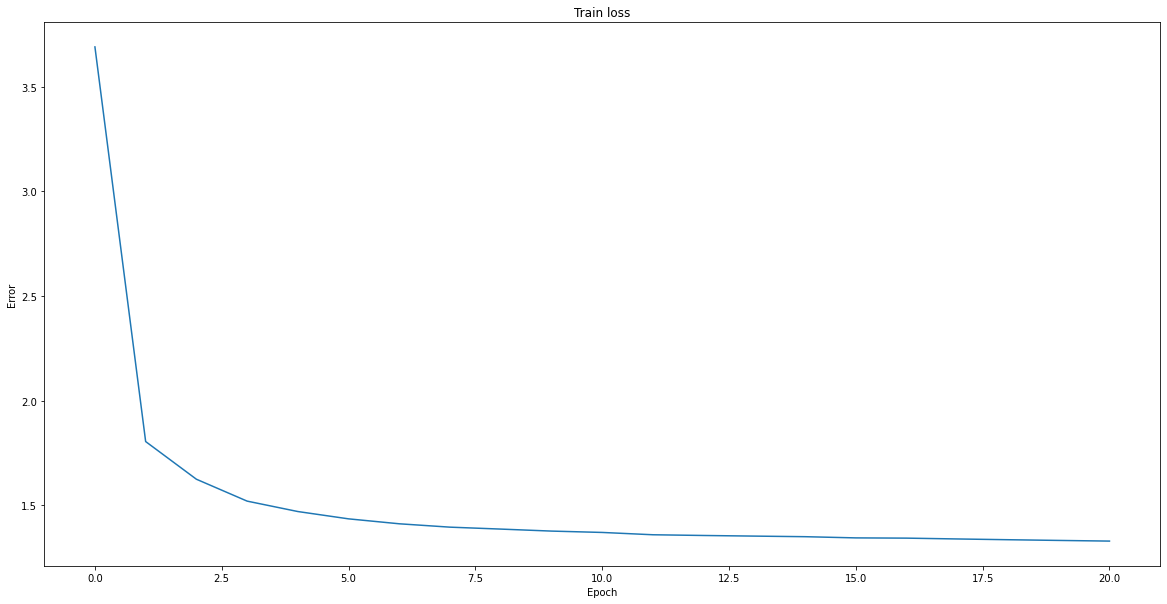

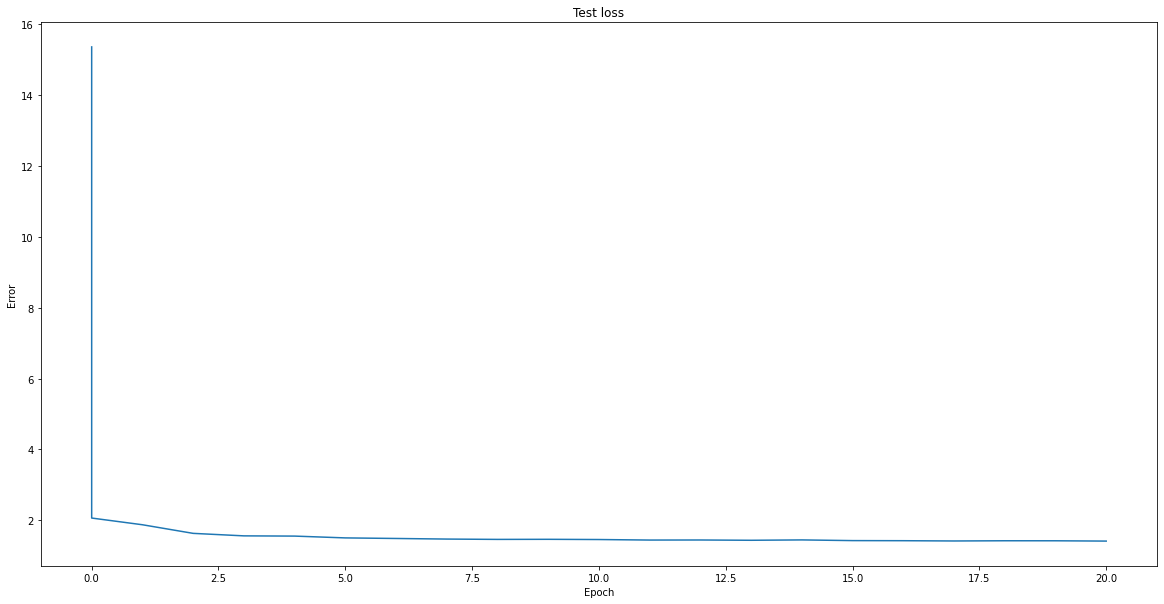

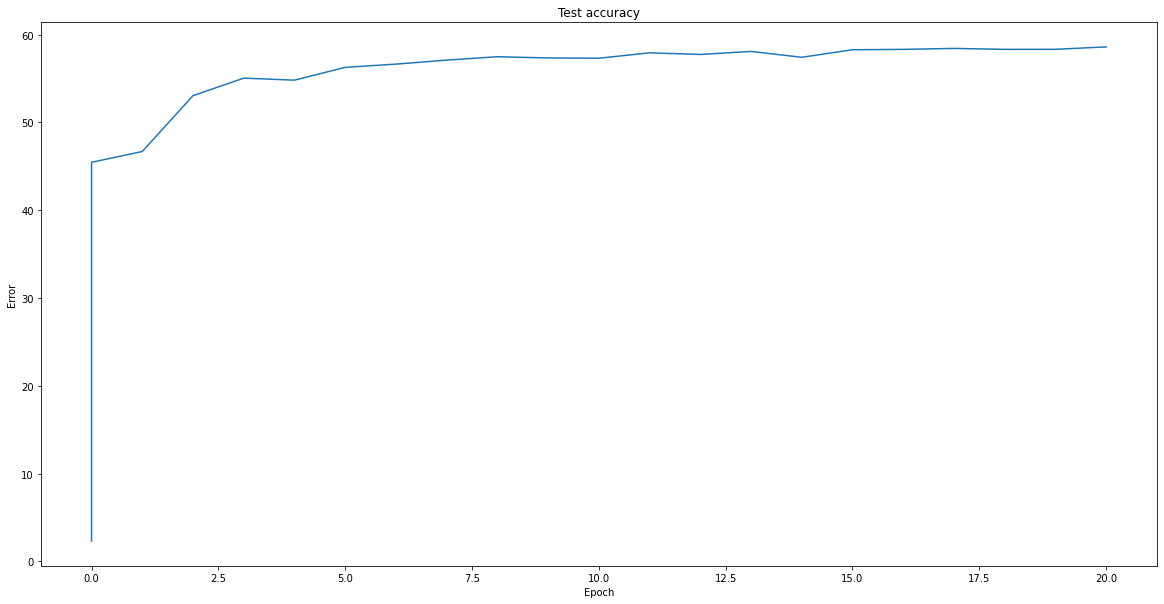

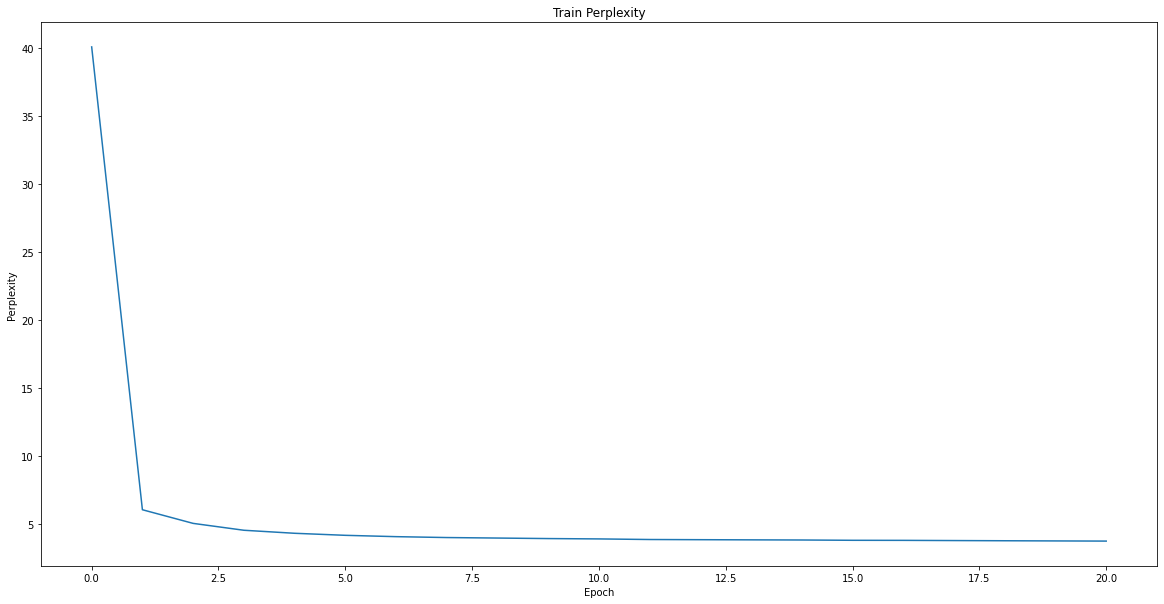

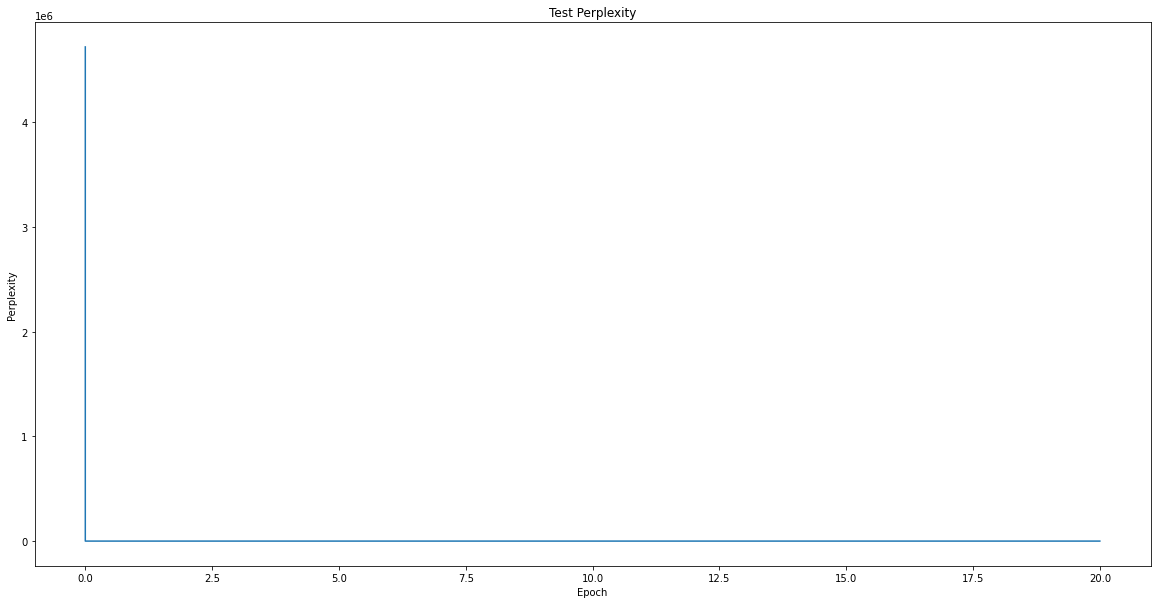

In [11]:
# 7: Random sequence
# Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward.
#     You should also modify the train and test functions to reset the memory when you reset the sequence.
#     You should consider an epoch to be feeding in approximately the number of characters in the dataset.
#     You may run into issues if your dataset size/epochs are not a multiple of your batch size.
from numpy import random

class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.voc2ind = dataset['voc2ind']
        self.ind2voc = dataset['ind2voc']
        dataset = dataset['tokens']
        self.data = torch.tensor(dataset[:len(dataset) - 1], dtype=torch.long)
        self.labels = torch.tensor(dataset[1:], dtype=torch.long)

        self.sequence_counter = 0
        self.sequence_max = 10
        self.total_sequence_count = int(len(self.data) / (self.sequence_length * self.batch_size))
        self.total_sequence_count *= self.batch_size
        self.sequence_position = 0

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return self.total_sequence_count
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        maxStartingPosition = len(self.data) - (self.sequence_max * self.sequence_length)
        if (self.sequence_counter >= self.sequence_max):
            self.sequence_position = random.randint(maxStartingPosition)
            self.sequence_counter = 0
        
        dataChunk = self.data[self.sequence_position : self.sequence_position + self.sequence_length]
        labelChunk = self.labels[self.sequence_position : self.sequence_position + self.sequence_length]
        self.sequence_position += self.sequence_length
        self.sequence_counter += 1
        
        return dataChunk, labelChunk

    def vocab_size(self):
        return len(self.vocab)

import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        if batch_idx % 10 == 0:
            hidden = None

        print(batch_idx)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            if batch_idx % 10 == 0:
                hidden = None
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy


import math

def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE, device).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpointsrandom')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))

    test_loss, test_accuracy = test(model, device, test_loader)
    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))

            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpointsrandom/%03d.pt' % epoch)

            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpointsrandom/%03d.pt' % epoch, 0)

        train_perplexity = list(map(lambda epochLoss: (epochLoss[0], math.exp(epochLoss[1])), train_losses))
        test_perplexity = list(map(lambda epochLoss: (epochLoss[0], math.exp(epochLoss[1])), test_losses))

        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexity)
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_perplexity)
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Perplexity')
        return model, vocab, device

final_model, vocab, device = main()

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    